
# **Explainable Intrusion Detection in IoT (Internet of Things) networks**




This notebook focuses on building deep learning model for classifying network intrusion data, tackling both binary and multi-class classification tasks. Additionally, it includes an explainability component to enhance understanding of the model's decisions

## **Importing Libraries**

First, we will import libraries that we need to start our workflow. The libraries we are using are:

*   PyTorch
*   Optuna
*   SHAP
*   Torchviz
*   Captum
*   NumPy
*   Pandas
*   Matplotlib
*   Scikit-learn

In [ ]:
#Standard libraries for data analysis:----------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imblearn


# sklearn modules for data preprocessing-------------------------------------

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imblearn
from imblearn.pipeline import Pipeline
from collections import Counter

#sklearn modules for Model Evaluation & Improvement---------------------------

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.over_sampling   import RandomOverSampler

#Standard libraries for data visualization---------------------

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None

#_____________
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#Optuna - Hyper Parmameter Tuning _____________

try:
   import optuna
   from optuna.trial import TrialState
except ImportError:
   !pip install optuna
   import optuna
   from optuna.trial import TrialState

#SHAP - Explainability_____________

try:
    import shap
except ImportError:
    !pip install shap
    import shap


#Captum - Explainability_____________

try:
    from captum.attr import IntegratedGradients
    from captum.attr import LayerConductance
    from captum.attr import NeuronConductance
except ImportError:
    !pip install captum
    from captum.attr import IntegratedGradients
    from captum.attr import LayerConductance
    from captum.attr import NeuronConductance

#Torchviz_____________

try:
    from torchviz import make_dot
except ImportError:
    !pip install torchviz
    from torchviz import make_dot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=9e112715f67540a183a5450e15dbe9f52fd6502cc00ece8dc232170f5b89af38
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


#### Default Settings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Set seed for reproducibility
import random
seed_value = 7070
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
#Default Location for saving
modelFilePath='/content/drive/My Drive/Colab Notebooks/Dessertation/Models'

## **Load the Dataset**

In [ ]:
%%time
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 699 ms, sys: 237 ms, total: 936 ms
Wall time: 20.3 s


Checking to see if GPU available to use for model development

In [ ]:
#If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
    torch.cuda.manual_seed_all(seed_value)
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    torch.manual_seed(seed_value)

GPU is available


GPU is avaialbe , we will use this for model development later

In [ ]:
# set path for dataset in google drive
file_path = '/content/drive/My Drive/Colab Notebooks/Dessertation/Dataset/part-00037-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'

In [ ]:
%%time
# Load dataset
df = pd.read_csv(file_path)

CPU times: user 791 ms, sys: 43 ms, total: 834 ms
Wall time: 866 ms


## **EDA (Exploratory Data Analysis)**

To gain a comprehensive understanding of our dataset, we'll conduct a concise Exploratory Data Analysis (EDA). This EDA comprises:
*  Data Visualizations
*  Data Understanding

In [ ]:
# check the shape of data
df.shape

(214963, 47)

In [ ]:
# check the number of rows and columns
print('Number of Rows (Samples): %s' % str((df.shape[0])))
print('Number of Columns (Features): %s' % str((df.shape[1])))

Number of Rows (Samples): 214963
Number of Columns (Features): 47


Our dataset comprises 214963 samples and encompasses 47 features

In [ ]:
df.head()

flow_duration  Header_Length  Protocol Type  Duration          Rate  \
0       2.723815     1311369.09          16.89     65.91    868.958258   
1       6.400284          84.00          17.00     64.00      0.312486   
2       0.000000          54.00           6.00     64.00      1.249814   
3       0.154123       26679.00          17.00     64.00   4637.731648   
4       0.000000          54.00           6.00     64.00  79891.504762   

          Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0    868.958258    0.0              0.0              0.0              0.0   
1      0.312486    0.0              0.0              0.0              0.0   
2      1.249814    0.0              1.0              0.0              1.0   
3   4637.731648    0.0              0.0              0.0              0.0   
4  79891.504762    0.0              0.0              0.0              0.0   

   psh_flag_number  ack_flag_number  ece_flag_number  cwr_flag_number  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   ack_count  syn_count  fin_count  urg_count  rst_count  HTTP  HTTPS  DNS  \
0        0.0        0.0        0.0       0.01       0.01   0.0    0.0  0.0   
1        0.0        0.0        0.0       0.00       0.00   0.0    0.0  0.0   
2        1.0        0.0        1.0       0.00       0.00   0.0    0.0  0.0   
3        0.0        0.0        0.0       0.00       0.00   0.0    0.0  0.0   
4        0.0        0.0        0.0       0.00       0.00   0.0    0.0  0.0   

   Telnet  SMTP  SSH  IRC  TCP  UDP  DHCP  ARP  ICMP  IPv  LLC  Tot sum  \
0     0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0   0.0  1.0  1.0  5756.66   
1     0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0   0.0  1.0  1.0   441.00   
2     0.0   0.0  0.0  0.0  1.0  0.0   0.0  0.0   0.0  1.0  1.0   567.00   
3     0.0   0.0  0.0  0.0  0.0  1.0   0.0  0.0   0.0  1.0  1.0   525.00   
4     0.0   0.0  0.0  0.0  1.0  0.0   0.0  0.0   0.0  1.0  1.0   567.00   

      Min    Max         AVG        Std  Tot size           IAT  Number  \
0  493.66  554.0  549.053242  16.291336    549.69  8.378895e+07     9.5   
1   42.00   42.0   42.000000   0.000000     42.00  8.300757e+07     9.5   
2   54.00   54.0   54.000000   0.000000     54.00  8.334427e+07     9.5   
3   50.00   50.0   50.000000   0.000000     50.00  8.312388e+07     9.5   
4   54.00   54.0   54.000000   0.000000     54.00  8.306736e+07     9.5   

    Magnitue     Radius   Covariance  Variance  Weight             label  
0  33.134927  23.072049  1941.809513      0.14  141.55    Mirai-udpplain  
1   9.165151   0.000000     0.000000      0.00  141.55     DoS-UDP_Flood  
2  10.392305   0.000000     0.000000      0.00  141.55  DDoS-RSTFINFlood  
3  10.000000   0.000000     0.000000      0.00  141.55    DDoS-UDP_Flood  
4  10.392305   0.000000     0.000000      0.00  141.55    DDoS-TCP_Flood

In [ ]:
# check the columns in the dataset
df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

Column 'Label' contains the type of the attack

In [ ]:
# check the number of columns
print('Total columns in our dataset: %s' % str(len(df.columns)))

Total columns in our dataset: 47


Our dataset comprises a grand total of 47 columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214963 entries, 0 to 214962
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    214963 non-null  float64
 1   Header_Length    214963 non-null  float64
 2   Protocol Type    214963 non-null  float64
 3   Duration         214963 non-null  float64
 4   Rate             214963 non-null  float64
 5   Srate            214963 non-null  float64
 6   Drate            214963 non-null  float64
 7   fin_flag_number  214963 non-null  float64
 8   syn_flag_number  214963 non-null  float64
 9   rst_flag_number  214963 non-null  float64
 10  psh_flag_number  214963 non-null  float64
 11  ack_flag_number  214963 non-null  float64
 12  ece_flag_number  214963 non-null  float64
 13  cwr_flag_number  214963 non-null  float64
 14  ack_count        214963 non-null  float64
 15  syn_count        214963 non-null  float64
 16  fin_count        214963 non-null  floa

We can see that all columns exept the label column are float datatype. Label column need to be converted to integer type using label encoding before model development

In [ ]:
# # check the number of values for labels
df['label'].value_counts()

DDoS-ICMP_Flood            33013
DDoS-UDP_Flood             25011
DDoS-TCP_Flood             20573
DDoS-SYN_Flood             18885
DDoS-PSHACK_Flood          18815
DDoS-RSTFINFlood           18548
DDoS-SynonymousIP_Flood    16526
DoS-UDP_Flood              15145
DoS-TCP_Flood              12341
DoS-SYN_Flood               9326
BenignTraffic               5186
Mirai-greeth_flood          4695
Mirai-udpplain              3997
Mirai-greip_flood           3528
DDoS-ICMP_Fragmentation     2127
MITM-ArpSpoofing            1460
DDoS-UDP_Fragmentation      1339
DDoS-ACK_Fragmentation      1286
DNS_Spoofing                 799
Recon-HostDiscovery          589
Recon-PortScan               416
Recon-OSScan                 415
DoS-HTTP_Flood               363
VulnerabilityScan            183
DDoS-HTTP_Flood              122
DDoS-SlowLoris               101
DictionaryBruteForce          50
SqlInjection                  27
CommandInjection              26
BrowserHijacking              25
Backdoor_M

We will further categorize the attack types into seven groups, as specified in the original dataset description later in the data preprocessing section

In [ ]:
df.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

## **Data Preprocessing**

Data preprocessing is a crucial phase in data science as raw data often comes with imperfections such as missing values or inconsistencies. This step involves essential preprocessing techniques to address any potential issues like null or missing values within our dataset.

In [ ]:
# check for some null or missing values in our dataset
df.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

All features in the data have no null or missing value

### Check and Drop Duplicate Rows

In [ ]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"The dataset contains {duplicates} duplicate rows.")

The dataset contains 0 duplicate rows.


### Check and Drop Duplicate Column

In [ ]:
# Check for duplicate columns
duplicated_columns = df.columns[df.columns.duplicated()]
print("Duplicate Columns:", duplicated_columns)

Duplicate Columns: Index([], dtype='object')


In [ ]:
# Check for duplicate columns
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [ ]:
df.shape

(214963, 47)

There are no duplicate columns

We'll examine the distribution of attack classes.

In [ ]:
# # check the number of values for labels
df['label'].value_counts()

DDoS-ICMP_Flood            33013
DDoS-UDP_Flood             25011
DDoS-TCP_Flood             20573
DDoS-SYN_Flood             18885
DDoS-PSHACK_Flood          18815
DDoS-RSTFINFlood           18548
DDoS-SynonymousIP_Flood    16526
DoS-UDP_Flood              15145
DoS-TCP_Flood              12341
DoS-SYN_Flood               9326
BenignTraffic               5186
Mirai-greeth_flood          4695
Mirai-udpplain              3997
Mirai-greip_flood           3528
DDoS-ICMP_Fragmentation     2127
MITM-ArpSpoofing            1460
DDoS-UDP_Fragmentation      1339
DDoS-ACK_Fragmentation      1286
DNS_Spoofing                 799
Recon-HostDiscovery          589
Recon-PortScan               416
Recon-OSScan                 415
DoS-HTTP_Flood               363
VulnerabilityScan            183
DDoS-HTTP_Flood              122
DDoS-SlowLoris               101
DictionaryBruteForce          50
SqlInjection                  27
CommandInjection              26
BrowserHijacking              25
Backdoor_M

There are 34 attack classes, we will further categorize the attack types into seven groups, as specified in the original dataset description.

**DDoS**:  

*   DDoS-RSTFINFlood
*   DDoS-PSHACK_Flood
*   DDoS-SYN_Flood
*   DDoS-UDP_Flood
*   DDoS-TCP_Flood
*   DDoS-ICMP_Flood
*   DDoS-SynonymousIP_Flood
*   DDoS-ACK_Fragmentation
*   DDoS-UDP_Fragmentation
*   DDoS-ICMP_Fragmentation
*   DDoS-SlowLoris
*   DDoS-HTTP_Flood

**DoS**:

*   DoS-UDP_Flood
*   DoS-SYN_Flood
*   DoS-TCP_Flood
*   DoS-HTTP_Flood

**Mirai**:

*  Mirai-greeth_flood
*  Mirai-greip_flood
*  Mirai-udpplain

**Recon**:

*  Recon-PingSweep
*  Recon-OSScan
*  Recon-PortScan
*  VulnerabilityScan
*  Recon-HostDiscovery

**Spoofing**:

*  DNS_Spoofing
*  MITM-ArpSpoofing
*  BenignTraffic

**Web**:

*  BrowserHijacking
*  Backdoor_Malware
*  XSS
*  Uploading_Attack
*  SqlInjection
*  CommandInjection

**BruteForce**:
*  DictionaryBruteForce








In [ ]:
# Grouping the attack types to 8
reduced_labels = {
    'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon', 'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing', 'BenignTraffic': 'Benign', 'BrowserHijacking': 'Web',
    'Backdoor_Malware': 'Web', 'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web',
    'CommandInjection': 'Web', 'DictionaryBruteForce': 'BruteForce'
}

df['label'] = df['label'].apply(lambda attack_name : reduced_labels[attack_name])

In [ ]:
df['label'].value_counts()

DDoS          156346
DoS            37175
Mirai          12220
Benign          5186
Spoofing        2259
Recon           1612
Web              115
BruteForce        50
Name: label, dtype: int64

We've categorized the attacks into eight groups, with DDoS attacks being the most frequent and BrutForce attacks being the least frequent among them.

We will also keep a copy of the dataset for model develpment for binary classification

In [ ]:
df_Binary=df.copy()


In [ ]:
# Grouping attack types to attack and benign
df_Binary['label'] = df_Binary['label'].apply(lambda x: 'Attack' if x != 'Benign' else 'Benign')

# Check the updated DataFrame
print(df_Binary['label'].value_counts())

Attack    209777
Benign      5186
Name: label, dtype: int64


For the development of a binary classification model, the attacks have been categorized into 'Attack' and 'Benign' classes

In [ ]:
df_Binary.shape

(214963, 47)

## **Data Visualizations**

After obtaining valuable insights from our data, we proceed to visualize it, aiming to observe the trends present in our dataset.

**Multi Class**

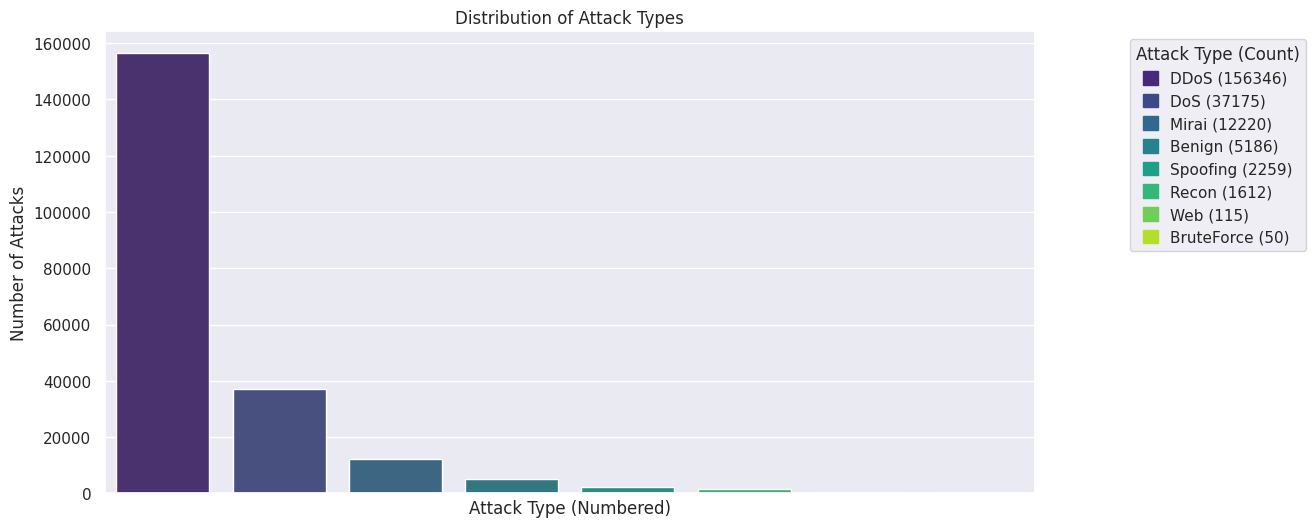

In [ ]:
sns.set(rc={'figure.figsize': (12, 6)})
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
sns.set_theme()

# Count occurrences of each label and plot
label_counts = df['label'].value_counts()
ax = sns.countplot(x='label', data=df, order=label_counts.index, palette='viridis')

# Set x-axis labels as numbers and display labels + counts in the legend
ax.set(xlabel='Attack Type (Numbered)', ylabel='Number of Attacks')

# Create a custom legend with labels, their counts, and colors
legend_labels = [f"{label} ({count})" for label, count in zip(label_counts.index, label_counts.values)]
handles = [plt.Rectangle((0, 0), 0, 0, label=label, color=color) for label, color in zip(label_counts.index, sns.color_palette('viridis', len(label_counts)))]

plt.legend(handles=handles, labels=legend_labels, title='Attack Type (Count)', loc='upper right', bbox_to_anchor=(1.3, 1), handlelength=1, handleheight=1)
plt.xticks([])  # Remove x-axis ticks

plt.show()


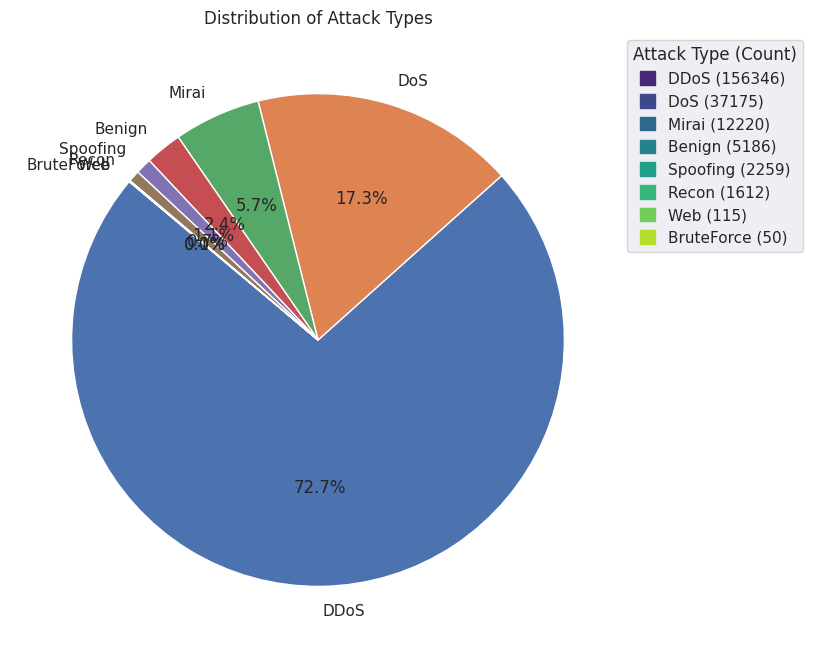

In [ ]:
sns.set(rc={'figure.figsize': (8, 8)})
plt.title('Distribution of Attack Types')

# Count occurrences of each label
label_counts = df['label'].value_counts()

# Create a pie chart
ax = plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)

# Create a custom legend with labels, their counts, and colors
legend_labels = [f"{label} ({count})" for label, count in zip(label_counts.index, label_counts.values)]
handles = [plt.Rectangle((0, 0), 0, 0, label=label, color=color) for label, color in zip(label_counts.index, sns.color_palette('viridis', len(label_counts)))]

plt.legend(handles=handles, labels=legend_labels, title='Attack Type (Count)', loc='upper right', bbox_to_anchor=(1.3, 1), handlelength=1, handleheight=1)
plt.xticks([])  # Remove x-axis ticks
plt.show()


**Binary Class**

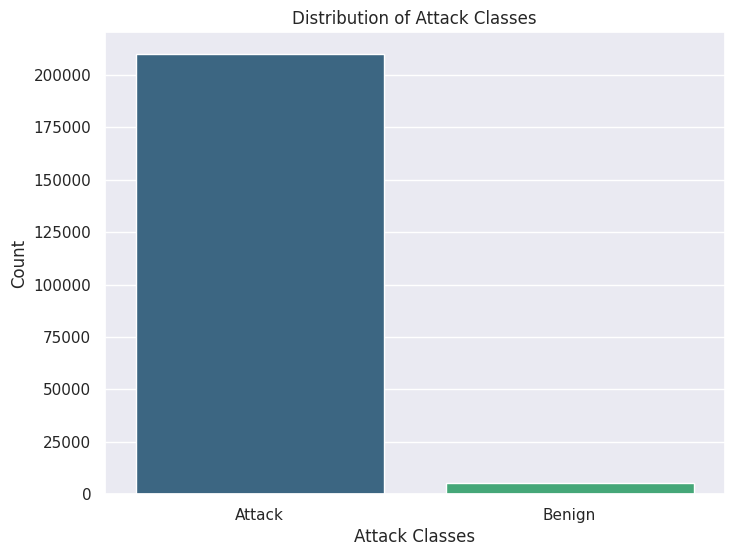

In [ ]:
# Assuming 'label' is the column you want to plot
label_counts = df_Binary['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Attack Classes')
plt.xlabel('Attack Classes')
plt.ylabel('Count')
plt.show()

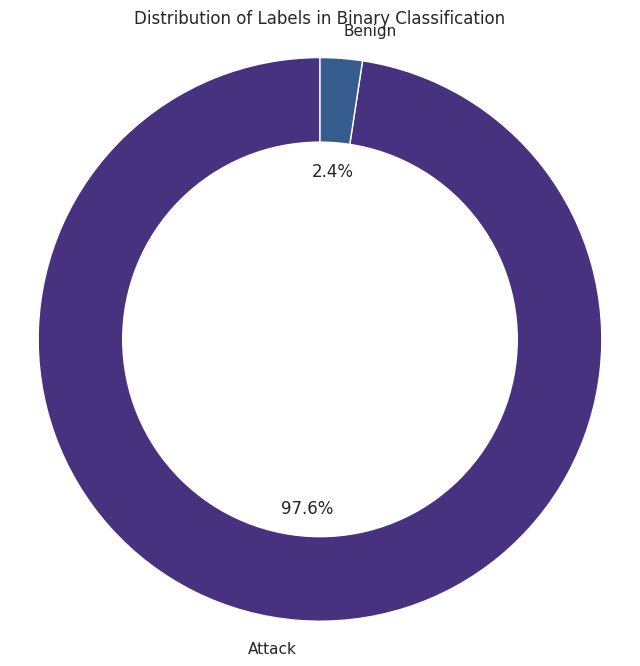

In [ ]:
# Set up the pie chart
plt.figure(figsize=(8, 8))
# Count occurrences of each label and plot
label_counts_binary = df_Binary['label'].value_counts()
plt.pie(label_counts_binary, labels=label_counts_binary.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), startangle=90)

# Draw a circle at the center to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.title('Distribution of Labels in Binary Classification')
plt.show()


## **Model Building: Multi-Layer Perceptron (MLP)**

In this phase, we construct a Multi-Layer Perceptron (MLP), a versatile neural network architecture, for our machine learning task.

A multilayer perceptron (MLP) is a class of feedforward artificial neural network characterized by multiple layers of interconnected nodes, capable of learning complex patterns and relationships in data.

### **Model Development**

#### Model Preparation Phase



In the preparation phase of the model development process, we focus on organizing the dataset to facilitate effective model training. This phase involves the following key steps:

1. **Label Encoding:**
   - The categorical labels in the dataset are encoded into numerical values using the `LabelEncoder` from the scikit-learn library.
   - This step is essential for converting categorical data into a format suitable for machine learning algorithms.
   - The 'label' feature within the dataset consists of 2 categories for binary classification: 'Attack','Benign' all represented as strings. To facilitate comprehension by our neural network, it's necessary to convert these categorical labels into numerical representations.

2. **Train/Test/Validation Split:**
   - The dataset is split into training, testing, and validation sets using the `train_test_split` function from scikit-learn.
   - The dataset is divided into subsets—training data (used for model training) and testing data (used for evaluating model performance)—ensuring that the model's effectiveness is assessed on unseen data, helping to gauge its generalization ability.

3. **Standard Scaling:**
   - Standard scaling is applied to the features using the `StandardScaler` from scikit-learn.
   - Scaling ensures that features are on a similar scale, preventing certain features from dominating the learning process and improving model convergence.

By performing these preparatory steps, we aim to create a well-organized and standardized dataset for the subsequent model building phase. This sets the foundation for developing a robust and effective machine learning model.

Now, let's proceed with the actual model development following this data preparation phase.


In [ ]:
def model_prep(df,model_type):

    # Label Encoding...

    print("Starting label encoding...")
    print('Before Label Encoding....')
    print(df['label'].value_counts())
    label_enc = LabelEncoder()
    df['label']= label_enc.fit_transform(df['label'])
    classes_=label_enc.classes_
    print('After Label Encoding....')
    print(df['label'].value_counts())
    print("Label encoding completed.")
    print("....................................................")


    # Train-Test Split
    print("Performing train-test split...")

    X = df.drop(['label'], axis=1).values
    y = df['label'].values

    #sampling
    if model_type == 'MLP_MultiClass':
          print("Before sampling the data:\n")
          print("Instances per label in training set:")
          unique_train, counts_train = np.unique(y, return_counts=True)
          sorted_indices_train = np.argsort(counts_train)[::-1]  # Sort indices based on counts in descending order
          for idx in sorted_indices_train:
              print(f"{unique_train[idx]}: {counts_train[idx]} instances")

          oversample =  RandomOverSampler(sampling_strategy={1: 1500 , 7: 1500  })
          undersample = RandomUnderSampler(sampling_strategy={2: 37175 })

          pipeline = Pipeline([
              ('oversampling', oversample)
          ])

          X_resampled, y_resampled = pipeline.fit_resample(X, y)
          X_resampled, y_resampled = pipeline.fit_resample(X_resampled, y_resampled)

          print("After sampling the data:\n")
          print("Instances per label in training set:")
          unique_train, counts_train = np.unique(y_resampled, return_counts=True)
          sorted_indices_train = np.argsort(counts_train)[::-1]  # Sort indices based on counts in descending order
          for idx in sorted_indices_train:
              print(f"{unique_train[idx]}: {counts_train[idx]} instances")

          print("Finished Sampling\n")

    # Train - Test split
    if model_type == 'MLP_MultiClass':
      X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=seed_value)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
    # Train - Validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

    print("after spliting the data:\n")
    print("training data length:", len(X_train))
    print("test data length:", len(X_test))
    print("validation data length:", len(X_valid))
    print("Train-test split completed.")
    print("....................................................")

    print("Performing standard scaling...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_valid = scaler.transform(X_valid)
    print("Standard scaling completed.")

    print("All preprocessing tasks completed successfully!")

    return X_train, X_test,X_valid, y_train, y_test,y_valid,classes_

#### Batching and loading as tensor

In this phase of model development, we focus on efficiently processing the dataset by batching and loading it as tensors. This phase optimizes computational efficiency and lays the groundwork for effective model training.

In [ ]:
def prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size):
    x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_valid, dtype=torch.long)
    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # create Tensor datasets ,
    train_data = TensorDataset(x_train_tensor, y_train_tensor)
    test_data =  TensorDataset(x_test_tensor, y_test_tensor)
    valid_data = TensorDataset(x_val_tensor, y_val_tensor)

    # dataloaders
    num_workers = 0

    # SHUFFLE training data
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,num_workers=num_workers)
    test_loader =  DataLoader(test_data,  shuffle=False,batch_size=batch_size,num_workers=num_workers)
    valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size,num_workers=num_workers)

    return train_loader,test_loader,valid_loader,x_train_tensor

Now, with the data prepared and organized, we can proceed to construct and train the machine learning model.

#### Model - Training & Validation

In the training and validation phase, we embark on the process of teaching our machine learning model to understand patterns and relationships within the data.This phase involves the following critical steps:

1.   Model Construction

  We design and instantiate the architecture of our machine learning model, Multi Layer Perceptron. This may involve defining the layers, activation functions, and dropouts.
The model is constructed using deep learning frameworks ,PyTorch

2.   Loss Function and Optimization:

  The loss function  selected to measure the disparity between the model's predictions and the actual target values is Binary Cross Entropy.
The optimization algorithm,Adam, is employed to minimize the loss and adjust the model's parameters during training.

3.   Training Loop:

  The model is iteratively trained on batches of the training dataset. In each iteration (epoch), the model updates its parameters to improve its performance.
  During training, we monitor the model's progress on a separate validation dataset to assess its generalization capabilities.

4.   Validation and Fine-Tuning:

  The model's performance on the validation set is evaluated to ensure it generalizes well to unseen data.

5.   Monitoring and Visualization:

  *   We monitor the training and validation loss over epochs to understand the convergence of the model.
  *   Training and validation accuracy are plotted to visualize the model's learning progress.
  *   Confusion matrix is generated and displayed for the test dataset, providing insights into the model's classification performance.
  *   The Receiver Operating Characteristic (ROC) curve is plotted along with the Area Under the ROC Curve (AUROC) score to assess the model's ability to discriminate between classes.

In [ ]:
from tqdm import tqdm

# Plotting training and validation loss
def plot_loss(epoch_tr_loss,epoch_vl_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_tr_loss, label='Training Loss')
    plt.plot(epoch_vl_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


# Plotting training and validation Accuracy
def plot_accuracy(epoch_tr_acc_list,epoch_vl_acc_list):
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_tr_acc_list, label='Training Accuracy')
    plt.plot(epoch_vl_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Evaluation on test set
def model_evaluation(model,model_type,test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs.to(device)

            if model_type == 'MLP_Binary':
                    predicted = torch.round(outputs).squeeze()  # Round predictions to 0 or 1
            else:
                    _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    return all_predictions,all_targets

def plot_confusion_matrix(all_targets,all_predictions,classname,model_type):
  # Ploting Confusion matrix
    class_names =classname
    cm=confusion_matrix(all_targets, all_predictions)

    if model_type == 'MLP_MultiClass':
          # Calculate overall accuracy
          accuracy = accuracy_score(all_targets, all_predictions)

          # Calculate overall precision, recall, and F1-score manually
          precision, recall, f1score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

          metrics_df = pd.DataFrame({
              'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
              'Score': [precision, recall, f1score, accuracy]
          })
          metrics_df.set_index('Metric', inplace=True)
          metrics_df.style.background_gradient()
    else:
          precision = precision_score(all_targets, all_predictions, average=None)
          recall = recall_score(all_targets, all_predictions, average=None)
          f1 = f1_score(all_targets, all_predictions, average=None)
          accuracy = accuracy_score(all_targets, all_predictions)

          # Create a DataFrame to display the results in a table
          df_Evaluation = pd.DataFrame({
              'Class': class_names,
              'Precision': precision,
              'Recall': recall,
              'F1-Score': f1,
              'Accuracy': accuracy
          })
          df_Evaluation.set_index('Class', inplace=True)
          # Plot confusion matrix
          plt.figure(figsize=(10, 8))
          sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
          plt.title('Confusion Matrix')
          plt.show()

          display(df_Evaluation.style.background_gradient())


# Calculate the ROC curve and AUC
def plot_auroc_binary(all_targets, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_targets, all_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Print the AUC score
    print(f"AUROC: {roc_auc:.4f}")

def plot_roc_curve_multiclass(labels, predictions, num_classes,class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels, predictions, pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC Curve')
    plt.legend()
    plt.show()

def loadBestModel(model_type,num_input_features,state_file_name):
    if model_type == 'MLP_Binary':
        model_loaded=MLP_Binary(num_input_features,4,[150,50,23],0.29)
    else:
        model_loaded=MLP_MultiClass(num_input_features,2,[116,52],0.06570851588706009)

    loaded_state_dict = torch.load(state_file_name)
    model_loaded.load_state_dict(loaded_state_dict)
    return model_loaded

def model_training(model_type,num_input_features,learning_rate,criterion,train_loader,test_loader,valid_loader,epochs):

    if model_type == 'MLP_Binary':
        model=MLP_Binary(num_input_features,4,[150,50,23],0.29)
    else:
        model=MLP_MultiClass(num_input_features,2,[116,52],0.06570851588706009)

    #moving to gpu
    model.to(device)

    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    list_train_loss, list_val_loss = [], []
    best_val_loss = None

    # train for some number of epochs
    valid_loss_min = np.Inf
    patience = 50
    no_improvement_counter = 0

    running_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc_list,epoch_vl_acc_list = [],[]

    saved_model_detail = {}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_losses = []
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs.to(device)

            # calculate the loss and perform backprop
            if model_type == 'MLP_Binary':
                loss = criterion(outputs.squeeze(), labels.float())
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            running_loss += loss.item()

            if model_type == 'MLP_Binary':
                predicted = torch.round(outputs).squeeze()  # Round predictions to 0 or 1
            else:
              _, predicted = torch.max(outputs, 1)

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        # Calculate average training loss for the epoch
        epoch_train_accuracy = (correct_train / total_train) * 100 if total_train > 0 else 0.0
        epoch_tr_acc_list.append(epoch_train_accuracy)

    # validation loop

        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        val_losses = []
        for inputs, labels in valid_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                if model_type == 'MLP_Binary':
                    val_loss = criterion(outputs.squeeze(), labels.float())
                else:
                    val_loss = criterion(outputs, labels)

                val_running_loss += val_loss.item()
                val_losses.append(val_loss.item())

                if model_type == 'MLP_Binary':
                    predicted = torch.round(outputs).squeeze()  # Round predictions to 0 or 1
                else:
                    _, predicted = torch.max(outputs, 1)

                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss for the epoch
        epoch_val_accuracy = (correct_val / total_val) * 100 if total_val > 0 else 0.0
        epoch_vl_acc_list.append(epoch_val_accuracy)

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)

        if(epoch % 10 == 0):
            print(f"Epoch {epoch + 1}")
            print(f"train_loss : {epoch_train_loss:.8f} val_loss : {epoch_val_loss:.8f}")
            print(f"train_accuracy : {epoch_train_accuracy:.2f} val_accuracy : {epoch_val_accuracy:.2f}")
            print(25*'==')

    plot_loss(epoch_tr_loss, epoch_vl_loss)

    # Plotting training and validation accuracy
    plot_accuracy(epoch_tr_acc_list,epoch_vl_acc_list)

    # Evaluation on test set
    all_predictions ,all_targets =model_evaluation(model,model_type,test_loader)

    # Ploting Confusion matrix
    if model_type == 'MLP_Binary':
        class_names = classname_binary
    else:
        class_names = classname_multiclass
    plot_confusion_matrix(all_targets,all_predictions,class_names,model_type)

    # Calculate the ROC curve and AUC
    if model_type == 'MLP_Binary':
        plot_auroc_binary(all_targets, all_predictions)
    return model


### **Save Model**

In [ ]:
# Save input tensors and model
import pickle
import os

def save_model(model,filename):
    with open(filename, 'wb') as f:
        pickle.dump({
            'X_train': X_train,
            'X_test': X_test,
            'X_valid': X_valid,
            'y_train': y_train,
            'y_test': y_test,
            'y_valid': y_valid,
            'train_loader': train_loader,
            'test_loader': test_loader,
            'valid_loader': valid_loader,
            'model_state_dict': model.state_dict()
        }, f)


def load_model(filename,input_features):
    dic_detail={}
    # Load input tensors and model
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        dic_detail['loaded_X_train'] = data['X_train']
        dic_detail['loaded_X_test'] = data['X_test']
        dic_detail['loaded_X_valid'] = data['X_valid']
        dic_detail['loaded_y_train'] = data['y_train']
        dic_detail['loaded_y_test'] = data['y_test']
        dic_detail['loaded_y_valid'] = data['y_valid']
        dic_detail['loaded_train_loader'] = data['train_loader']
        dic_detail['loaded_test_loader'] = data['test_loader']
        dic_detail['loaded_valid_loader'] = data['valid_loader']
        dic_detail['loaded_model_state_dict'] = data['model_state_dict']

    # Load your PyTorch model
    model_Loaded=MLP_MultiClass(input_features,2,[116,52],0.06570851588706009)
    model_Loaded.load_state_dict(dic_detail['loaded_model_state_dict'])
    return model_Loaded,dic_detail

## **Multi Layer Perceptron - Binary Classification**

In this section, we construct a Multilayer Perceptron (MLP) model for binary classification.

The binary classification Multi-Layer Perceptron (MLP) model consists of an input layer with 46 features, three hidden layers with 150, 50, and 23 neurons, respectively, followed by ReLU activation, and an output layer with a single neuron and Sigmoid activation. Dropout regularization with a probability of 0.29 is applied to enhance generalization during training.

In [ ]:
# Multi Layer Perceptron - Binary Classification
class MLP_Binary_Captum(nn.Module):
    def __init__(self, num_input_features,dropout_prob, num_hidden_neuron1, num_hidden_neuron2,num_hidden_neuron3):
        super(MLP_Binary, self).__init__()
        self.hidden_layer1 = nn.Linear(num_input_features, num_hidden_neuron1)
        self.hidden_layer2 = nn.Linear(num_hidden_neuron1, num_hidden_neuron2)
        self.hidden_layer3 = nn.Linear(num_hidden_neuron2, num_hidden_neuron3)
        self.output_layer  = nn.Linear(num_hidden_neuron3, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        for layer in [self.hidden_layer1, self.hidden_layer2, self.hidden_layer3]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, X):

        hidden_res1 = self.relu(self.hidden_layer1(X))
        hidden_res1 = self.dropout(hidden_res1)

        hidden_res2 = self.relu(self.hidden_layer2(hidden_res1))
        hidden_res2 = self.dropout(hidden_res2)

        hidden_res3 = self.relu(self.hidden_layer3(hidden_res2))
        hidden_res3 = self.dropout(hidden_res3)

        output = self.sigmoid(self.output_layer(hidden_res3))
        return output

class MLP_Binary(nn.Module):

    def __init__(self,num_input_features, num_fc_layers, num_neurons, drop_fc1):

        super(MLP_Binary, self).__init__()                     # Initialize parent class
        self.fc_layers = nn.ModuleList()                # List with the FC layers
        self.p1 = drop_fc1                              # Dropout ratio for FC1

        # Define the fully connected layers
        in_features = num_input_features                               # Input features for the dataset
        for i in range(num_fc_layers - 1):
            out_features = num_neurons[i]
            self.fc_layers.append(nn.Linear(in_features, out_features))  # Add FC layer
            in_features = out_features                                # Update input features for next layer

        # Output layer
        self.fc_layers.append(nn.Linear(out_features, 1))  # 8 output classes for intrusion detection

        # Initialize weights with the He initialization
        for layer in self.fc_layers[:-1]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for i, fc_i in enumerate(self.fc_layers[:-1]):  # For each fully connected layer except the last one
            x = F.relu(fc_i(x))                         # Fully connected layer followed by ReLU
            if i <= len(self.fc_layers) - 2:            # Apply dropout except for the last layer
               x = F.dropout(x, p=self.p1, training=self.training)

        x = self.fc_layers[-1](x)                      # Final fully connected layer (output layer)

        return F.sigmoid(x)                 # softmax(x)

Here is the code implementation for the model development, where we define the architecture, set hyperparameters, and conduct the training and validation process for the binary classification Multilayer Perceptron (MLP) model.



#### 1.   Model Preparation Phase



In [ ]:
# Model preparation
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_binary = model_prep(df_Binary,'MLP_Binary')

Starting label encoding...
Before Label Encoding....
Attack    209777
Benign      5186
Name: label, dtype: int64
After Label Encoding....
0    209777
1      5186
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
after spliting the data:

training data length: 137576
test data length: 42993
validation data length: 34394
Train-test split completed.
....................................................
Performing standard scaling...
Standard scaling completed.
All preprocessing tasks completed successfully!


#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=1024
train_loader,test_loader,valid_loader,x_train_tensor = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)
x_train_tensor_binary = x_train_tensor

#### 3.   Model - Training & Validation

MLP_Binary(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=23, bias=True)
    (3): Linear(in_features=23, out_features=1, bias=True)
  )
)
Epoch 1
train_loss : 0.04928354 val_loss : 0.02412722
train_accuracy : 97.85 val_accuracy : 98.78
Epoch 11
train_loss : 0.01832246 val_loss : 0.01669004
train_accuracy : 99.20 val_accuracy : 99.22
Epoch 21
train_loss : 0.01774788 val_loss : 0.01649040
train_accuracy : 99.26 val_accuracy : 99.26
Epoch 31
train_loss : 0.01701509 val_loss : 0.01607907
train_accuracy : 99.26 val_accuracy : 99.29
Epoch 41
train_loss : 0.01669412 val_loss : 0.01647113
train_accuracy : 99.27 val_accuracy : 99.32
Epoch 51
train_loss : 0.01639680 val_loss : 0.01628621
train_accuracy : 99.29 val_accuracy : 99.18
Epoch 61
train_loss : 0.01665597 val_loss : 0.01644349
train_accuracy : 99.29 val_accuracy : 99.26
Epoch 71
train_loss : 

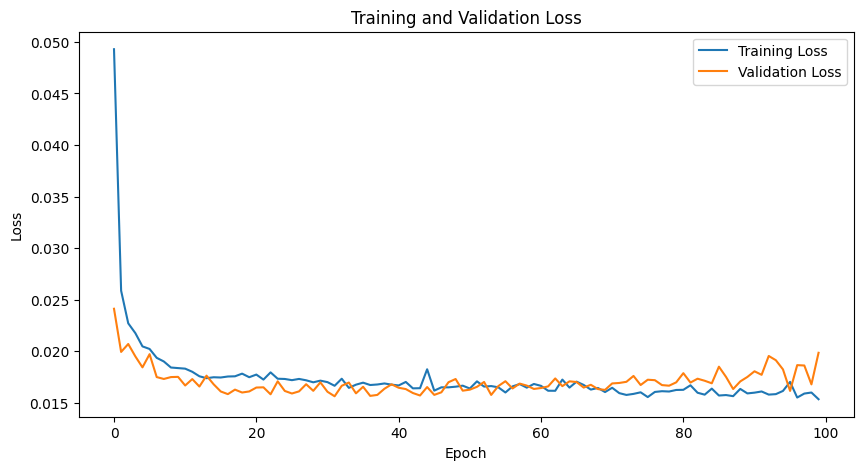

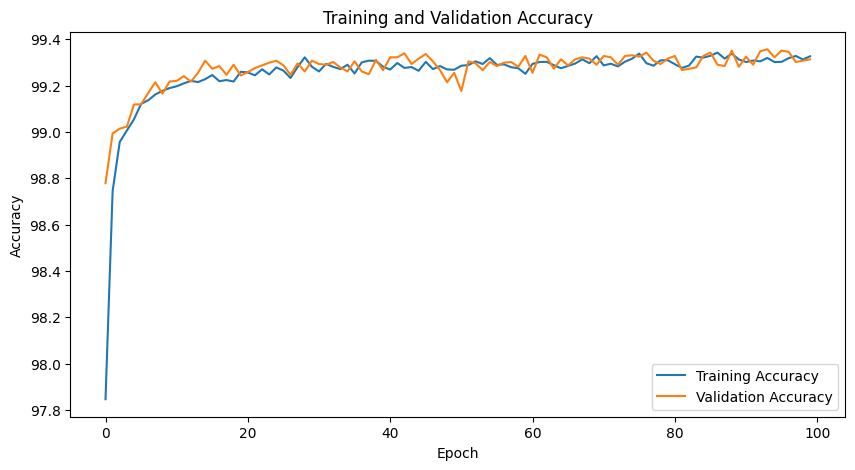

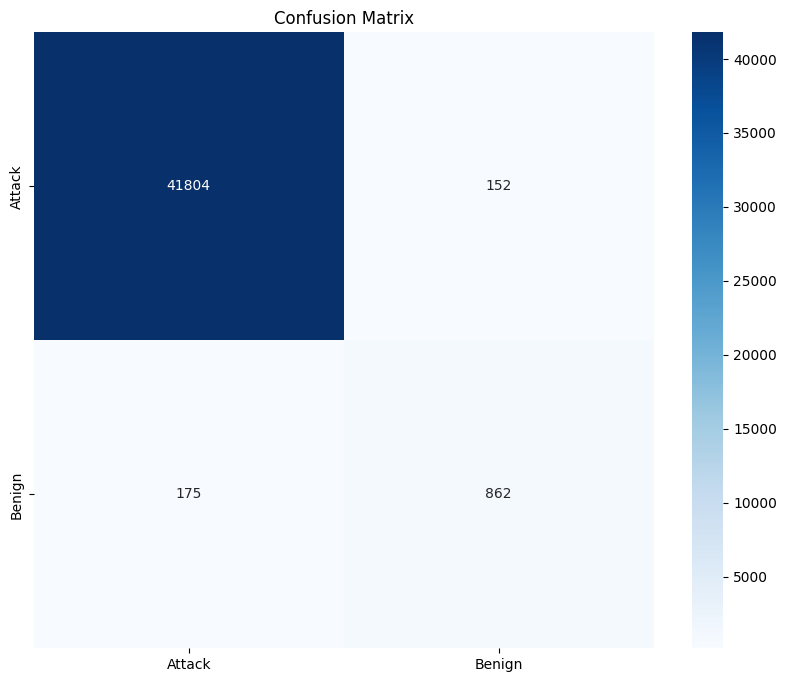

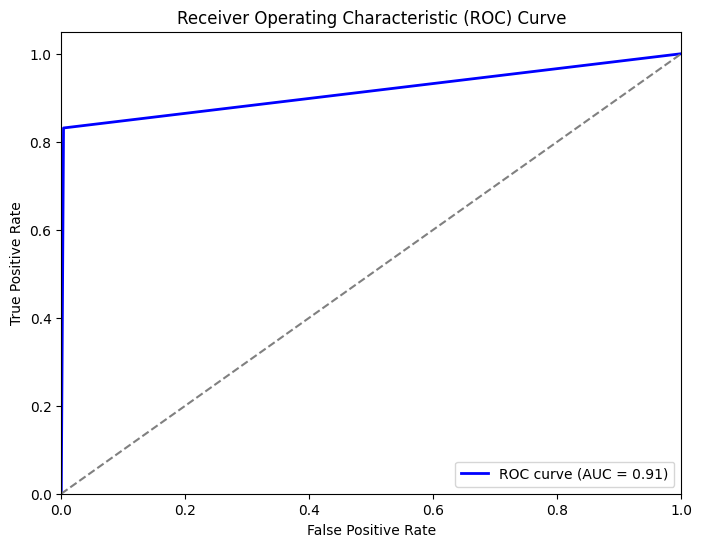

AUROC: 0.9138
CPU times: user 1min 7s, sys: 32.2 s, total: 1min 40s
Wall time: 2min 7s


In [ ]:
%%time
# Train MLP model for binary classification
input_features=46
learning_rate=0.007
loss=nn.BCELoss()
epochs= 100
model=model_training('MLP_Binary',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

### **Explainability**

After constructing our model, the subsequent phase involves enhancing the interpretability of Neural Networks. Therefore, our focus shifts towards examining the attributions of the constructed Neural Networks.

We will be analyzing explainability with two libraries, Captum & SHAP. These libraries provide tools for attributing model predictions to input features, aiding in the understanding of how specific features contribute to the model's output.

### 1.   **Captum**





CAPtum is a model interpretability library developed by Facebook AI Research (FAIR) that seamlessly integrates with PyTorch, offering a suite of algorithms for attributing predictions in neural network models, aiding in the understanding of feature attributions to model outputs.

These attributions encompass three categories: Primary Attribution, Layer Attribution, and Neuron Attribution.

**Primary Attribution**

The primary aspect of Captum involves assessing the primary attributions, which determines the impact of individual input features on the model's output. To achieve this, the Integrated Gradients Algorithm is utilized to compute these primary attributions.

In the provided code snippet, the Integrated Gradients Algorithm is employed to determine the significant attributes at the feature level. Subsequently, the output is visualized for analysis and interpretation.

In [ ]:
%%time
model = nn.DataParallel(model)
model = model.to(device)

# Captum Integrated Gradients
interpreter = IntegratedGradients(model)

aggregated_attributions = []

# Iterate over the test dataloader batches
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
    inputs.requires_grad_()
    # Generate attributions using Integrated Gradients
    attributions, _ = interpreter.attribute(inputs, target=0, return_convergence_delta=True)
    aggregated_attributions.append(attributions)

# Concatenate the attributions along the batch dimension
aggregated_attributions = torch.cat(aggregated_attributions, dim=0)

# Convert the aggregated_attributions tensor to a numpy array
attributions_np = aggregated_attributions.cpu().detach().numpy()  # Move to CPU for numpy conversion

# Calculate the mean attributions across all samples
mean_attributions = np.mean(attributions_np, axis=0)

CPU times: user 34.1 s, sys: 609 ms, total: 34.7 s
Wall time: 34.7 s


**Visualization of the Output:**

Average Feature Importances


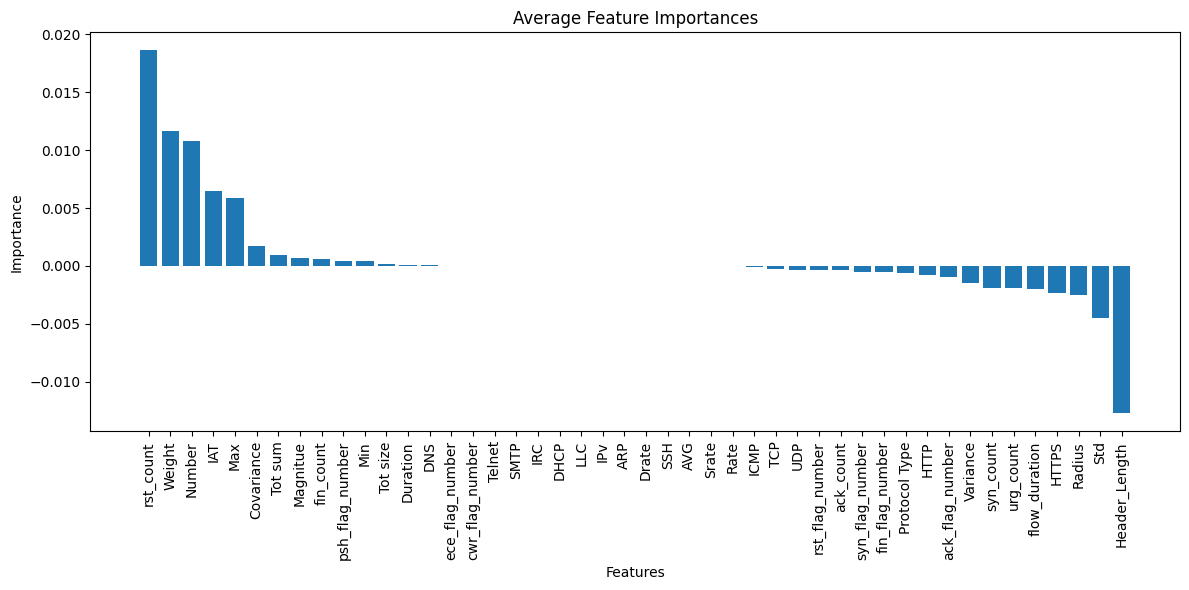

In [ ]:
def visualize_importances(type,feature_names, importances, title="Average Feature Importances", axis_title="Features"):
    print(title)
    feature_importances = list(zip(feature_names, importances))
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    sorted_feature_names, sorted_importances = zip(*feature_importances)

    # for i in range(len(sorted_feature_names)):
    #     print(sorted_feature_names[i], ": ", '%.3f'%(sorted_importances[i]))
    if type == 1 or type == 3:
        heading='Feature Names'
    else:
        heading='Neuron'

    data = {heading: sorted_feature_names, 'Importances': sorted_importances}
    df = pd.DataFrame(data)
    df.set_index(heading, inplace=True)
    display(df.style.background_gradient())

    x_pos = np.arange(len(sorted_feature_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x_pos, sorted_importances, align='center')
    plt.xlabel(axis_title)
    plt.ylabel("Importance")
    plt.title(title)

    plt.xticks(x_pos, sorted_feature_names, rotation=90)  # Rotating x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
    return sorted_feature_names, sorted_importances


feature_names = df_Binary.drop(columns='label').columns
sorted_feature_names, sorted_importances= visualize_importances(1,feature_names, np.mean(attributions_np, axis=0))


Based on the depicted graph, we can deduce that rst_count and Header_Length significant roles in predicting diabetes. Positive weights indicate a stronger association between higher rst_count and the likelihood of attack occurrence. Conversely, the negative weight associated with Header_Length suggests that lower Header_Length may correlate with a higher likelihood of attack.

**Layer Attribution:**

Layer attributions provide insights into the significance of individual neurons contributing to the output within a specific layer of the neural network architecture.


To employ Layer Conductance, we instantiate a LayerConductance object by providing the model and specifying the module (layer) from which we aim to comprehend the output. Here, we specifically select the output originating from the third hidden layer.


The provided code demonstrates the implementation of the Layer Conductance Algorithm specifically targeting the third hidden layer (where model.hidden_layer3 represents the output of this hidden layer). This code segment aims to visualize the resulting output.

In [ ]:
cond = LayerConductance(model.module, model.module.hidden_layer2)

In [ ]:
cond_vals_list = []
#model = nn.DataParallel(model)
model = model.to(device)
# Set model to evaluation mode
model.eval()

cond_vals_list = []
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate conductance for the given inputs
    cond_vals = cond.attribute(inputs)
    cond_vals_list.append(cond_vals.detach().cpu().numpy())

# Concatenate the conductance values along the batch dimension
cond_vals_combined = np.concatenate(cond_vals_list, axis=0)

Checking the shape of conductance array

In [ ]:
cond_vals_combined.shape

(42993, 50)

It contains details about 50 neorons in the second layer

**Visualize**

Average Neuron Importances


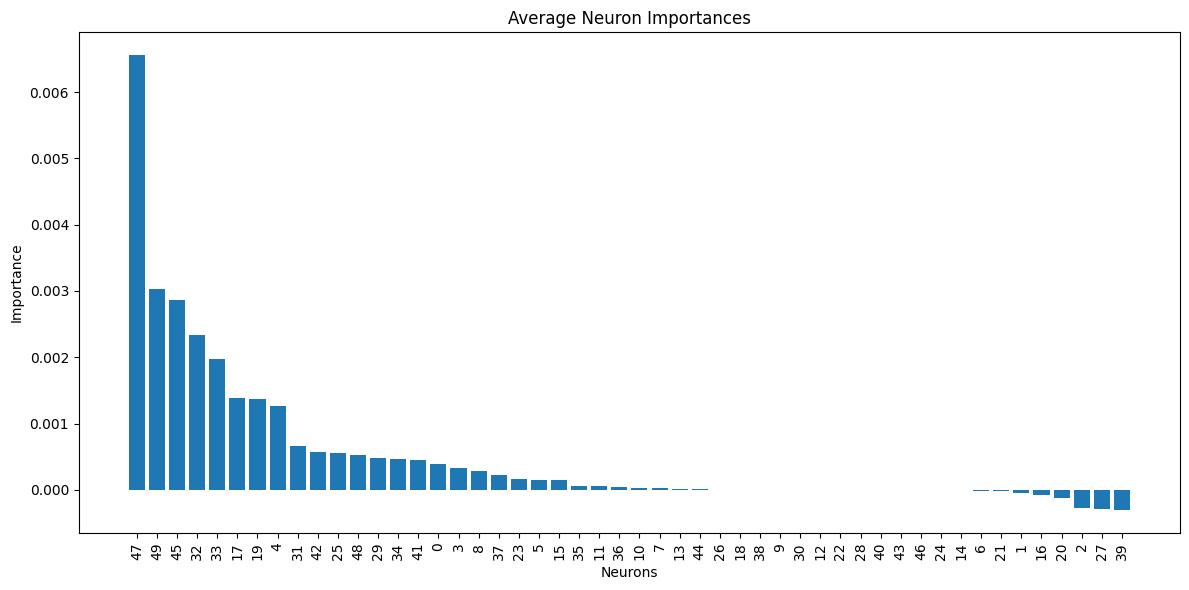

In [ ]:
# Visualize the layer conductance
sorted_feature_names, sorted_importances=visualize_importances(2,range(50),np.mean(cond_vals_combined, axis=0),title="Average Neuron Importances", axis_title="Neurons")

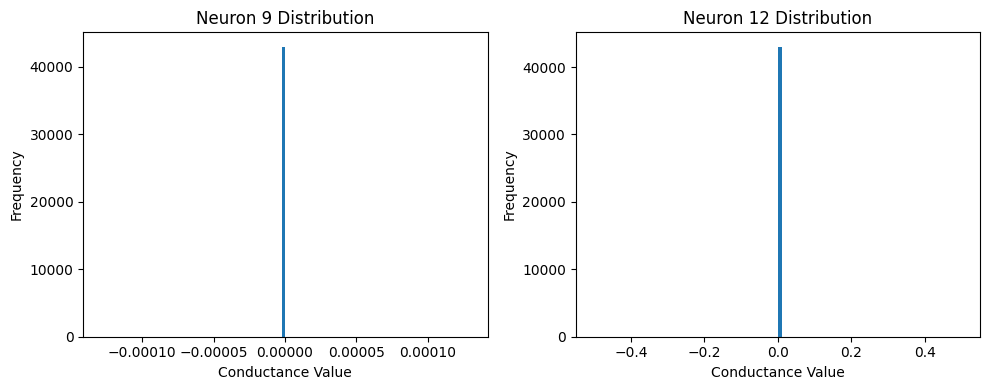

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the histogram for Neuron 9
axs[0].hist(cond_vals_combined[:, 9], bins=100)
axs[0].set_title('Neuron 9 Distribution')
axs[0].set_xlabel('Conductance Value')
axs[0].set_ylabel('Frequency')

# Plot the histogram for Neuron 12
axs[1].hist(cond_vals_combined[:, 12], bins=100)
axs[1].set_title('Neuron 12 Distribution')
axs[1].set_xlabel('Conductance Value')
axs[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
neuron_cond_vals_list = []

neuron_cond = NeuronConductance(model, model.module.hidden_layer2)

# Set model to evaluation mode
model.eval()

# Iterate through the DataLoader batches
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate neuron conductance for neuron 3 for each input in the batch
    neuron_cond_vals = neuron_cond.attribute(inputs, neuron_selector=3, target=0)
    neuron_cond_vals_list.append(neuron_cond_vals.detach().cpu().numpy())

# Concatenate the neuron conductance values along the batch dimension
neuron_cond_vals_combined = np.concatenate(neuron_cond_vals_list, axis=0)

Average Feature Importances for Neuron 3


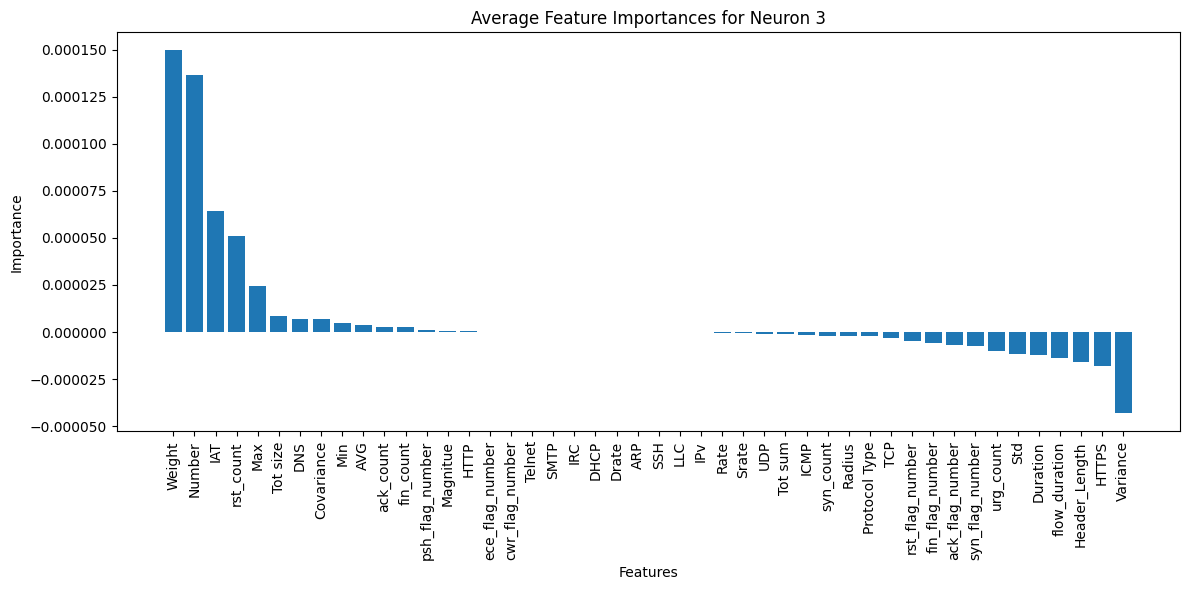

In [ ]:
featurenmaes=df_Binary.drop(columns='label').columns
sorted_feature_names, sorted_importances=visualize_importances(3,featurenmaes, np.mean(neuron_cond_vals_combined, axis=0), title="Average Feature Importances for Neuron 3")

In [ ]:
# Iterate through the DataLoader batches
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate neuron conductance for neuron 47 for each input in the batch
    neuron_cond_vals = neuron_cond.attribute(inputs, neuron_selector=47, target=0)
    neuron_cond_vals_list.append(neuron_cond_vals.detach().cpu().numpy())

# Concatenate the neuron conductance values along the batch dimension
neuron_cond_vals_combined = np.concatenate(neuron_cond_vals_list, axis=0)

Average Feature Importances for Neuron 47


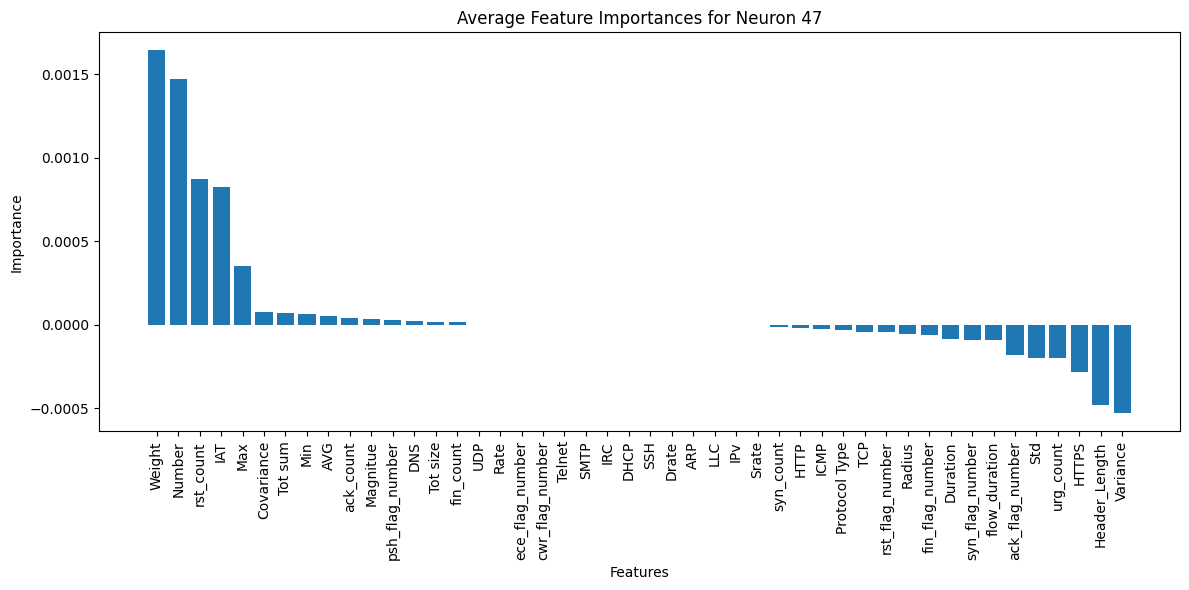

In [ ]:
sorted_feature_names, sorted_importances=visualize_importances(3,featurenmaes, np.mean(neuron_cond_vals_combined, axis=0), title="Average Feature Importances for Neuron 47")

### **Feature Engineering and Model Refinement - Captum**

In this phase, we leverage feature engineering techniques to enhance the model by removing columns with zero attributions identified through Captum. By retraining the model with this refined set of features, we aim to assess the impact on model effectiveness and potentially enhance its predictive performance.

In [ ]:
#Columns to be removed
columns_to_remove_binary=['ece_flag_number','cwr_flag_number','Telnet','SMTP','IRC','DHCP','LLC','ARP','IPv','SSH','Drate','AVG','Srate']

In [ ]:

df_Binary = df_Binary.drop(columns=columns_to_remove_binary)

In [ ]:
df_Binary.shape

(214963, 34)

Now we will retrain the model with new dataset

In [ ]:
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_binary_new = model_prep(df_Binary,'MLP_Binary')

Starting label encoding...
Before Label Encoding....
Attack    209777
Benign      5186
Name: label, dtype: int64
After Label Encoding....
0    209777
1      5186
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
after spliting the data:

training data length: 137576
test data length: 42993
validation data length: 34394
Train-test split completed.
....................................................
Performing standard scaling...
Standard scaling completed.
All preprocessing tasks completed successfully!


In [ ]:
X_train.shape

(137576, 33)

#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=1024
train_loader,test_loader,valid_loader,x_train_tensor_new = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)

#### 3.   Model - Training & Validation

MLP_Binary(
  (hidden_layer1): Linear(in_features=33, out_features=150, bias=True)
  (hidden_layer2): Linear(in_features=150, out_features=50, bias=True)
  (hidden_layer3): Linear(in_features=50, out_features=23, bias=True)
  (output_layer): Linear(in_features=23, out_features=1, bias=True)
  (dropout): Dropout(p=0.29, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch 1
train_loss : 0.13357273 val_loss : 0.03339719
train_accuracy : 96.37 val_accuracy : 98.59
Epoch 11
train_loss : 0.02396252 val_loss : 0.02419188
train_accuracy : 99.03 val_accuracy : 99.09
Epoch 21
train_loss : 0.02081429 val_loss : 0.02166799
train_accuracy : 99.19 val_accuracy : 99.27
Epoch 31
train_loss : 0.01636899 val_loss : 0.01573659
train_accuracy : 99.28 val_accuracy : 99.28
Epoch 41
train_loss : 0.01501030 val_loss : 0.01554887
train_accuracy : 99.32 val_accuracy : 99.27
Epoch 51
train_loss : 0.01446564 val_loss : 0.01511284
train_accuracy : 99.34 val_accuracy : 99.36
Epoch 61
train_loss : 0.01384

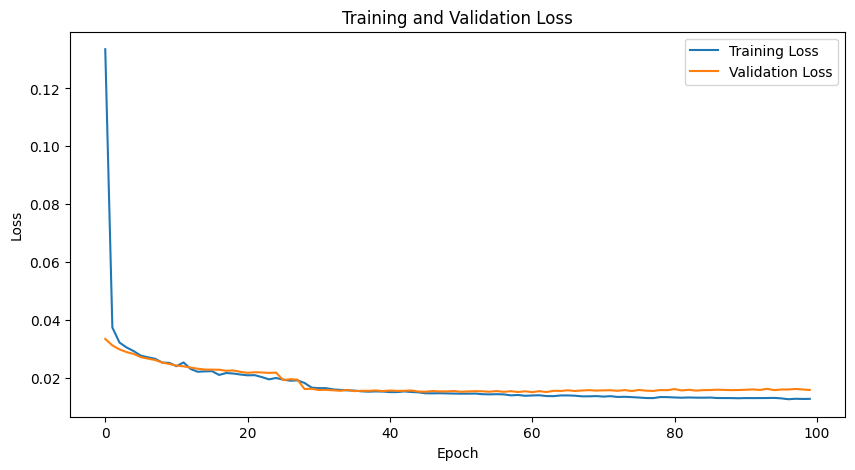

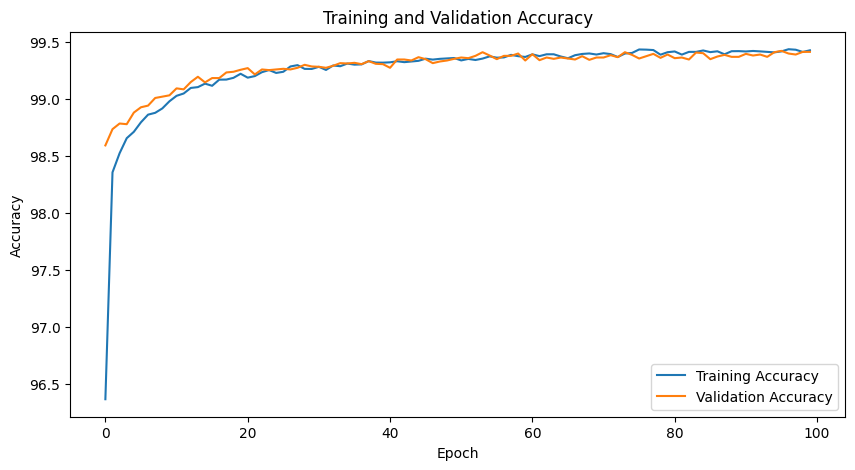

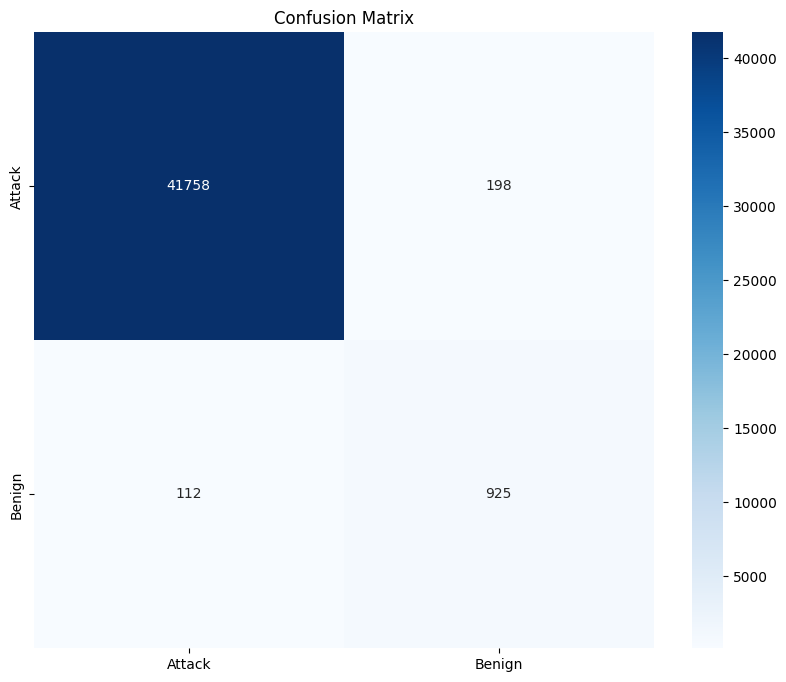

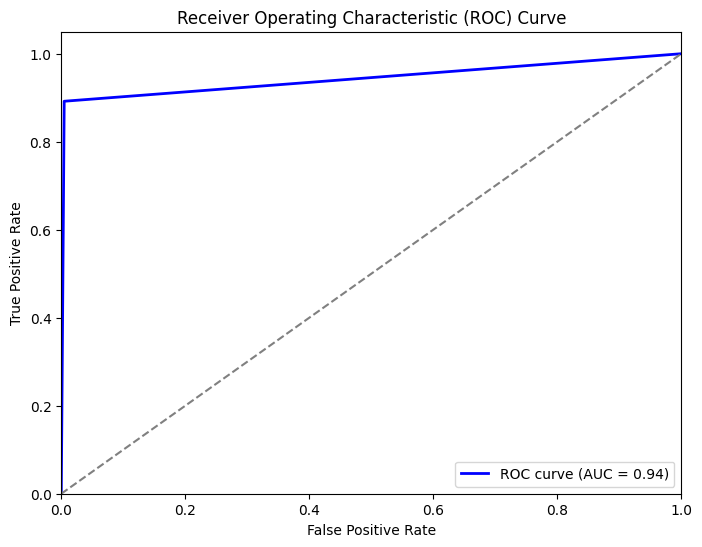

AUROC: 0.9436
CPU times: user 1min 4s, sys: 23.3 s, total: 1min 28s
Wall time: 2min 43s


In [ ]:
%%time
# Train MLP model for binary classification
input_features=33
learning_rate=0.001
loss=nn.BCELoss()
epochs= 100
model=model_training('MLP_Binary',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

We can see that there is improvement

Explainability

### 2.   **Explainability - SHAP**





SHAP (SHapley Additive exPlanations) is a versatile model interpretability library that utilizes Shapley values to explain the output of machine learning models, providing insights into the contribution of individual features to model predictions.


Both global explanations (overall feature importances across the entire dataset) and local explanations (Insights into model predictions for individual instances) will be cumputed using SHAP, leveraging the summary plot for a comprehensive overview of feature importances on a global scale, and employing detailed visualizations such as force plots, waterfall plots, and dependency plots for localized insights into individual predictions.

**Global Explanation**



For global explanation DeepExplainer,which is one of the explainer methods provided by the library will be used to gain comprehensive insights into feature importances and understand the overall behavior of the neural network across the entire dataset.

In [ ]:
%%time
import shap
shap.initjs()
model.to('cpu')
model.eval()
#Create Explainer
explainer= shap.DeepExplainer(model, x_train_tensor_binary[:1000])

CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 8.96 ms



For DeepExplainer in SHAP, calculating Shapley values on a representative dataset sample is recommended, as the background dataset is integrated over for feature attribution according to SHAP documentation.

In [ ]:
model

MLP_Binary(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=23, bias=True)
    (3): Linear(in_features=23, out_features=1, bias=True)
  )
)

In [ ]:
#Prepare X_test tensor
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
# compute SHAP values
shap_values = explainer.shap_values(x_test_tensor,check_additivity=False)

In [ ]:
featurenames=df_Binary.drop(columns='label').columns
len(featurenmaes)

46

In [ ]:
print(np.array(shap_values).shape)

(42993, 46)


**Visualize - Summary Plot**


The summary plot provides insights into the most influential features and quantifies their influence on the model, offering a global interpretation of the overall impact

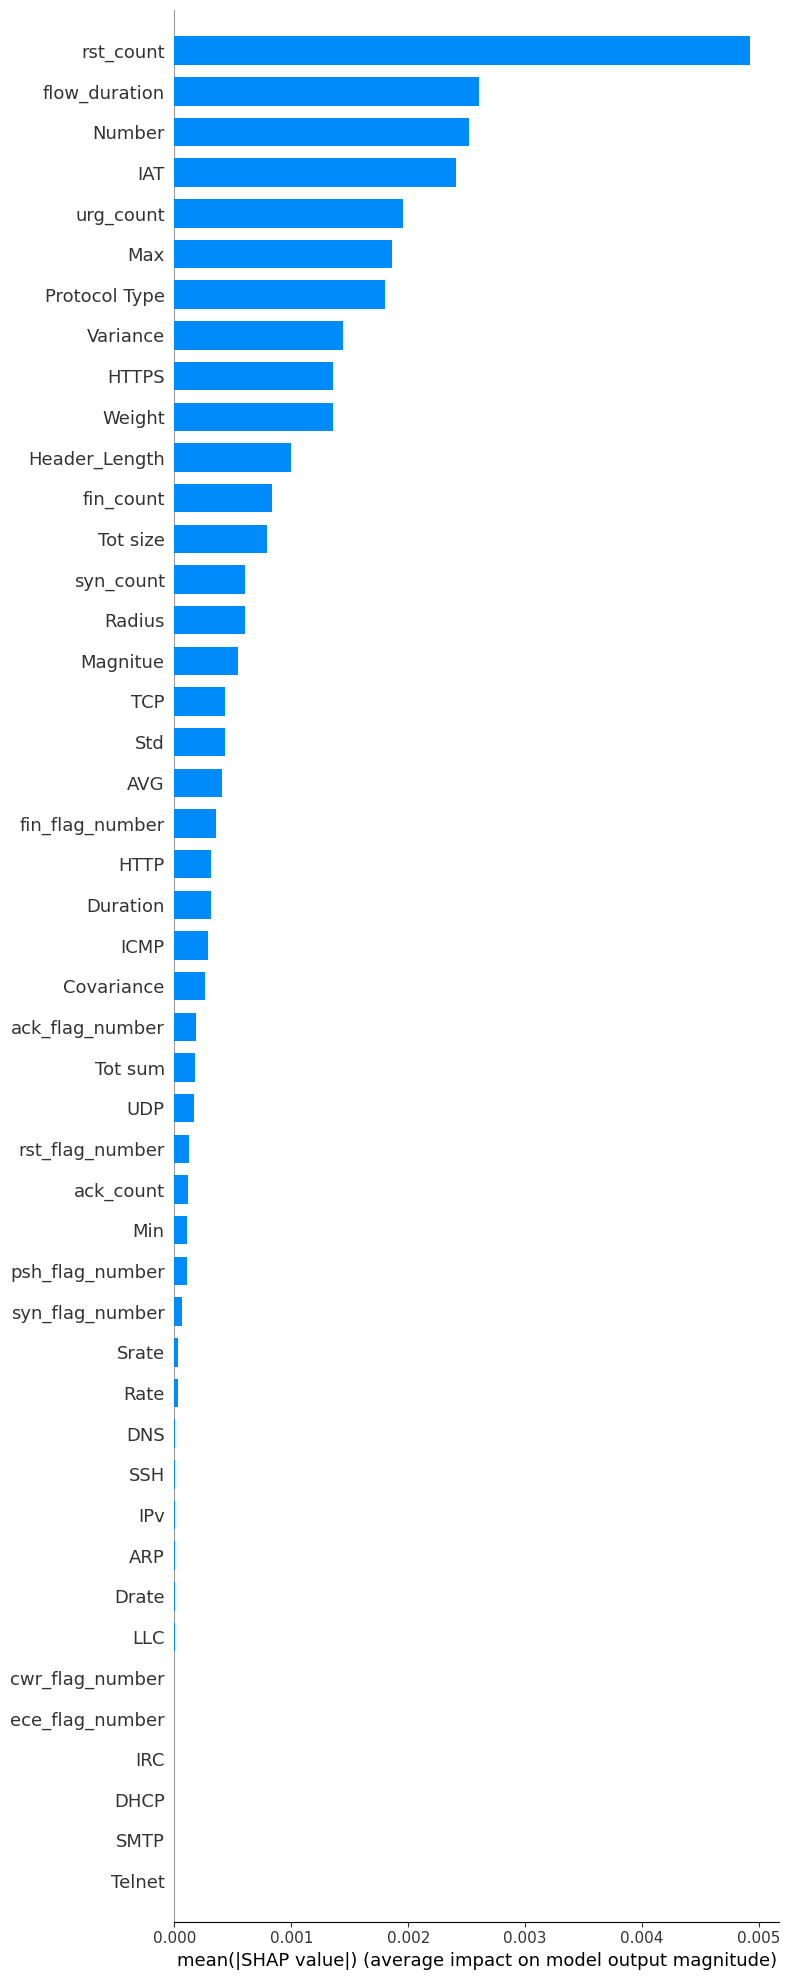

In [ ]:
import shap

shap.initjs()
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = featurenames,max_display=46,class_names=classname_binary)


Here  the features are arranged based on their impact on the prediction, with the order reflecting their influence from the most significant to the least.
Observations indicate that the feature "rst_count" holds the highest level of impact or influence in this context.

**Local Interpretation**

Here, I will showcase three visualizations illustrating explanations for a sample.

1.   Force Plot
2.   Waterfall Plot

1:  **Force Plot**

In [ ]:
# Evaluation on test set
model.eval()
model.to(device)
all_predictions ,all_targets =model_evaluation(model,'MLP_Binary',test_loader)

In [ ]:
# Convert predictions and targets to NumPy arrays
all_predictions_a = np.array(all_predictions)
all_targets_a = np.array(all_targets)

# Find indices where predictions do not match the targets
incorrect_indices = np.where(all_predictions_a != all_targets_a)[0]

# Display the indices of falsely predicted instances
#print("Indices of falsely predicted instances:", incorrect_indices)
print("\nTarget and Prediction for Incorrect Instances:")

data = {
    'Index': incorrect_indices,
    'Target': all_targets_a[incorrect_indices],
    'Prediction': all_predictions_a[incorrect_indices]
}

incorrect_df = pd.DataFrame(data)

# Display the DataFrame

display(incorrect_df.style.background_gradient())


Target and Prediction for Incorrect Instances:


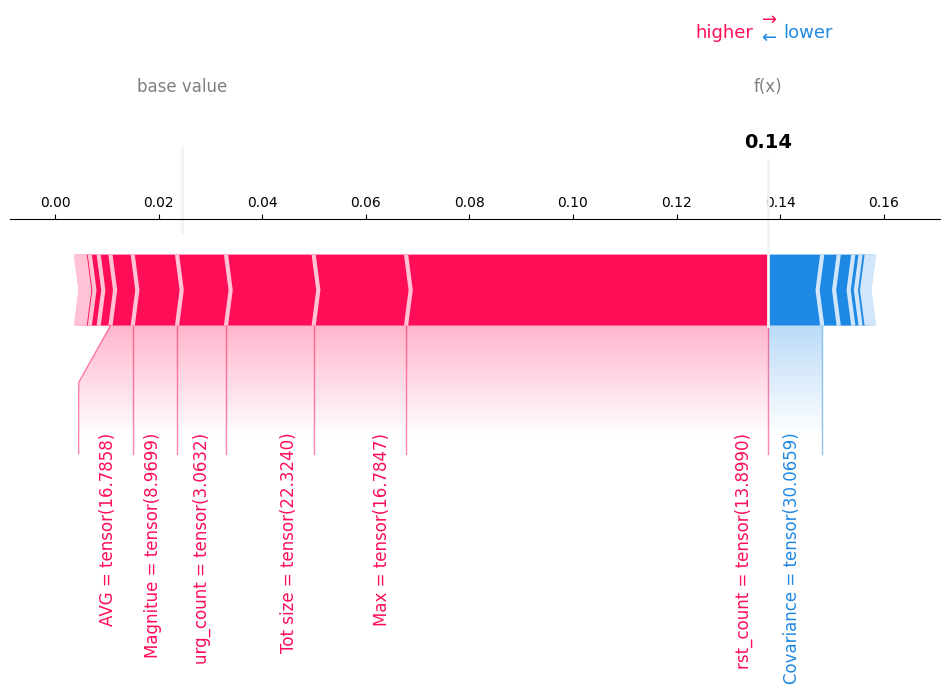

In [ ]:
shap.initjs()

# Choose a specific instance
instance_index = 10745
shap_values_instance_class = shap_values[instance_index,:]

# Display the force plot for the chosen instance and class
shap.force_plot(
    explainer.expected_value[0],
    shap_values_instance_class,
    x_test_tensor[instance_index],
    feature_names=featurenmaes,
    matplotlib=True,
    text_rotation=90,
    figsize=(12, 6)
)

**Waterfall plot**

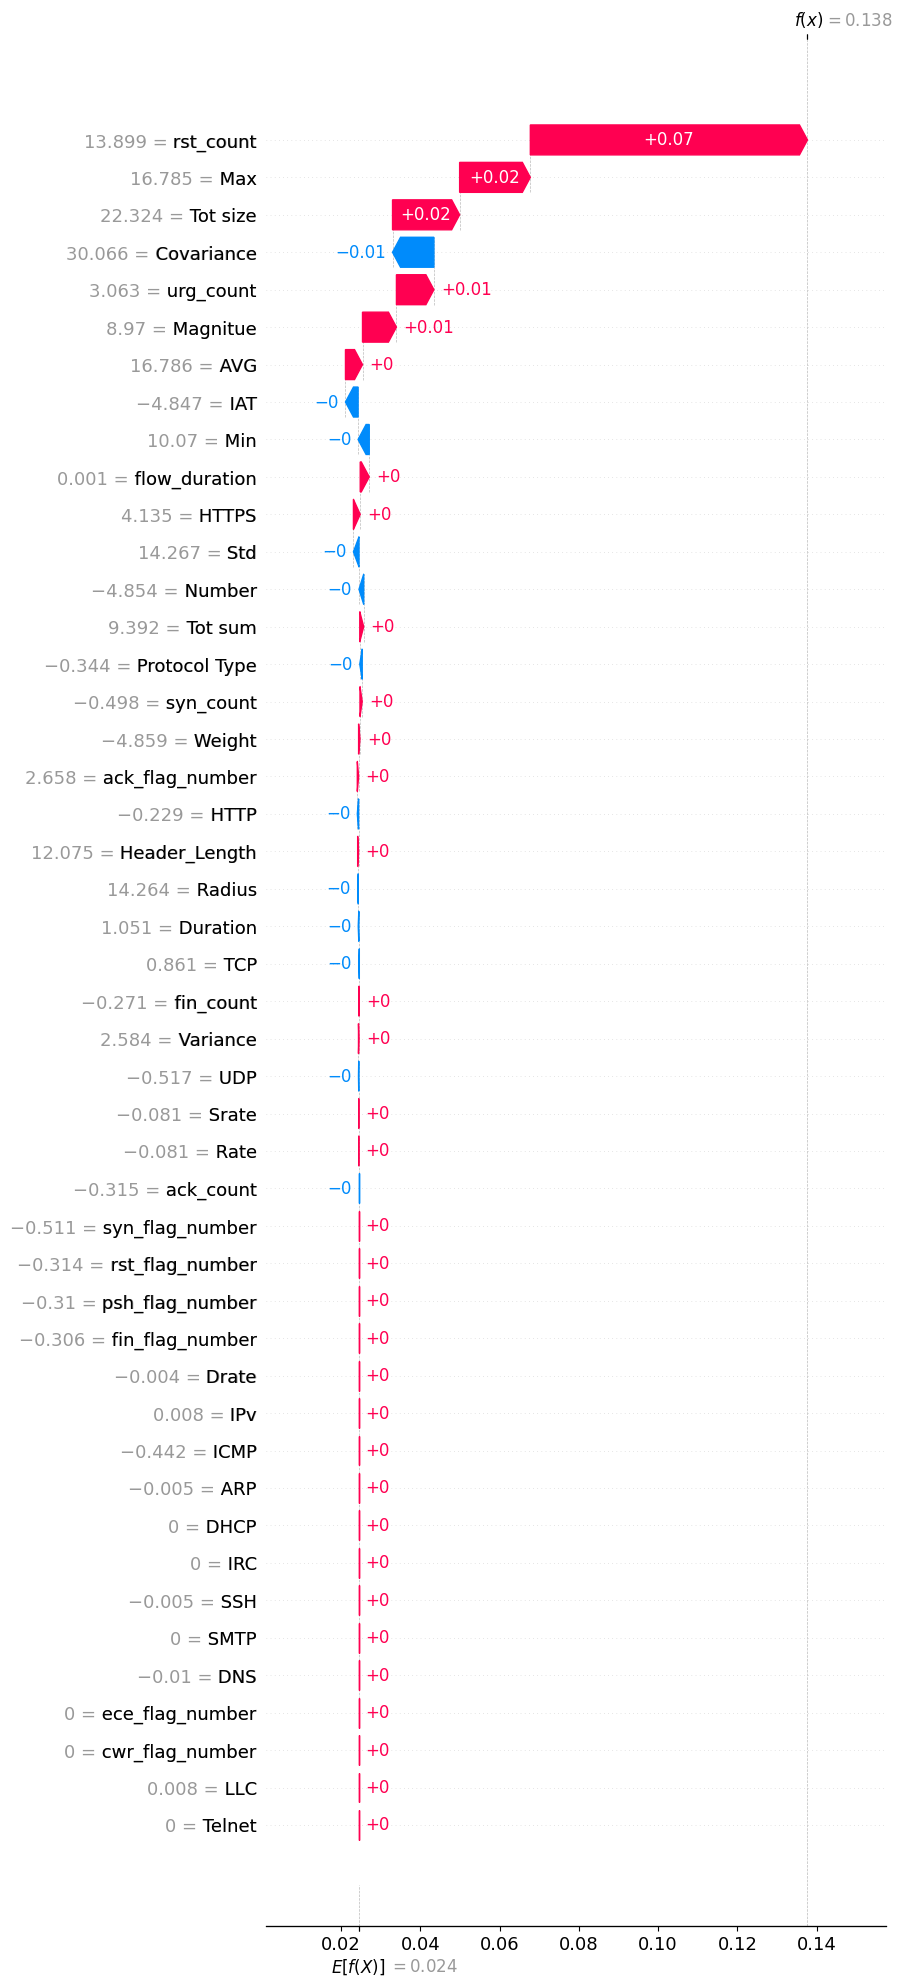

In [ ]:
row=10745

shap.waterfall_plot(shap.Explanation(values=shap_values[row],
                                         base_values=explainer.expected_value,
                                         data=X_test[row],
                                         feature_names = featurenmaes),max_display=46,show=True)


### **Feature Engineering and Model Refinement - SHAP**

In this phase, we leverage feature engineering techniques to enhance the model by removing columns with zero attributions identified through Captum. By retraining the model with this refined set of features, we aim to assess the impact on model effectiveness and potentially enhance its predictive performance.

In [ ]:
#Columns to be removed
columns_to_remove_binary=['Telnet','SMTP','DHCP','IRC','ece_flag_number','cwr_flag_number','LLC','ARP','IPv','SSH','Drate','DNS']

In [ ]:

df_Binary = df_Binary.drop(columns=columns_to_remove_binary)

In [ ]:
df_Binary.shape

(214963, 35)

Now we will retrain the model with new dataset

In [ ]:
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_binary_new = model_prep(df_Binary,'MLP_Binary')

Starting label encoding...
Before Label Encoding....
Attack    209777
Benign      5186
Name: label, dtype: int64
After Label Encoding....
0    209777
1      5186
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
after spliting the data:

training data length: 137576
test data length: 42993
validation data length: 34394
Train-test split completed.
....................................................
Performing standard scaling...
Standard scaling completed.
All preprocessing tasks completed successfully!


In [ ]:
X_train.shape

(137576, 34)

#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=1024
train_loader,test_loader,valid_loader,x_train_tensor_new = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)

#### 3.   Model - Training & Validation

MLP_Binary(
  (fc_layers): ModuleList(
    (0): Linear(in_features=34, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=23, bias=True)
    (3): Linear(in_features=23, out_features=1, bias=True)
  )
)
Epoch 1
train_loss : 0.10631976 val_loss : 0.02812544
train_accuracy : 97.68 val_accuracy : 98.51
Epoch 11
train_loss : 0.02123652 val_loss : 0.01861449
train_accuracy : 99.02 val_accuracy : 99.05
Epoch 21
train_loss : 0.01774719 val_loss : 0.01658882
train_accuracy : 99.23 val_accuracy : 99.20
Epoch 31
train_loss : 0.01653310 val_loss : 0.01571242
train_accuracy : 99.29 val_accuracy : 99.32
Epoch 41
train_loss : 0.01538257 val_loss : 0.01535095
train_accuracy : 99.34 val_accuracy : 99.31
Epoch 51
train_loss : 0.01498400 val_loss : 0.01524387
train_accuracy : 99.36 val_accuracy : 99.35
Epoch 61
train_loss : 0.01468278 val_loss : 0.01566723
train_accuracy : 99.36 val_accuracy : 99.35
Epoch 71
train_loss : 

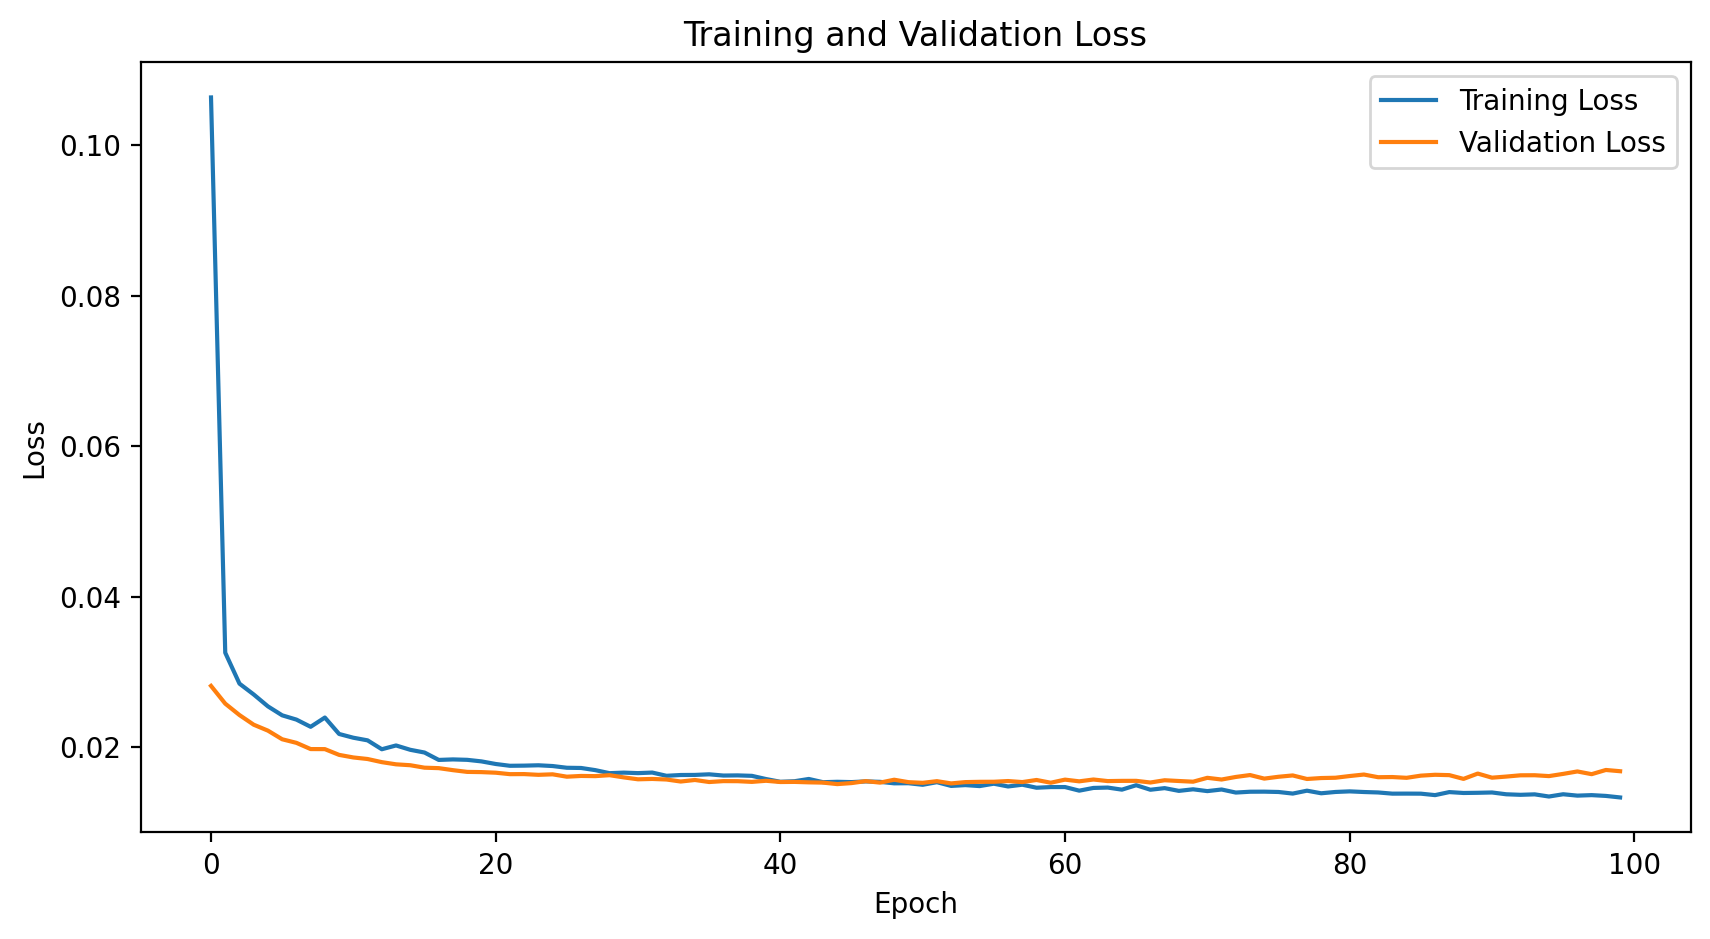

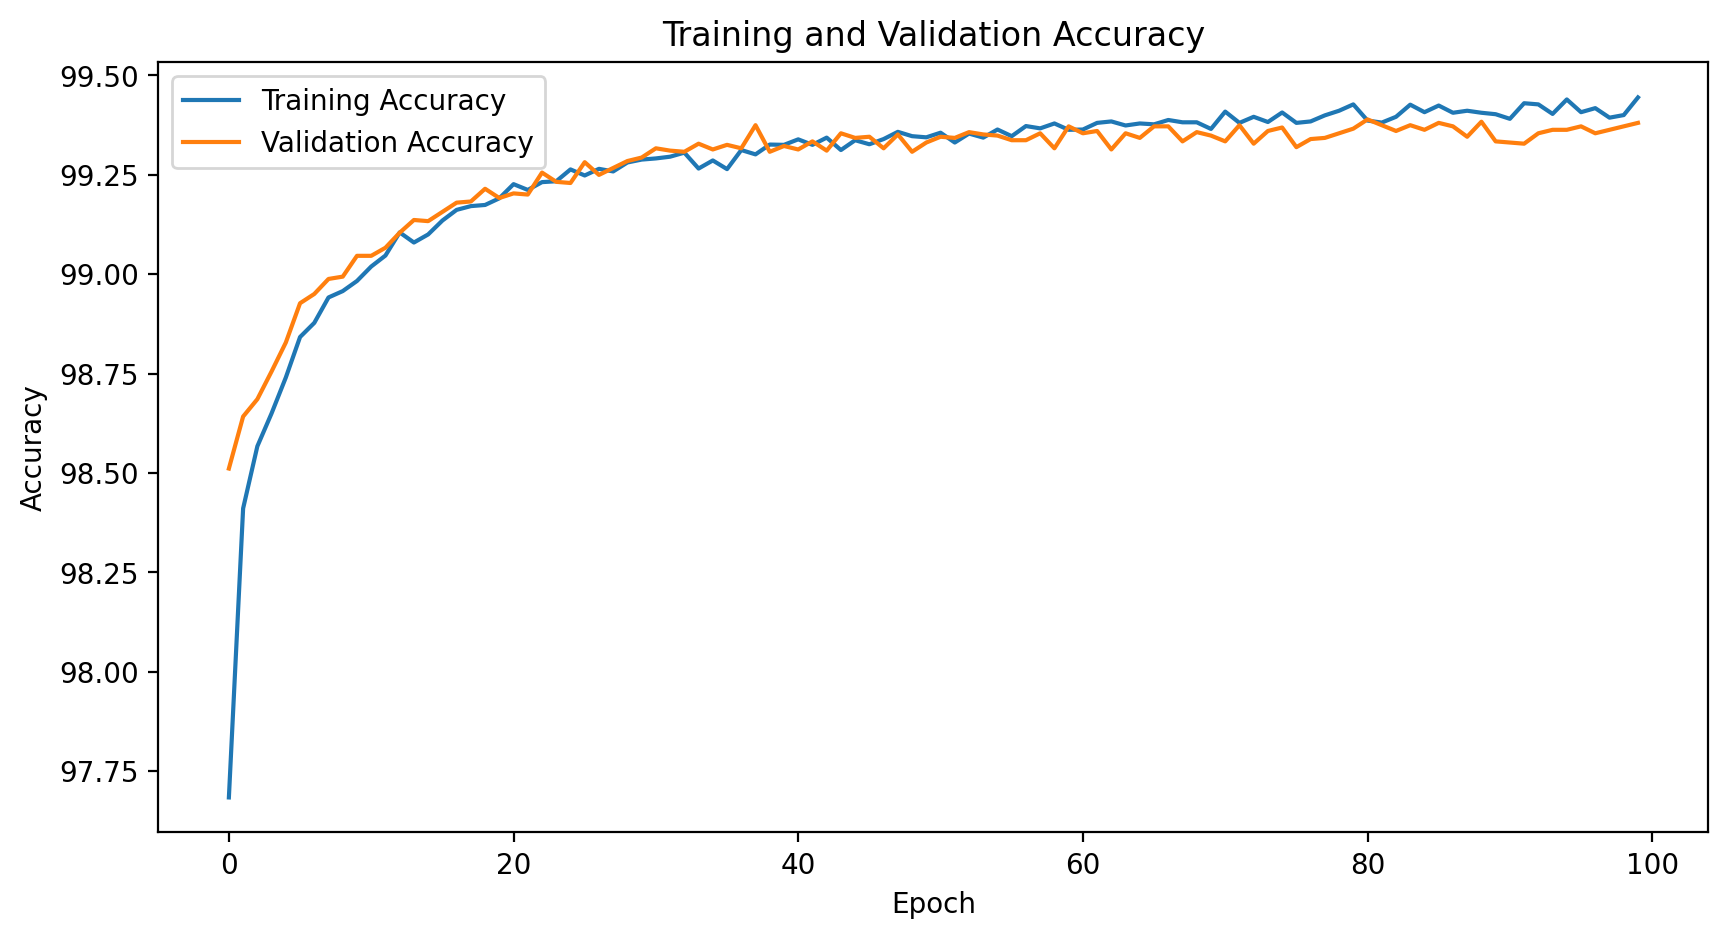

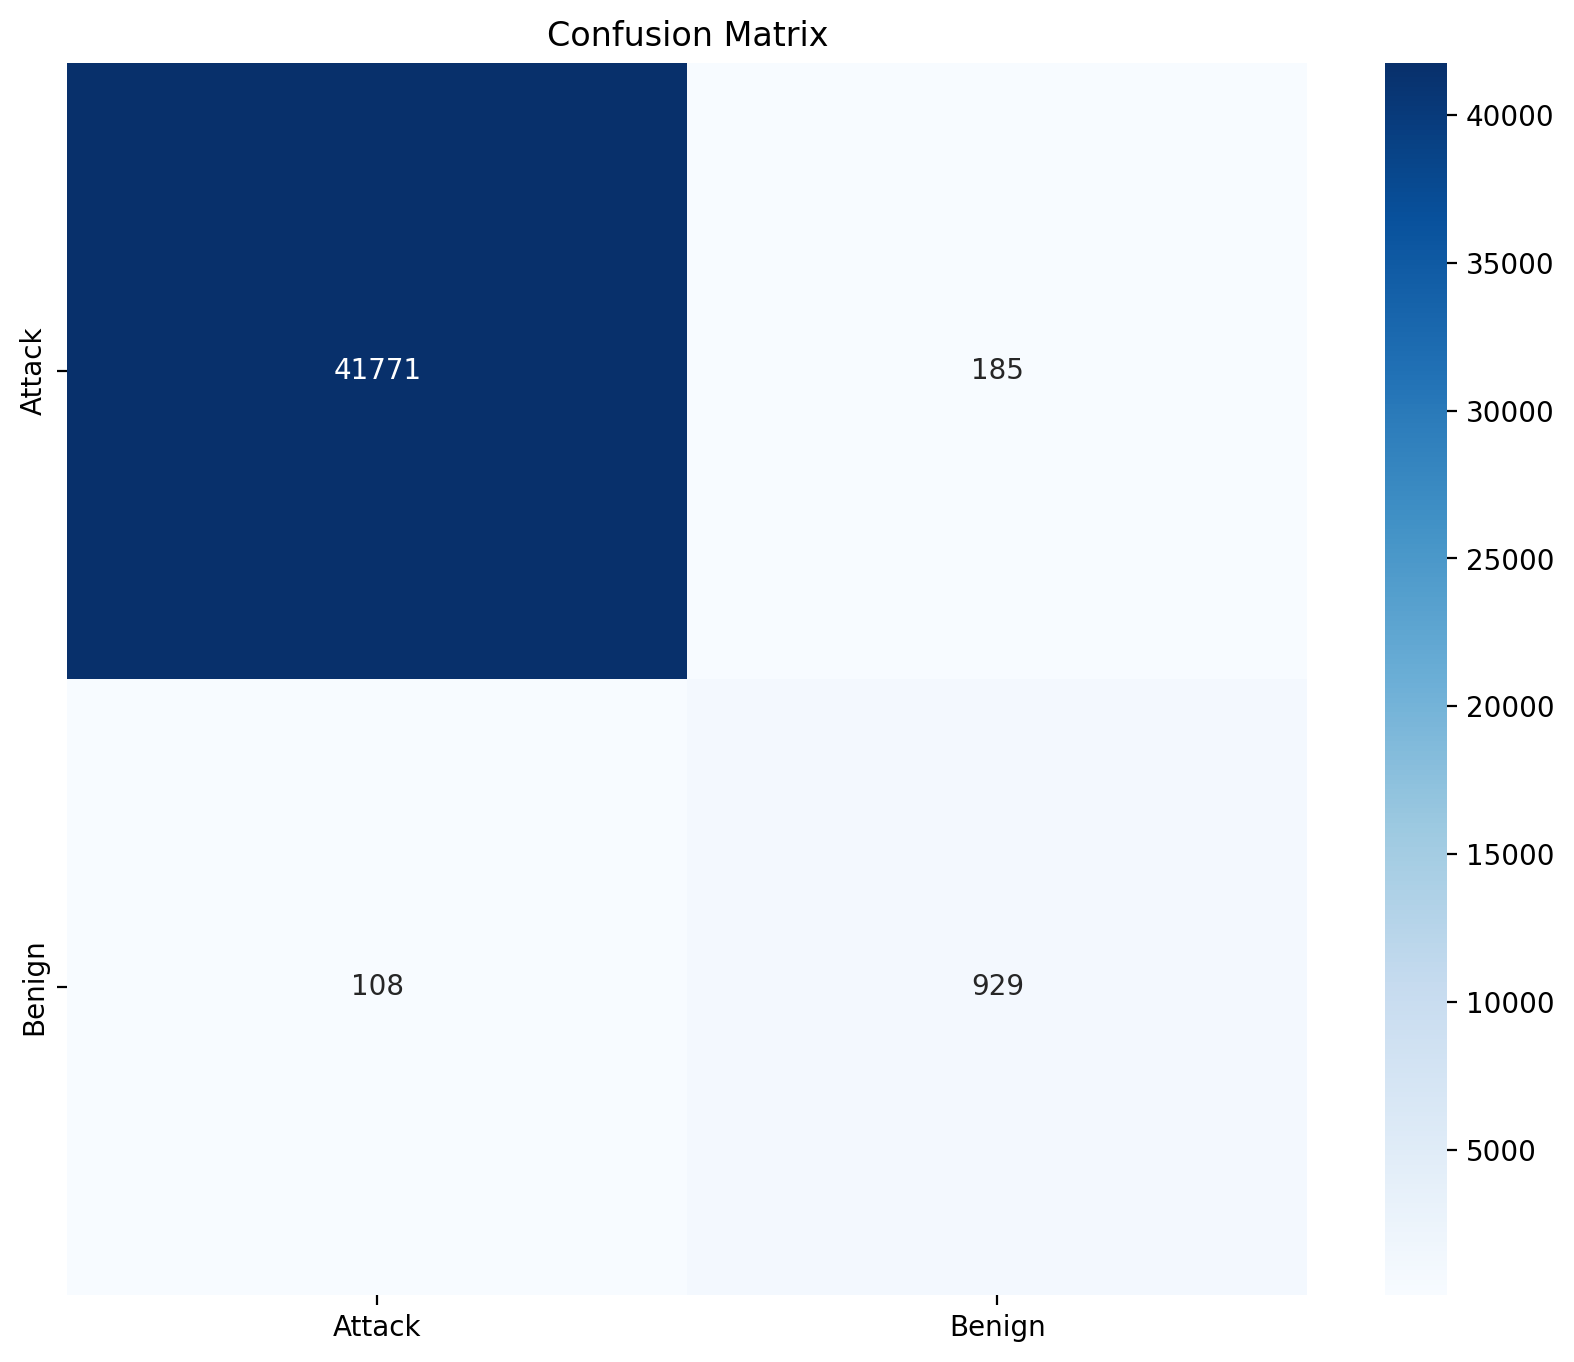

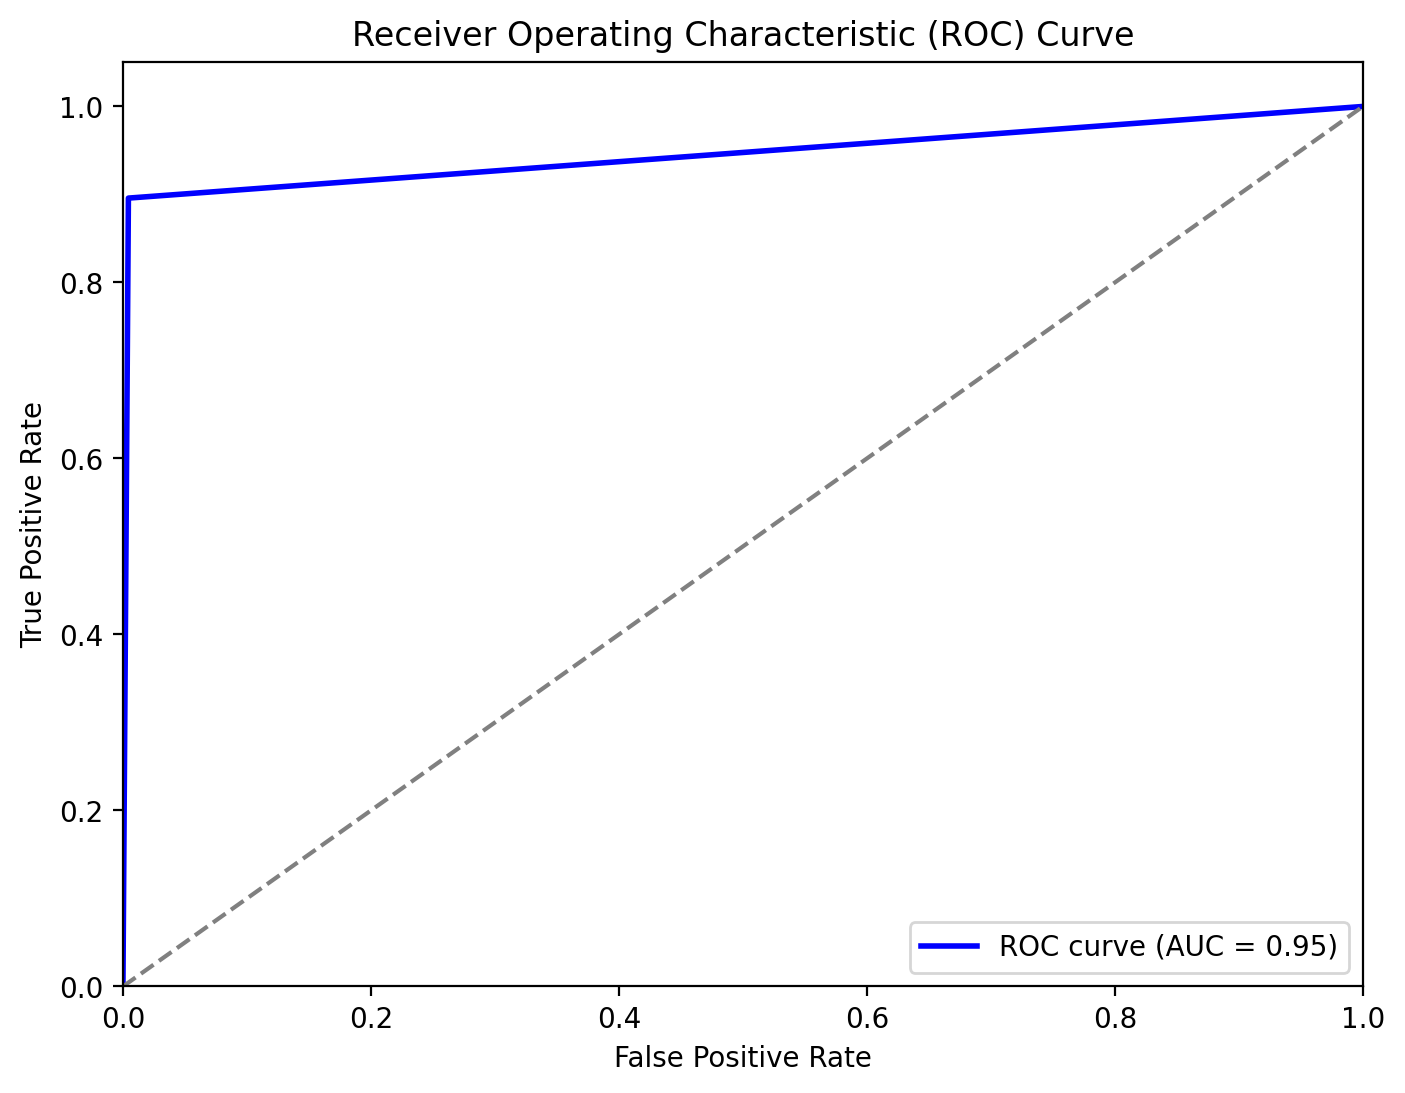

AUROC: 0.9457
CPU times: user 1min 13s, sys: 42.6 s, total: 1min 55s
Wall time: 2min 45s


In [ ]:
%%time
# Train MLP model for binary classification
input_features=34
learning_rate=0.001
loss=nn.BCELoss()
epochs= 100
model=model_training('MLP_Binary',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

We can see that there is improvement

### **Visualize**

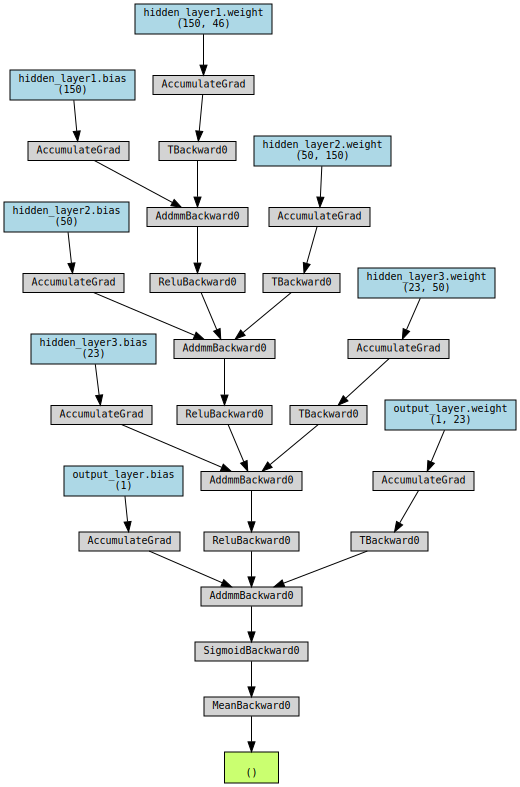

In [ ]:
model.to('cpu')
y = model(x_train_tensor)
make_dot(y.mean(), params=dict(model.named_parameters()))

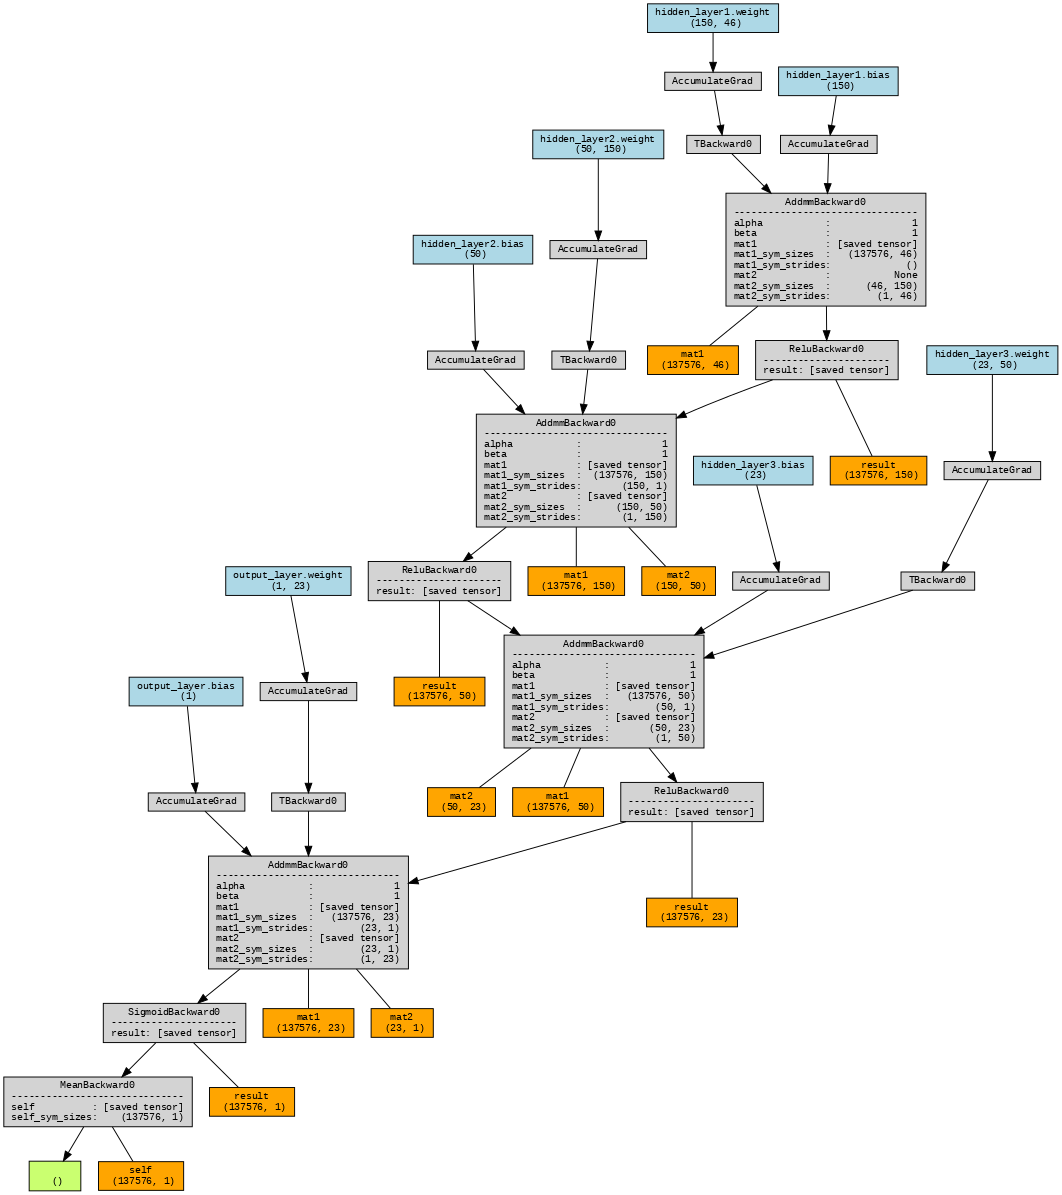

In [ ]:
from IPython.display import Image, display
dot =make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.format = 'png'
dot.render(filename='computation_graph', directory=modelFilePath, cleanup=True, format='png')

# Display the saved image
display(Image(filename=modelFilePath+'/computation_graph.png'))

### **Save Model**

In [ ]:
# Save a the model to a pickle file
saved_file = save_to_pickle(model, 'model_MLP_Binary.pkl', modelFilePath)

## **Multi Layer Perceptron - Multi-Class Classification**

In this section, we construct a Multilayer Perceptron (MLP) model for multi-class classification.

The multi-class classification Multi-Layer Perceptron (MLP) model consists of an input layer with 46 features, three hidden layers with 150, 50, and 23 neurons, respectively, followed by ReLU activation, and an output layer with a single neuron and Sigmoid activation. Dropout regularization with a probability of 0.0657 is applied to enhance generalization during training.

As the dataset poses a challenge with high class imbalance across 8 attack categories, we are implementing oversampling techniques specifically targeting the minority classes

In [ ]:
class MLP_MultiClas_Captum(nn.Module):
    def __init__(self, num_input_features,dropout_prob, num_hidden_neuron1):
        super(MLP_MultiClass, self).__init__()
        self.hidden_layer1 = nn.Linear(num_input_features, num_hidden_neuron1)
        self.output_layer  = nn.Linear(num_hidden_neuron1, 8)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # Initialize
        nn.init.kaiming_normal_(self.hidden_layer1.weight, nonlinearity='relu')
        nn.init.zeros_(self.hidden_layer1.bias)

    def forward(self, X):

        hidden_res1 = self.relu(self.hidden_layer1(X))
        hidden_res1 = self.dropout(hidden_res1)

        output = self.softmax(self.output_layer(hidden_res1))
        return output

class MLP_MultiClass(nn.Module):

    def __init__(self,num_input_features, num_fc_layers, num_neurons, drop_fc1):

        super(MLP_MultiClass, self).__init__()                     # Initialize parent class
        self.fc_layers = nn.ModuleList()                # List with the FC layers
        self.p1 = drop_fc1                              # Dropout ratio for FC1

        # Define the fully connected layers
        in_features = num_input_features                               # Input features for the dataset
        for i in range(num_fc_layers - 1):
            out_features = num_neurons[i]
            self.fc_layers.append(nn.Linear(in_features, out_features))  # Add FC layer
            in_features = out_features                                # Update input features for next layer

        # Output layer
        self.fc_layers.append(nn.Linear(out_features, 8))  # 8 output classes for intrusion detection

        # Initialize weights with the He initialization
        for layer in self.fc_layers[:-1]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):

        for i, fc_i in enumerate(self.fc_layers[:-1]):  # For each fully connected layer except the last one
            x = F.relu(fc_i(x))                         # Fully connected layer followed by ReLU
            if i <= len(self.fc_layers) - 2:            # Apply dropout except for the last layer
               x = F.dropout(x, p=self.p1, training=self.training)

        x = self.fc_layers[-1](x)                      # Final fully connected layer (output layer)

        return F.softmax(x, dim=1)                 # softmax(x)


Here is the code implementation for the model development, where we define the architecture, set hyperparameters, and conduct the training and validation process for the multi-class classification Multilayer Perceptron (MLP) model.

### **Optuna- Hyper parameter tuning**

Here we'll leverage Optuna for hyperparameter optimization, dynamically searching for the most effective combination of model settings, thereby significantly enhancing our model's performance

In [ ]:
# Model preparation
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_multiclass = model_prep(df,'MLP_MultiClass')

Starting label encoding...
Before Label Encoding....
DDoS          156346
DoS            37175
Mirai          12220
Benign          5186
Spoofing        2259
Recon           1612
Web              115
BruteForce        50
Name: label, dtype: int64
After Label Encoding....
2    156346
3     37175
4     12220
0      5186
6      2259
5      1612
7       115
1        50
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
Before sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 115 instances
1: 50 instances
After sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 1500 instances
1: 1500 instances
Finished Sampling

after spliting the data:

training data length: 139390
te

In [ ]:
%%time
class MLP(nn.Module):
    def __init__(self, num_fc_layers, num_neurons, drop_fc1):

        super(MLP, self).__init__()
        self.fc_layers = nn.ModuleList()
        self.p1 = drop_fc1                              # Dropout ratio for FC1


        in_features = 46                                # Input features for the dataset
        out_features = 8                                # Output classes for intrusion detection

        if num_fc_layers == 1:
            self.fc_layers.append(nn.Linear(in_features, num_neurons[0]))  # Hidden FC layer
            in_features = num_neurons[0]                                # Update input features for next layer
        else:
            for i in range(num_fc_layers - 1):
                out = num_neurons[i]
                self.fc_layers.append(nn.Linear(in_features, out))  # Hidden FC layer
                in_features = out                                 # Update input features for next layer

        # Output layer
        self.fc_layers.append(nn.Linear(in_features, out_features))

        # Initialize weights with the He initialization
        for layer in self.fc_layers[:-1]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):

        x = torch.tensor(x, dtype=torch.float)
        for i, fc_i in enumerate(self.fc_layers[:-1]):  # For each fully connected layer except the last one
            x = F.relu(fc_i(x))                         # Fully connected layer followed by ReLU
            if i <= len(self.fc_layers) - 2:            # Apply dropout except for the last layer
                x = F.dropout(x, p=self.p1, training=self.training)

        x = self.fc_layers[-1](x)                      # Final fully connected layer (output layer)

        return F.softmax(x, dim=1)                 # softmax(x)

def objective(trial):

      # Define range of values to be tested for the hyperparameters
      num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)  # Number of hidden layers
      hidden_layer_neurons = [trial.suggest_int(f'n_neurons_l{i}', 10, 500) for i in range(num_hidden_layers)]  # Neurons in each hidden layer
      learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)  # Learning rate
      dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)  # Dropout probability

      # dataloaders
      batch_size = trial.suggest_int('batch_size', 512, 5000, log=True)
      num_workers = 0

      # SHUFFLE training data
      train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,num_workers=num_workers)
      test_loader =  DataLoader(test_data,  shuffle=False,batch_size=batch_size,num_workers=num_workers)
      valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size,num_workers=num_workers)

      model=MLP(num_hidden_layers,hidden_layer_neurons,dropout_prob).to(device)
      #moving to gpu
      model.to(device)

      print(model)

       # Select optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

      # Training Loop

      epochs = 100
      valid_loss_min = np.Inf
      # train for some number of epochs

      for epoch in range(epochs):
          model.train()
          running_loss = 0.0
          correct_train = 0
          total_train = 0
          loss=0.0
          for inputs, labels in train_loader:

              inputs, labels = inputs.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = model(inputs)

              # calculate the loss and perform backprop
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              _, predicted = torch.max(outputs, 1)
              total_train += labels.size(0)
              correct_train += (predicted == labels).sum().item()

          # Calculate average training loss for the epoch
          epoch_train_loss = running_loss / len(train_loader)
          epoch_train_accuracy = (correct_train / total_train) * 100 if total_train > 0 else 0.0

          model.eval()
          correct_val = 0
          total_val = 0
          val_running_loss = 0.0
          val_loss=0.0
          for inputs, labels in valid_loader:

                  inputs, labels = inputs.to(device), labels.to(device)

                  outputs = model(inputs)
                  val_loss = criterion(outputs, labels)
                  val_running_loss += val_loss.item()

                  _, predicted = torch.max(outputs, 1)
                  total_val += labels.size(0)
                  correct_val += (predicted == labels).sum().item()

          # Calculate average validation loss for the epoch
          epoch_val_loss = val_running_loss / len(valid_loader)
          epoch_val_accuracy = (correct_val / total_val) * 100 if total_val > 0 else 0.0

          trial.report(epoch_val_loss, epoch)
          trial.set_user_attr('train_loss', epoch_train_loss)
          trial.set_user_attr('val_loss', epoch_val_loss)
          trial.set_user_attr('train_accuracy', epoch_train_accuracy)
          trial.set_user_attr('val_accuracy', epoch_val_accuracy)

          if trial.should_prune():
            raise optuna.TrialPruned()

      print('train_loss', epoch_train_loss)
      print('val_loss', epoch_val_loss)
      print('train_accuracy', epoch_train_accuracy)
      print('val_accuracy', epoch_val_accuracy)

      return epoch_train_loss  # Return validation loss for Optuna optimization

## MLP

# create Tensor datasets ,
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_data =  TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
valid_data = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))

# Optuna study setup
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Change n_trials to desired number of trials

# Get best parameters and best value
best_params = study.best_params
best_value = study.best_value

print(f"Best parameters: {best_params}")
print(f"Best value: {best_value}")

# Accessing user attributes for best trial
best_trial = study.best_trial
best_train_loss = best_trial.user_attrs['train_loss']
best_val_loss = best_trial.user_attrs['val_loss']
best_train_accuracy = best_trial.user_attrs['train_accuracy']
best_val_accuracy = best_trial.user_attrs['val_accuracy']

print(f"Best Trial Train Loss: {best_train_loss}")
print(f"Best Trial Validation Loss: {best_val_loss}")
print(f"Best Trial Train Accuracy: {best_train_accuracy}")
print(f"Best Trial Validation Accuracy: {best_val_accuracy}")

[I 2024-01-13 14:30:46,420] A new study created in memory with name: no-name-2910ba2d-fbee-430e-8d1b-5829c353b0f4


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=318, bias=True)
    (1): Linear(in_features=318, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:33:27,023] Trial 0 finished with value: 1.4612740991162319 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 318, 'learning_rate': 2.1890177762616535e-05, 'dropout_prob': 0.4168097163980863, 'batch_size': 1358}. Best is trial 0 with value: 1.4612740991162319.


train_loss 1.4612740991162319
val_loss 1.4595927825340858
train_accuracy 81.2874338547421
val_accuracy 81.48805024132116
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=65, bias=True)
    (2): Linear(in_features=65, out_features=314, bias=True)
    (3): Linear(in_features=314, out_features=354, bias=True)
    (4): Linear(in_features=354, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:36:44,690] Trial 1 finished with value: 1.546758064856896 and parameters: {'num_hidden_layers': 5, 'n_neurons_l0': 10, 'n_neurons_l1': 65, 'n_neurons_l2': 314, 'n_neurons_l3': 354, 'n_neurons_l4': 420, 'learning_rate': 0.08425091446471675, 'dropout_prob': 0.35286963170543423, 'batch_size': 2672}. Best is trial 0 with value: 1.4612740991162319.


train_loss 1.546758064856896
val_loss 1.5467509489793043
train_accuracy 72.73143571553177
val_accuracy 72.73070884456591
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=41, bias=True)
    (1): Linear(in_features=41, out_features=356, bias=True)
    (2): Linear(in_features=356, out_features=175, bias=True)
    (3): Linear(in_features=175, out_features=439, bias=True)
    (4): Linear(in_features=439, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:39:45,728] Trial 2 finished with value: 1.5465844965460311 and parameters: {'num_hidden_layers': 5, 'n_neurons_l0': 41, 'n_neurons_l1': 356, 'n_neurons_l2': 175, 'n_neurons_l3': 439, 'n_neurons_l4': 106, 'learning_rate': 0.03219066764256312, 'dropout_prob': 0.38465157623585994, 'batch_size': 694}. Best is trial 0 with value: 1.4612740991162319.


train_loss 1.5465844965460311
val_loss 1.5469793939590455
train_accuracy 72.73143571553177
val_accuracy 72.73070884456591
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:42:30,063] Trial 3 finished with value: 1.3310379819436506 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 30, 'learning_rate': 0.00587648700900766, 'dropout_prob': 0.3352792017889326, 'batch_size': 696}. Best is trial 3 with value: 1.3310379819436506.


train_loss 1.3310379819436506
val_loss 1.31646324634552
train_accuracy 94.61897423969296
val_accuracy 96.25516078385765
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=329, bias=True)
    (1): Linear(in_features=329, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:45:11,471] Trial 4 finished with value: 1.4581358180257487 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 329, 'learning_rate': 0.015421369344747395, 'dropout_prob': 0.43549992042346375, 'batch_size': 680}. Best is trial 3 with value: 1.3310379819436506.


train_loss 1.4581358180257487
val_loss 1.455015042248894
train_accuracy 81.57818224108856
val_accuracy 81.91545036925045
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=271, bias=True)
    (1): Linear(in_features=271, out_features=387, bias=True)
    (2): Linear(in_features=387, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:45:12,832] Trial 5 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=391, bias=True)
    (1): Linear(in_features=391, out_features=118, bias=True)
    (2): Linear(in_features=118, out_features=44, bias=True)
    (3): Linear(in_features=44, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:45:32,788] Trial 6 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=153, bias=True)
    (1): Linear(in_features=153, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:48:34,276] Trial 7 finished with value: 1.4327050412910571 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 153, 'learning_rate': 0.0006317901182447918, 'dropout_prob': 0.3822176087064148, 'batch_size': 2020}. Best is trial 3 with value: 1.3310379819436506.


train_loss 1.4327050412910571
val_loss 1.4308671686384413
train_accuracy 84.2479792987149
val_accuracy 84.68046752340524
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=98, bias=True)
    (1): Linear(in_features=98, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:48:36,684] Trial 8 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=69, bias=True)
    (1): Linear(in_features=69, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:51:31,834] Trial 9 finished with value: 1.4512355327606201 and parameters: {'num_hidden_layers': 3, 'n_neurons_l0': 69, 'n_neurons_l1': 10, 'n_neurons_l2': 108, 'learning_rate': 0.00037488889209653557, 'dropout_prob': 0.4025402139138174, 'batch_size': 588}. Best is trial 3 with value: 1.3310379819436506.


train_loss 1.4512355327606201
val_loss 1.4404844752812789
train_accuracy 82.30868756178403
val_accuracy 83.36628481711926
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=188, bias=True)
    (1): Linear(in_features=188, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:51:40,047] Trial 10 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=166, bias=True)
    (1): Linear(in_features=166, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:51:42,482] Trial 11 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=169, bias=True)
    (1): Linear(in_features=169, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:54:24,249] Trial 12 finished with value: 1.4221634682147735 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 169, 'n_neurons_l1': 230, 'learning_rate': 0.0006509254985240134, 'dropout_prob': 0.30487770412703386, 'batch_size': 1111}. Best is trial 3 with value: 1.3310379819436506.


train_loss 1.4221634682147735
val_loss 1.4190358500326834
train_accuracy 85.50110484386812
val_accuracy 85.82601616561028
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=218, bias=True)
    (1): Linear(in_features=218, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:54:25,745] Trial 13 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=111, bias=True)
    (1): Linear(in_features=111, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:57:07,792] Trial 14 finished with value: 1.2941439159928936 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 111, 'n_neurons_l1': 304, 'learning_rate': 0.002229612982675816, 'dropout_prob': 0.3131445563856134, 'batch_size': 947}. Best is trial 14 with value: 1.2941439159928936.


train_loss 1.2941439159928936
val_loss 1.2935728930138253
train_accuracy 98.07960690818166
val_accuracy 98.06943071465953
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=483, bias=True)
    (1): Linear(in_features=483, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:59:46,101] Trial 15 finished with value: 1.2948282519018794 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 483, 'n_neurons_l1': 368, 'learning_rate': 0.003182579797326133, 'dropout_prob': 0.1946289200619541, 'batch_size': 831}. Best is trial 14 with value: 1.2941439159928936.


train_loss 1.2948282519018794
val_loss 1.2946984001568385
train_accuracy 97.94440890853056
val_accuracy 97.9327789730767
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=498, bias=True)
    (1): Linear(in_features=498, out_features=342, bias=True)
    (2): Linear(in_features=342, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:59:48,694] Trial 16 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=493, bias=True)
    (1): Linear(in_features=493, out_features=450, bias=True)
    (2): Linear(in_features=450, out_features=471, bias=True)
    (3): Linear(in_features=471, out_features=8, bias=True)
  )
)


[I 2024-01-13 14:59:57,457] Trial 17 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=417, bias=True)
    (1): Linear(in_features=417, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:00:06,064] Trial 18 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=125, bias=True)
    (1): Linear(in_features=125, out_features=289, bias=True)
    (2): Linear(in_features=289, out_features=382, bias=True)
    (3): Linear(in_features=382, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:00:07,586] Trial 19 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=268, bias=True)
    (1): Linear(in_features=268, out_features=412, bias=True)
    (2): Linear(in_features=412, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:00:09,993] Trial 20 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=84, bias=True)
    (1): Linear(in_features=84, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:03:03,183] Trial 21 finished with value: 1.3016293269283368 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 84, 'learning_rate': 0.003965229612030921, 'dropout_prob': 0.3291848865308228, 'batch_size': 521}. Best is trial 14 with value: 1.2941439159928936.


train_loss 1.3016293269283368
val_loss 1.2936266447181133
train_accuracy 97.57951968366577
val_accuracy 98.10722800488458
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=71, bias=True)
    (1): Linear(in_features=71, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:05:51,746] Trial 22 finished with value: 1.2940008438323154 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 71, 'n_neurons_l1': 164, 'learning_rate': 0.0038286825155885926, 'dropout_prob': 0.26030030396293163, 'batch_size': 570}. Best is trial 22 with value: 1.2940008438323154.


train_loss 1.2940008438323154
val_loss 1.2928029806887518
train_accuracy 98.05489329534221
val_accuracy 98.15665523056347
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=215, bias=True)
    (1): Linear(in_features=215, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:06:00,049] Trial 23 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=106, bias=True)
    (1): Linear(in_features=106, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:08:43,168] Trial 24 finished with value: 1.2966569389095743 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 106, 'n_neurons_l1': 278, 'learning_rate': 0.012255301623834704, 'dropout_prob': 0.2565057481209996, 'batch_size': 1057}. Best is trial 22 with value: 1.2940008438323154.


train_loss 1.2966569389095743
val_loss 1.2940117770975286
train_accuracy 97.76632552189335
val_accuracy 98.01418852125371
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=434, bias=True)
    (1): Linear(in_features=434, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:26,684] Trial 25 finished with value: 1.2944212455183404 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 434, 'n_neurons_l1': 169, 'learning_rate': 0.0011140379372745523, 'dropout_prob': 0.1662798387665544, 'batch_size': 629}. Best is trial 22 with value: 1.2940008438323154.


train_loss 1.2944212455183404
val_loss 1.2950150056318803
train_accuracy 97.98075245682386
val_accuracy 97.90951910216899
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=415, bias=True)
    (1): Linear(in_features=415, out_features=165, bias=True)
    (2): Linear(in_features=165, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:29,909] Trial 26 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=59, bias=True)
    (1): Linear(in_features=59, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:31,502] Trial 27 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=338, bias=True)
    (1): Linear(in_features=338, out_features=192, bias=True)
    (2): Linear(in_features=192, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:34,202] Trial 28 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=124, bias=True)
    (1): Linear(in_features=124, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:35,519] Trial 29 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=301, bias=True)
    (1): Linear(in_features=301, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:38,062] Trial 30 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=456, bias=True)
    (1): Linear(in_features=456, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:42,090] Trial 31 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=463, bias=True)
    (1): Linear(in_features=463, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:43,490] Trial 32 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=380, bias=True)
    (1): Linear(in_features=380, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:44,943] Trial 33 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=23, bias=True)
    (1): Linear(in_features=23, out_features=389, bias=True)
    (2): Linear(in_features=389, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:46,493] Trial 34 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=454, bias=True)
    (1): Linear(in_features=454, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:50,590] Trial 35 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=357, bias=True)
    (1): Linear(in_features=357, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:52,051] Trial 36 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=294, bias=True)
    (1): Linear(in_features=294, out_features=248, bias=True)
    (2): Linear(in_features=248, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:53,530] Trial 37 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=44, bias=True)
    (1): Linear(in_features=44, out_features=174, bias=True)
    (2): Linear(in_features=174, out_features=424, bias=True)
    (3): Linear(in_features=424, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:55,369] Trial 38 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=428, bias=True)
    (1): Linear(in_features=428, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:11:59,397] Trial 39 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=237, bias=True)
    (1): Linear(in_features=237, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:12:02,007] Trial 40 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=112, bias=True)
    (1): Linear(in_features=112, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:12:03,359] Trial 41 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:12:07,014] Trial 42 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=139, bias=True)
    (1): Linear(in_features=139, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:14:46,127] Trial 43 finished with value: 1.3030704701388325 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 139, 'n_neurons_l1': 333, 'learning_rate': 0.010645451115076256, 'dropout_prob': 0.24940045752506793, 'batch_size': 637}. Best is trial 22 with value: 1.2940008438323154.


train_loss 1.3030704701388325
val_loss 1.295449365068365
train_accuracy 97.10996103971623
val_accuracy 97.86009187649009
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=94, bias=True)
    (1): Linear(in_features=94, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:17:24,391] Trial 44 finished with value: 1.2929030363110527 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 94, 'n_neurons_l1': 363, 'learning_rate': 0.004347292216272011, 'dropout_prob': 0.17097434899555117, 'batch_size': 1001}. Best is trial 44 with value: 1.2929030363110527.


train_loss 1.2929030363110527
val_loss 1.293119352204459
train_accuracy 98.15011339187068
val_accuracy 98.11885794033843
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=75, bias=True)
    (1): Linear(in_features=75, out_features=368, bias=True)
    (2): Linear(in_features=368, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:17:26,722] Trial 45 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=53, bias=True)
    (1): Linear(in_features=53, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:20:13,925] Trial 46 finished with value: 1.2914246745375604 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 53, 'learning_rate': 0.004009317181787558, 'dropout_prob': 0.14689748103327924, 'batch_size': 591}. Best is trial 46 with value: 1.2914246745375604.


train_loss 1.2914246745375604
val_loss 1.2926745273299136
train_accuracy 98.27731581089725
val_accuracy 98.1537477467
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=49, bias=True)
    (1): Linear(in_features=49, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:22:59,671] Trial 47 finished with value: 1.308333304907771 and parameters: {'num_hidden_layers': 1, 'n_neurons_l0': 49, 'learning_rate': 0.020564009576928253, 'dropout_prob': 0.09989081781047326, 'batch_size': 571}. Best is trial 46 with value: 1.2914246745375604.


train_loss 1.308333304907771
val_loss 1.2935754861988005
train_accuracy 96.57207652497529
val_accuracy 98.02581845670757
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=89, bias=True)
    (1): Linear(in_features=89, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:02,002] Trial 48 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=199, bias=True)
    (1): Linear(in_features=199, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:03,467] Trial 49 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=159, bias=True)
    (1): Linear(in_features=159, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:04,861] Trial 50 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:06,297] Trial 51 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=41, bias=True)
    (1): Linear(in_features=41, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:07,836] Trial 52 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=470, bias=True)
    (1): Linear(in_features=470, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:23:09,334] Trial 53 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=132, bias=True)
    (1): Linear(in_features=132, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:25:54,518] Trial 54 finished with value: 1.2904302104909153 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 132, 'n_neurons_l1': 108, 'learning_rate': 0.0068066307790622775, 'dropout_prob': 0.1102296720197828, 'batch_size': 739}. Best is trial 54 with value: 1.2904302104909153.


train_loss 1.2904302104909153
val_loss 1.2905523979917486
train_accuracy 98.37108216549399
val_accuracy 98.36599406873292
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=101, bias=True)
    (1): Linear(in_features=101, out_features=49, bias=True)
    (2): Linear(in_features=49, out_features=287, bias=True)
    (3): Linear(in_features=287, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:25:56,141] Trial 55 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=188, bias=True)
    (1): Linear(in_features=188, out_features=113, bias=True)
    (2): Linear(in_features=113, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:25:57,761] Trial 56 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=126, bias=True)
    (1): Linear(in_features=126, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:28:52,697] Trial 57 finished with value: 1.2946515830736312 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 126, 'n_neurons_l1': 40, 'learning_rate': 0.004751224162730943, 'dropout_prob': 0.061096174429335626, 'batch_size': 548}. Best is trial 54 with value: 1.2904302104909153.


train_loss 1.2946515830736312
val_loss 1.294862323337131
train_accuracy 97.9502238762575
val_accuracy 97.91824155375937
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=144, bias=True)
    (1): Linear(in_features=144, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:28:54,126] Trial 58 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=87, bias=True)
    (1): Linear(in_features=87, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:28:55,575] Trial 59 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=72, bias=True)
    (1): Linear(in_features=72, out_features=98, bias=True)
    (2): Linear(in_features=98, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:28:57,004] Trial 60 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=124, bias=True)
    (1): Linear(in_features=124, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:31:51,240] Trial 61 finished with value: 1.2948948377743363 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 124, 'n_neurons_l1': 27, 'learning_rate': 0.004458069578956693, 'dropout_prob': 0.061012461691417996, 'batch_size': 538}. Best is trial 54 with value: 1.2904302104909153.


train_loss 1.2948948377743363
val_loss 1.2946461904793978
train_accuracy 97.92769087631564
val_accuracy 97.93859394080363
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=181, bias=True)
    (1): Linear(in_features=181, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:31:52,820] Trial 62 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=141, bias=True)
    (1): Linear(in_features=141, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:31:54,401] Trial 63 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=110, bias=True)
    (1): Linear(in_features=110, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:21,036] Trial 64 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=33, bias=True)
    (1): Linear(in_features=33, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:25,405] Trial 65 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:26,956] Trial 66 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=171, bias=True)
    (1): Linear(in_features=171, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:28,478] Trial 67 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=123, bias=True)
    (1): Linear(in_features=123, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:29,945] Trial 68 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=88, bias=True)
    (1): Linear(in_features=88, out_features=483, bias=True)
    (2): Linear(in_features=483, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:32,284] Trial 69 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=19, bias=True)
    (1): Linear(in_features=19, out_features=224, bias=True)
    (2): Linear(in_features=224, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:33,924] Trial 70 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=489, bias=True)
    (1): Linear(in_features=489, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:36,486] Trial 71 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=440, bias=True)
    (1): Linear(in_features=440, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:37,901] Trial 72 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=485, bias=True)
    (1): Linear(in_features=485, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:39,428] Trial 73 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=243, bias=True)
    (1): Linear(in_features=243, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:40,819] Trial 74 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=102, bias=True)
    (1): Linear(in_features=102, out_features=135, bias=True)
    (2): Linear(in_features=135, out_features=150, bias=True)
    (3): Linear(in_features=150, out_features=306, bias=True)
    (4): Linear(in_features=306, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:43,429] Trial 75 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:44,883] Trial 76 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=77, bias=True)
    (1): Linear(in_features=77, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:46,223] Trial 77 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=134, bias=True)
    (1): Linear(in_features=134, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:47,504] Trial 78 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=475, bias=True)
    (1): Linear(in_features=475, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:48,978] Trial 79 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=396, bias=True)
    (1): Linear(in_features=396, out_features=308, bias=True)
    (2): Linear(in_features=308, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:32:50,598] Trial 80 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=116, bias=True)
    (1): Linear(in_features=116, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:35:42,629] Trial 81 finished with value: 1.2898393400072112 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 116, 'n_neurons_l1': 52, 'learning_rate': 0.0044834582322900276, 'dropout_prob': 0.06570851588706009, 'batch_size': 542}. Best is trial 81 with value: 1.2898393400072112.


train_loss 1.2898393400072112
val_loss 1.2899106033146381
train_accuracy 98.43141245566088
val_accuracy 98.41832877827528
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=116, bias=True)
    (1): Linear(in_features=116, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:36:02,018] Trial 82 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=156, bias=True)
    (1): Linear(in_features=156, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:36:30,227] Trial 83 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=57, bias=True)
    (1): Linear(in_features=57, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:36:57,185] Trial 84 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:36:58,734] Trial 85 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=355, bias=True)
    (1): Linear(in_features=355, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:37,615] Trial 86 finished with value: 1.2943650543319514 and parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 355, 'n_neurons_l1': 26, 'learning_rate': 0.0037760125447629414, 'dropout_prob': 0.1523825126513096, 'batch_size': 856}. Best is trial 81 with value: 1.2898393400072112.


train_loss 1.2943650543319514
val_loss 1.295177110811559
train_accuracy 97.97639123102867
val_accuracy 97.88625923126126
MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=306, bias=True)
    (1): Linear(in_features=306, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:39,280] Trial 87 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=327, bias=True)
    (1): Linear(in_features=327, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:40,684] Trial 88 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=89, bias=True)
    (3): Linear(in_features=89, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:42,365] Trial 89 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=31, bias=True)
    (1): Linear(in_features=31, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:43,823] Trial 90 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=377, bias=True)
    (1): Linear(in_features=377, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:46,398] Trial 91 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=275, bias=True)
    (1): Linear(in_features=275, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:47,836] Trial 92 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=435, bias=True)
    (1): Linear(in_features=435, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:49,216] Trial 93 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=131, bias=True)
    (1): Linear(in_features=131, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:50,637] Trial 94 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=415, bias=True)
    (1): Linear(in_features=415, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:52,223] Trial 95 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=361, bias=True)
    (1): Linear(in_features=361, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:54,553] Trial 96 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=403, bias=True)
    (1): Linear(in_features=403, out_features=83, bias=True)
    (2): Linear(in_features=83, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:55,935] Trial 97 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=446, bias=True)
    (1): Linear(in_features=446, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:39:57,423] Trial 98 pruned. 


MLP(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=112, bias=True)
    (1): Linear(in_features=112, out_features=8, bias=True)
  )
)


[I 2024-01-13 15:40:00,069] Trial 99 pruned. 


Best parameters: {'num_hidden_layers': 2, 'n_neurons_l0': 116, 'n_neurons_l1': 52, 'learning_rate': 0.0044834582322900276, 'dropout_prob': 0.06570851588706009, 'batch_size': 542}
Best value: 1.2898393400072112
Best Trial Train Loss: 1.2898393400072112
Best Trial Validation Loss: 1.2899106033146381
Best Trial Train Accuracy: 98.43141245566088
Best Trial Validation Accuracy: 98.41832877827528
CPU times: user 1h 12min 15s, sys: 29 s, total: 1h 12min 44s
Wall time: 1h 9min 13s


After 100 trials, Optuna has successfully pinpointed the optimal hyperparameters, revealing that the most effective configuration includes a single hidden layer with 116 neurons,learning rate of 0.0045, dropout pro of 0.0657 and batch size as 542.

### **Model Development**

Now will train the model

#### 1.   Model Preparation Phase

In [ ]:
# Model preparation
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_multiclass = model_prep(df,'MLP_MultiClass')

Starting label encoding...
Before Label Encoding....
DDoS          156346
DoS            37175
Mirai          12220
Benign          5186
Spoofing        2259
Recon           1612
Web              115
BruteForce        50
Name: label, dtype: int64
After Label Encoding....
2    156346
3     37175
4     12220
0      5186
6      2259
5      1612
7       115
1        50
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
Before sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 115 instances
1: 50 instances
After sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 1500 instances
1: 1500 instances
Finished Sampling

after spliting the data:

training data length: 139390
te

#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=542
train_loader,test_loader,valid_loader,x_train_tensor = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)
x_train_tensor_multiclass=x_train_tensor


#### 3.   Model - Training & Validation

MLP_MultiClass(
  (fc_layers): ModuleList(
    (0): Linear(in_features=46, out_features=116, bias=True)
    (1): Linear(in_features=116, out_features=8, bias=True)
  )
)
Epoch 1
train_loss : 1.48910225 val_loss : 1.45857497
train_accuracy : 79.90 val_accuracy : 81.53
Epoch 11
train_loss : 1.44324104 val_loss : 1.43953733
train_accuracy : 83.06 val_accuracy : 83.36
Epoch 21
train_loss : 1.39193370 val_loss : 1.38608554
train_accuracy : 89.15 val_accuracy : 90.03
Epoch 31
train_loss : 1.32775701 val_loss : 1.32477821
train_accuracy : 95.39 val_accuracy : 95.45
Epoch 41
train_loss : 1.30842944 val_loss : 1.30753420
train_accuracy : 96.70 val_accuracy : 96.70
Epoch 51
train_loss : 1.30718820 val_loss : 1.30569447
train_accuracy : 96.74 val_accuracy : 96.83
Epoch 61
train_loss : 1.30545581 val_loss : 1.30470389
train_accuracy : 96.90 val_accuracy : 96.91
Epoch 71
train_loss : 1.30318625 val_loss : 1.30376095
train_accuracy : 97.09 val_accuracy : 97.00
Epoch 81
train_loss : 1.30240487 val_lo

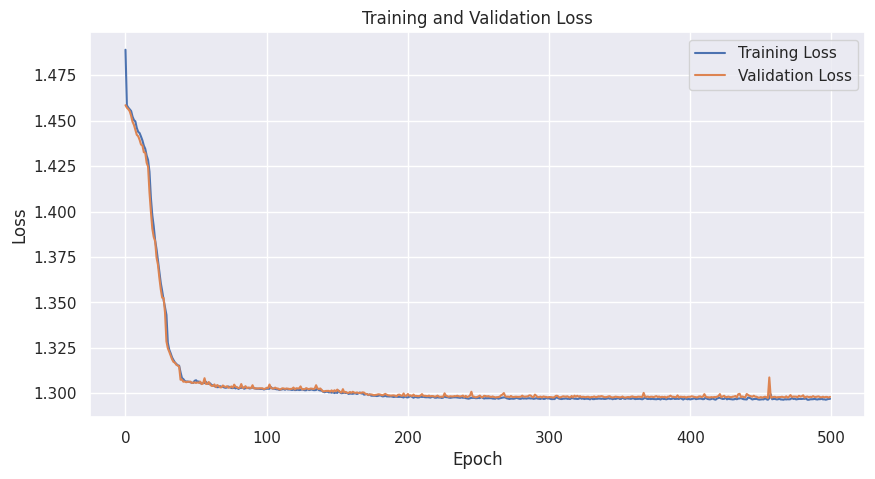

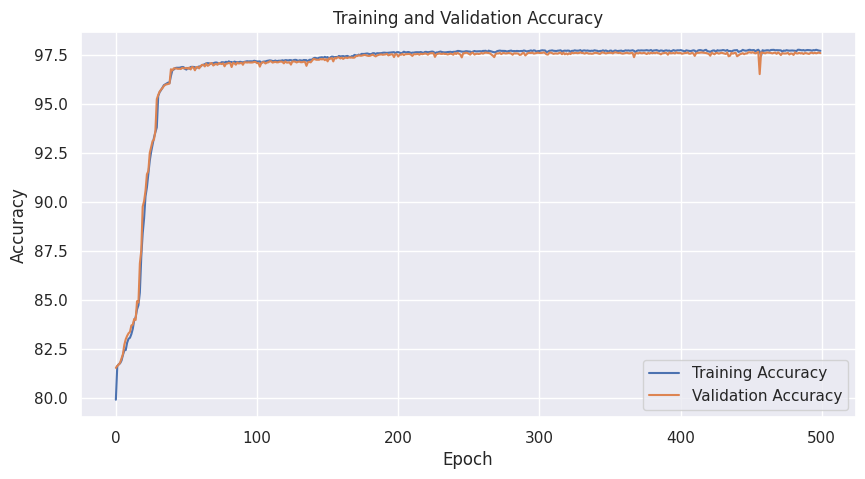

In [ ]:
input_features=46
learning_rate=0.0034834582322900276
loss=nn.CrossEntropyLoss()
epochs= 500
model=model_training('MLP_MultiClass',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

Here will be display the evaluation metrics

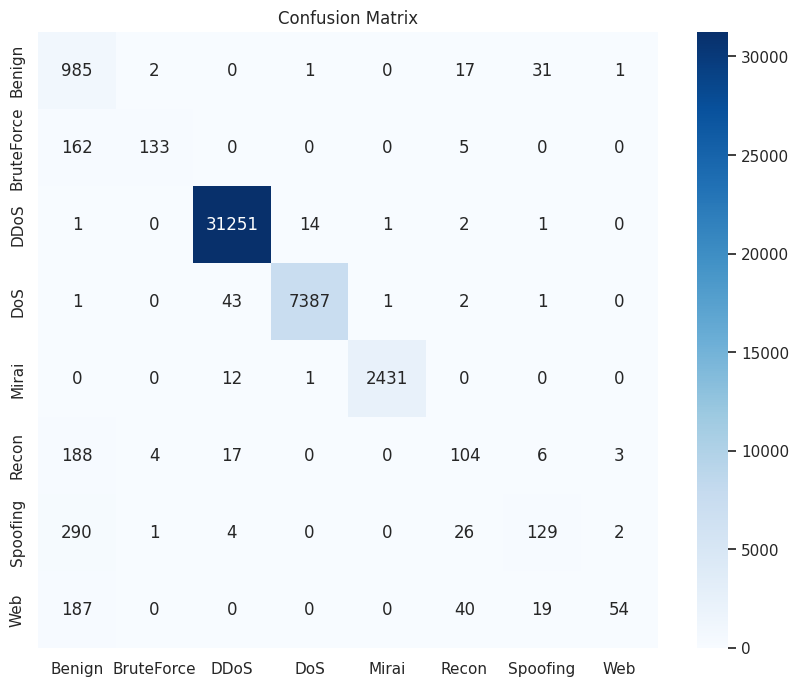

In [ ]:
all_predictions ,all_targets =model_evaluation(model,'MLP_MultiClass',test_loader)
cm = confusion_matrix(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)
recall = recall_score(all_targets, all_predictions, average=None)
f1 = f1_score(all_targets, all_predictions, average=None)
accuracy = accuracy_score(all_targets, all_predictions)

# Calculate overall precision, recall, and F1-score manually
precisionAll, recallAll, f1scoreall, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precisionAll, recallAll, f1scoreall, accuracy]
})
display(metrics_df.style.background_gradient())

# Create a DataFrame to display the results in a table
df_Evaluation = pd.DataFrame({
    'Class': classname_multiclass,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy
})
df_Evaluation.set_index('Class', inplace=True)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classname_multiclass, yticklabels=classname_multiclass)
plt.title('Confusion Matrix')
plt.show()
display(df_Evaluation.style.background_gradient())

Now keeping a copy of the model for further task

In [ ]:
file_name = os.path.join(modelFilePath, 'data_multiclass_all.pkl')
save_model(model,file_name)

### **Visualize**

Here, we will visualize the computational graph of our PyTorch model using the torchviz library, providing a comprehensive insight into the network architecture and enhancing our understanding of the model's structure

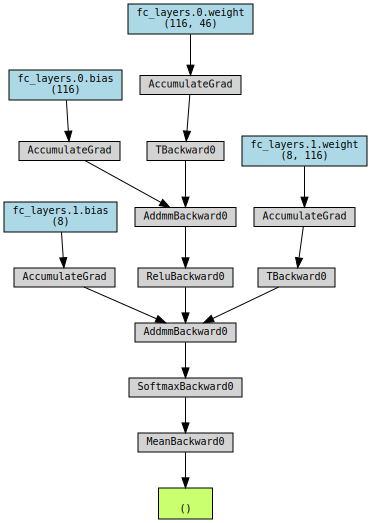

In [ ]:
model.to('cpu')
y = model(x_train_tensor_multiclass)
make_dot(y.mean(), params=dict(model.named_parameters()))

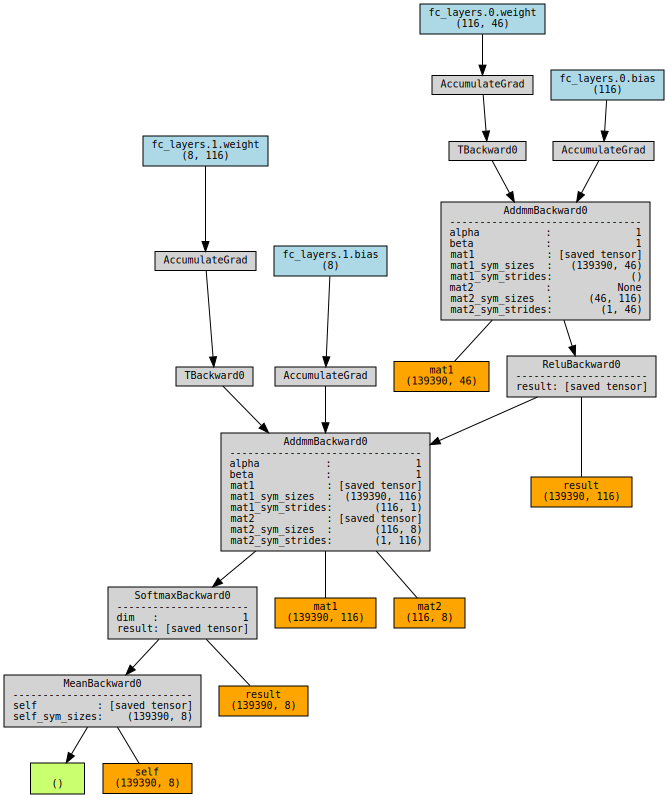

In [ ]:
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

### **Explainability - Captum**


After constructing our model, the subsequent phase involves enhancing the interpretability of Neural Networks. Therefore, our focus shifts towards examining the attributions of the constructed Neural Networks.

These attributions encompass three categories: Primary Attribution, Feature Attribution, and Neuron Attribution.

**Primary Attribution**

The primary aspect of Captum involves assessing the primary attributions, which determines the impact of individual input features on the model's output. To achieve this, the Integrated Gradients Algorithm is utilized to compute these primary attributions.

In the provided code snippet, the Integrated Gradients Algorithm is employed to determine the significant attributes at the feature level. Subsequently, the output is visualized for analysis and interpretation.

In [ ]:
%%time
model = nn.DataParallel(model)
model = model.to(device)

# Captum Integrated Gradients
interpreter = IntegratedGradients(model)

aggregated_attributions = []

# Iterate over the test dataloader batches
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
    inputs.requires_grad_()
    # Generate attributions using Integrated Gradients
    attributions, _ = interpreter.attribute(inputs, target=0, return_convergence_delta=True)
    aggregated_attributions.append(attributions)

# Concatenate the attributions along the batch dimension
aggregated_attributions = torch.cat(aggregated_attributions, dim=0)

# Convert the aggregated_attributions tensor to a numpy array
attributions_np = aggregated_attributions.cpu().detach().numpy()  # Move to CPU for numpy conversion

# Calculate the mean attributions across all samples
mean_attributions = np.mean(attributions_np, axis=0)

CPU times: user 35.2 s, sys: 284 ms, total: 35.5 s
Wall time: 35.4 s


**Visualization of the Output:**

In [ ]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", axis_title="Features"):
    print(title)
    feature_importances = list(zip(feature_names, importances))
    feature_importances.sort(key=lambda x: x[1], reverse=True)

    sorted_feature_names, sorted_importances = zip(*feature_importances)

    data = {'Feature Names': sorted_feature_names, 'Importances': sorted_importances}
    df = pd.DataFrame(data)
    df.set_index('Feature Names', inplace=True)
    display(df.style.background_gradient())

    x_pos = np.arange(len(sorted_feature_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x_pos, sorted_importances, align='center')
    plt.xlabel(axis_title)
    plt.ylabel("Importance")
    plt.title(title)

    plt.xticks(x_pos, sorted_feature_names, rotation=90)
    plt.tight_layout()
    plt.show()
    return sorted_feature_names, sorted_importances

Average Feature Importances


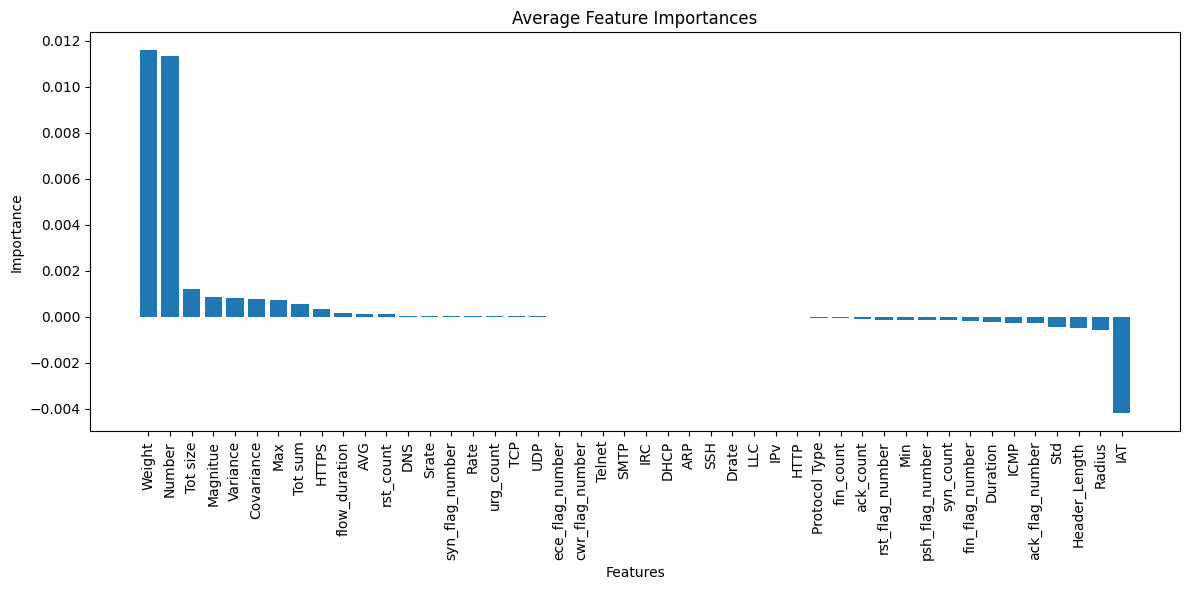

In [ ]:
feature_names = df.drop(columns='label').columns
sorted_feature_names, sorted_importances= visualize_importances(feature_names, np.mean(attributions_np, axis=0))


Based on the depicted graph, we can deduce that Weight and IAT significant roles in predicting diabetes. Positive weights indicate a stronger association between higher Weight and the likelihood of attack occurrence. Conversely, the negative weight associated with IAT and Header_Length suggests that lower Header_Length may correlate with a higher likelihood of attack.

**Layer Attribution:**

Layer attributions provide insights into the significance of individual neurons contributing to the output within a specific layer of the neural network architecture.


To employ Layer Conductance, we instantiate a LayerConductance object by providing the model and specifying the module (layer) from which we aim to comprehend the output. Here, we specifically select the output originating from the third hidden layer.


The provided code demonstrates the implementation of the Layer Conductance Algorithm specifically targeting the first hidden layer (where model.hidden_layer1 represents the output of this hidden layer). This code segment aims to visualize the resulting output.

In [ ]:
#Create Layer COnducatance Object
cond = LayerConductance(model.module, model.module.hidden_layer1)

In [ ]:
cond_vals_list = []

model = model.to(device)
# Set model to evaluation mode
model.eval()

cond_vals_list = []
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate conductance for the given inputs
    cond_vals = cond.attribute(inputs,target=1)  # Target seelcted for Bruteforce
    cond_vals_list.append(cond_vals.detach().cpu().numpy())

# Concatenate the conductance values along the batch dimension
cond_vals_combined = np.concatenate(cond_vals_list, axis=0)

**Visualize**

Average Neuron Importances


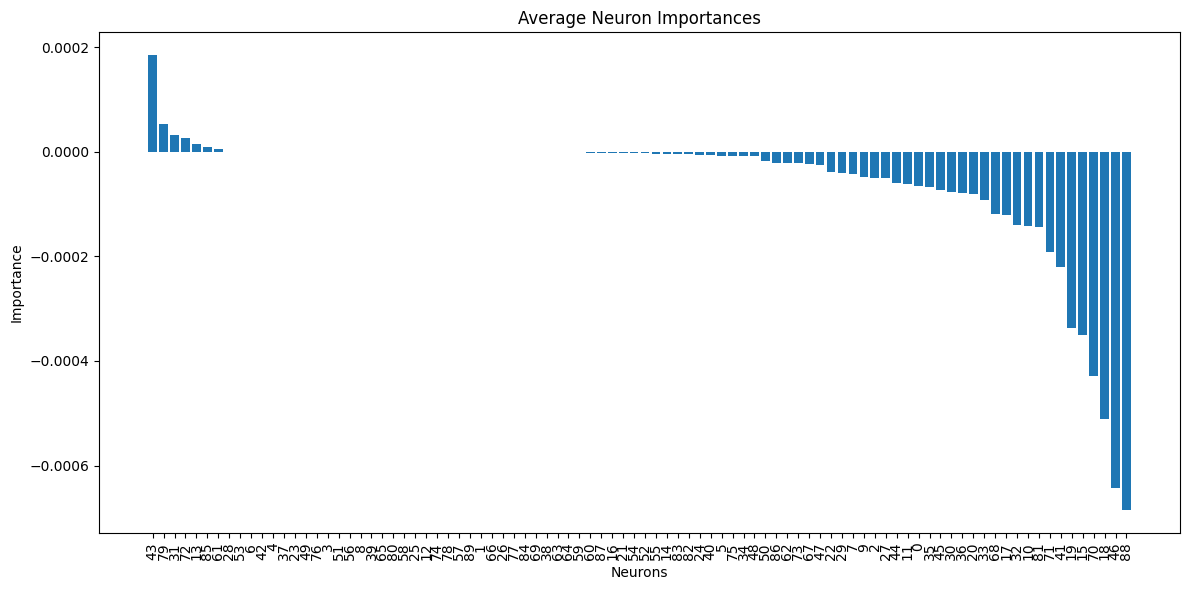

In [ ]:
sorted_feature_names, sorted_importances=visualize_importances(range(90),np.mean(cond_vals_combined, axis=0),title="Average Neuron Importances", axis_title="Neurons")

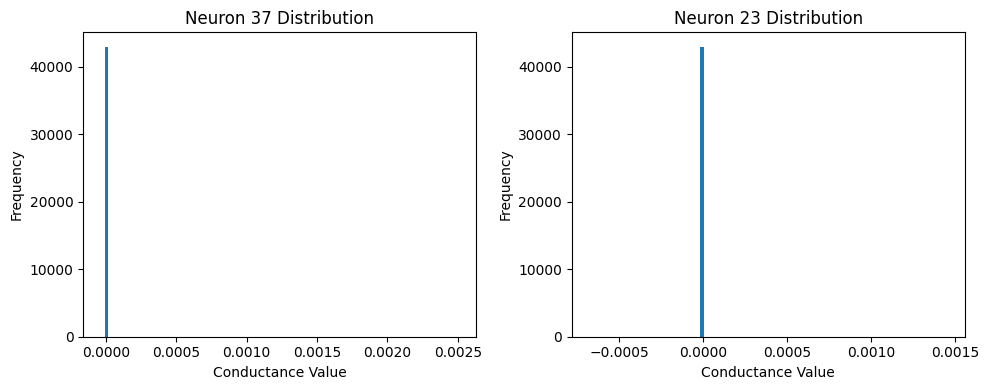

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the histogram for Neuron 37
axs[0].hist(cond_vals_combined[:, 37], bins=100)
axs[0].set_title('Neuron 37 Distribution')
axs[0].set_xlabel('Conductance Value')
axs[0].set_ylabel('Frequency')

# Plot the histogram for Neuron 23
axs[1].hist(cond_vals_combined[:, 23], bins=100)
axs[1].set_title('Neuron 23 Distribution')
axs[1].set_xlabel('Conductance Value')
axs[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Neuron Attributions:**

 Neuron Attributions enables us to comprehend the aspects of the input that influence the activation of a specific input neuron. In this instance, we will employ Neuron Conductance, which allocates the total conductance of the neuron into contributions from each individual input feature.

 To make use of Neuron Conductance, we create a NeuronConductance object, similar to how we do with Conductance. We pass in the model and specify the layer (module) whose output we want to understand—in this case, it's the first hidden layer's output, just like we did with Conductance.

Code for interpreting Neuron 43

In [ ]:
neuron_cond_vals_list = []

# model=model.module
# model = nn.DataParallel(model)
model = model.to(device)

neuron_cond = NeuronConductance(model, model.hidden_layer1)

# Set model to evaluation mode
model.eval()

# Iterate through the DataLoader batches
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate neuron conductance for neuron 43 for each input in the batch
    neuron_cond_vals = neuron_cond.attribute(inputs, neuron_selector=43, target=1)
    neuron_cond_vals_list.append(neuron_cond_vals.detach().cpu().numpy())

# Concatenate the neuron conductance values along the batch dimension
neuron_cond_vals_combined = np.concatenate(neuron_cond_vals_list, axis=0)

Average Feature Importances for Neuron 43


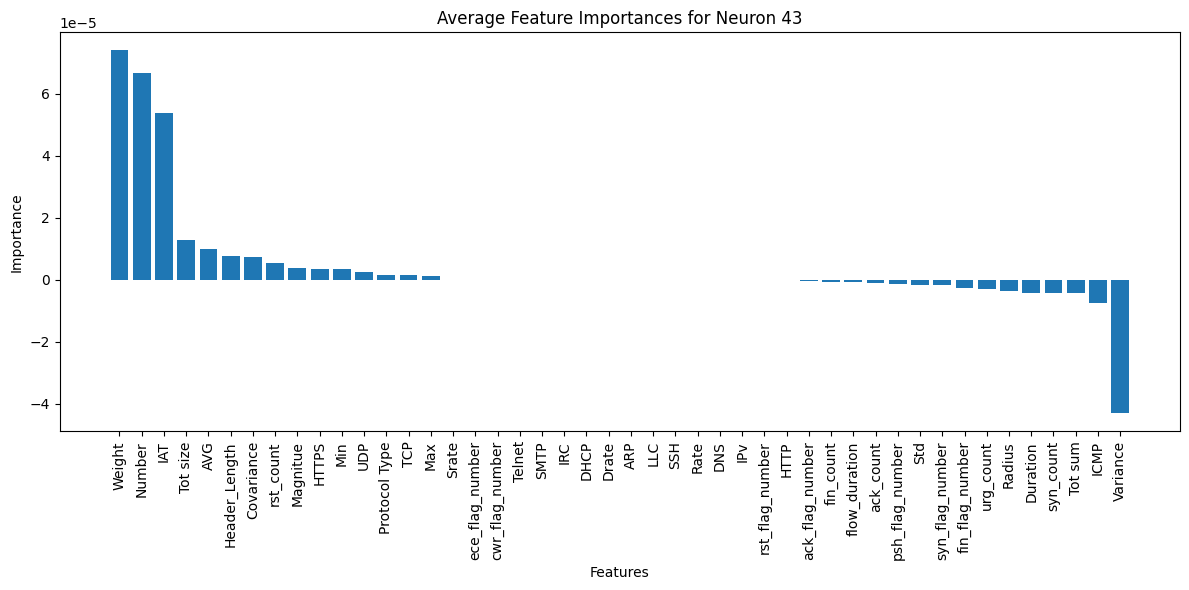

In [ ]:
#Visualize
featurenmaes=df.drop(columns='label').columns
sorted_feature_names, sorted_importances=visualize_importances(featurenmaes, np.mean(neuron_cond_vals_combined, axis=0), title="Average Feature Importances for Neuron 43")

Code for interpreting Neuron 88

In [ ]:
# Find Neoron attribution for node 88
for inputs, _ in test_loader:
    inputs = inputs.to(device)  # Move inputs to device

    # Calculate neuron conductance for neuron 88 for each input in the batch
    neuron_cond_vals = neuron_cond.attribute(inputs, neuron_selector=88, target=1)
    neuron_cond_vals_list.append(neuron_cond_vals.detach().cpu().numpy())

# Concatenate the neuron conductance values along the batch dimension
neuron_cond_vals_combined = np.concatenate(neuron_cond_vals_list, axis=0)

Average Feature Importances for Neuron 88


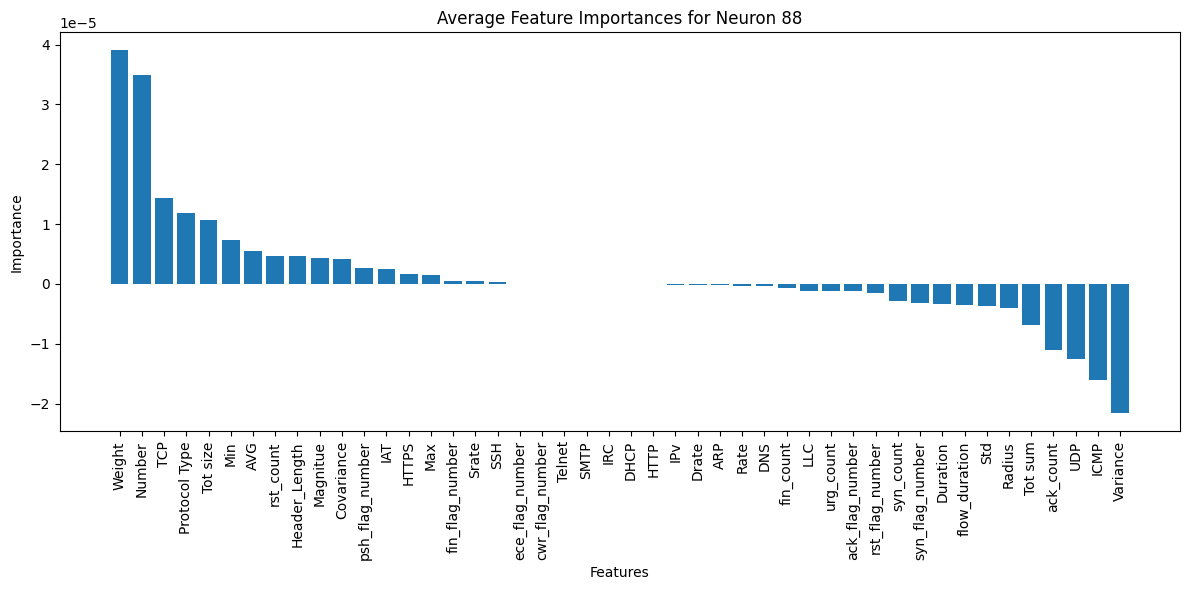

In [ ]:
#Visualize
sorted_feature_names, sorted_importances=visualize_importances(featurenmaes, np.mean(neuron_cond_vals_combined, axis=0), title="Average Feature Importances for Neuron 88")


Both neurons, namely 43 and 88, acquire significant features from the model, such as information related to Weight and Variance

### **Feature Engineering and Model Refinement - Captum**

In this phase, we leverage feature engineering techniques to enhance the model by removing columns with zero attributions identified through Captum. By retraining the model with this refined set of features, we aim to assess the impact on model effectiveness and potentially enhance its predictive performance.

In [ ]:
#Columns to be remove
columns_to_remove=['Srate','ece_flag_number','cwr_flag_number','Telnet','SMTP','IRC','DHCP','DNS','Drate']

In [ ]:

df = df.drop(columns=columns_to_remove)

In [ ]:
df.shape

(214963, 38)

Now we will retrain the model with new dataset

#### 1.   Model Preparation Phase

In [ ]:
# Model preparation
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_multiclass = model_prep(df,'MLP_MultiClass')

Starting label encoding...
Before Label Encoding....
DDoS          156346
DoS            37175
Mirai          12220
Benign          5186
Spoofing        2259
Recon           1612
Web              115
BruteForce        50
Name: label, dtype: int64
After Label Encoding....
2    156346
3     37175
4     12220
0      5186
6      2259
5      1612
7       115
1        50
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
Before sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 115 instances
1: 50 instances
After sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 1500 instances
1: 1500 instances
Finished Sampling

after spliting the data:

training data length: 139390
te

#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=542
train_loader,test_loader,valid_loader,x_train_tensor = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)

#### 3.   Model - Training & Validation

MLP_MultiClass(
  (fc_layers): ModuleList(
    (0): Linear(in_features=37, out_features=116, bias=True)
    (1): Linear(in_features=116, out_features=8, bias=True)
  )
)
Epoch 1
train_loss : 1.48503428 val_loss : 1.45852145
train_accuracy : 79.84 val_accuracy : 81.52
Epoch 11
train_loss : 1.44504276 val_loss : 1.44391071
train_accuracy : 82.90 val_accuracy : 82.95
Epoch 21
train_loss : 1.35260206 val_loss : 1.34759802
train_accuracy : 93.40 val_accuracy : 93.89
Epoch 31
train_loss : 1.31306855 val_loss : 1.31100626
train_accuracy : 96.34 val_accuracy : 96.53
Epoch 41
train_loss : 1.30716765 val_loss : 1.30658093
train_accuracy : 96.77 val_accuracy : 96.75
Epoch 51
train_loss : 1.30603504 val_loss : 1.30588778
train_accuracy : 96.84 val_accuracy : 96.81
Epoch 61
train_loss : 1.30532847 val_loss : 1.30513740
train_accuracy : 96.89 val_accuracy : 96.88
Epoch 71
train_loss : 1.30523748 val_loss : 1.30520942
train_accuracy : 96.88 val_accuracy : 96.86
Epoch 81
train_loss : 1.30512979 val_lo

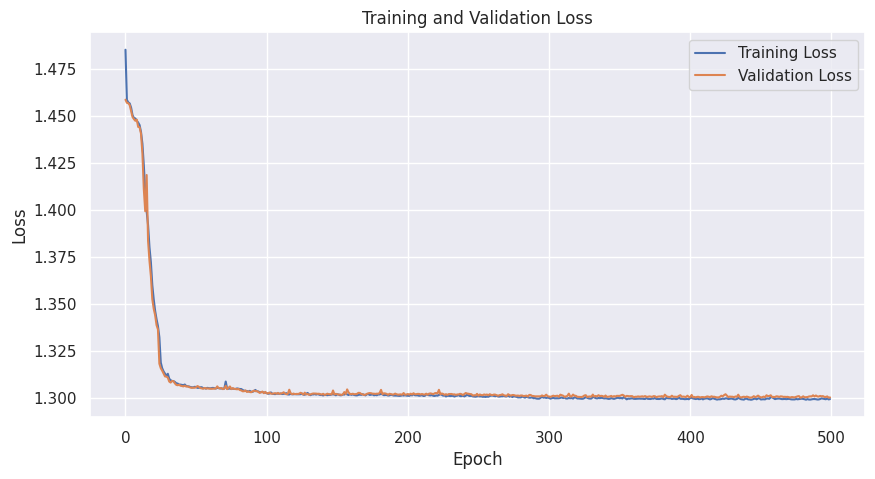

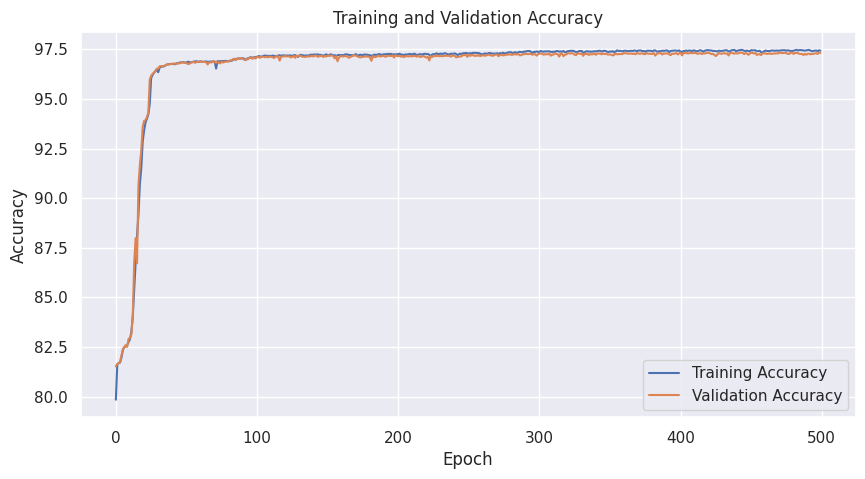

CPU times: user 15min 41s, sys: 8.24 s, total: 15min 49s
Wall time: 15min 6s


In [ ]:
%%time
# Train MLP model for binary classification
input_features=37
learning_rate=0.0044834582322900276
loss=nn.CrossEntropyLoss()
epochs= 500
model=model_training('MLP_MultiClass',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

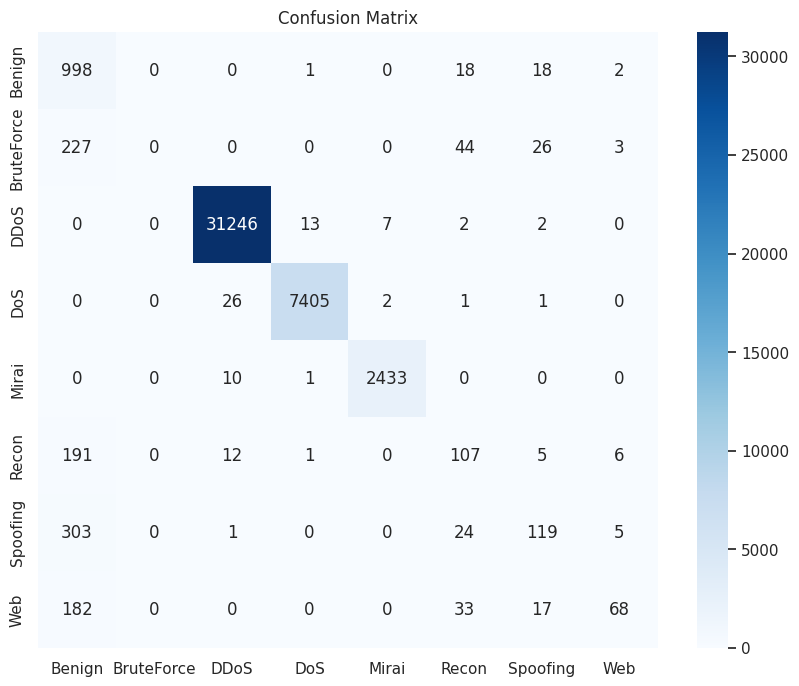

In [ ]:
#Ploting Evaluation matrics
all_predictions ,all_targets =model_evaluation(model,'MLP_MultiClass',test_loader)
cm = confusion_matrix(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)
recall = recall_score(all_targets, all_predictions, average=None)
f1 = f1_score(all_targets, all_predictions, average=None)
accuracy = accuracy_score(all_targets, all_predictions)

# Calculate overall precision, recall, and F1-score manually
precisionAll, recallAll, f1scoreall, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precisionAll, recallAll, f1scoreall, accuracy]
})
display(metrics_df.style.background_gradient())

# Create a DataFrame to display the results in a table
df_Evaluation = pd.DataFrame({
    'Class': classname_multiclass,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy
})
df_Evaluation.set_index('Class', inplace=True)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classname_multiclass, yticklabels=classname_multiclass)
plt.title('Confusion Matrix')
plt.show()
display(df_Evaluation.style.background_gradient())

After implementing feature engineering and refining the model, we observed no improvement in the performance of the model.

### **SHAP - DeepExplainer**

SHAP (SHapley Additive exPlanations) is a versatile model interpretability library that utilizes Shapley values to explain the output of machine learning models, providing insights into the contribution of individual features to model predictions.

Both global explanations (overall feature importances across the entire dataset) and local explanations (Insights into model predictions for individual instances) will be cumputed using SHAP, leveraging the summary plot for a comprehensive overview of feature importances on a global scale, and employing detailed visualizations such as force plots, waterfall plots, and dependency plots for localized insights into individual predictions.

**Global Explanation**

For global explanation DeepExplainer,which is one of the explainer methods provided by the library will be used to gain comprehensive insights into feature importances and understand the overall behavior of the neural network across the entire dataset.

In [ ]:
%%time
import shap
shap.initjs()
model.to('cpu')
model.eval()

#Create Explainer
explainer_multi = shap.DeepExplainer(model, x_train_tensor_multiclass[:1000])

CPU times: user 60 ms, sys: 6.98 ms, total: 67 ms
Wall time: 43.9 ms


For DeepExplainer in SHAP, calculating Shapley values on a representative dataset sample is recommended, as the background dataset is integrated over for feature attribution according to SHAP documentation.

In [ ]:
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [ ]:
x_test_tensor.shape

torch.Size([42993, 46])

In [ ]:
shap_values = explainer_multi.shap_values(x_test_tensor,check_additivity=False)

In [ ]:
 #checking the shape of shape values array
 print(np.array(shap_values).shape)

(8, 43560, 46)


**Visualize - Summary Plot**

The summary plot provides insights into the most influential features and quantifies their influence on the model, offering a global interpretation of the overall impact

In [ ]:
featurenames=df.drop(columns='label').columns

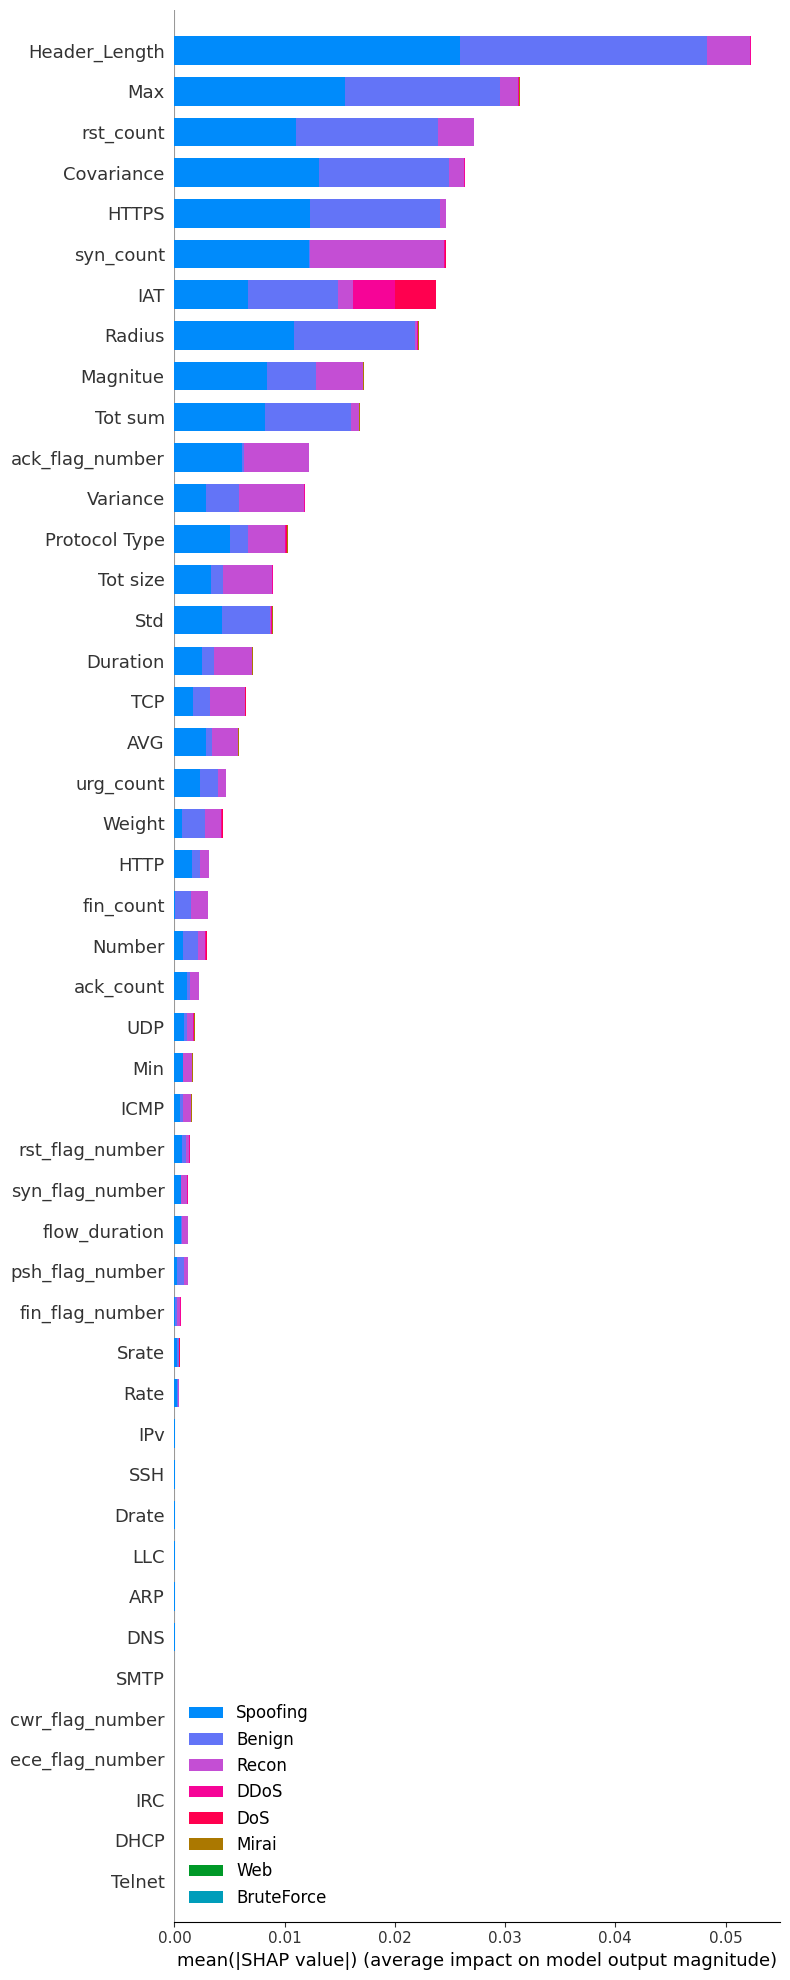

In [ ]:
import shap
shap.initjs()
shap.summary_plot(shap_values,features=x_test_tensor, plot_type = 'bar',feature_names = featurenames,max_display=46,class_names=classname_multiclass,auto_size_plot=True)

**Beeswarm plot**

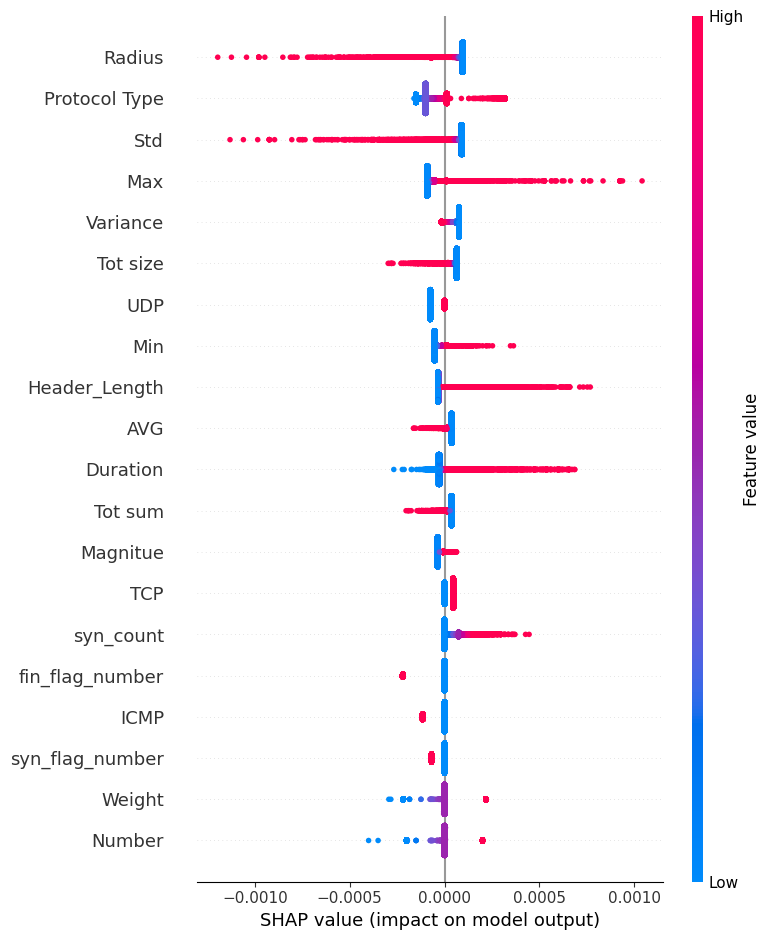

In [ ]:
shap.summary_plot(shap_values[4], x_test_tensor, feature_names =featurenames)

In [ ]:
mean_shap_values = np.mean(np.abs(shap_values), axis=(0, 1))  # Compute mean across classes and samples

# Get the indices that would sort the mean SHAP values in ascending order
sorted_indices = np.argsort(mean_shap_values)

# Display sorted SHAP values and corresponding feature names
sorted_feature_names = [featurenames[i] for i in sorted_indices]
sorted_mean_shap_values = mean_shap_values[sorted_indices]

for feature, shap in zip(sorted_feature_names, sorted_mean_shap_values):
    print(f"Feature: {feature}, Mean Absolute SHAP Value: {round(shap,6)}")

Feature: Telnet, Mean Absolute SHAP Value: 0.0
Feature: DHCP, Mean Absolute SHAP Value: 0.0
Feature: IRC, Mean Absolute SHAP Value: 0.0
Feature: ece_flag_number, Mean Absolute SHAP Value: 0.0
Feature: cwr_flag_number, Mean Absolute SHAP Value: 0.0
Feature: SMTP, Mean Absolute SHAP Value: 0.0
Feature: DNS, Mean Absolute SHAP Value: 2e-06
Feature: ARP, Mean Absolute SHAP Value: 2e-06
Feature: LLC, Mean Absolute SHAP Value: 3e-06
Feature: Drate, Mean Absolute SHAP Value: 5e-06
Feature: SSH, Mean Absolute SHAP Value: 6e-06
Feature: IPv, Mean Absolute SHAP Value: 8e-06
Feature: Rate, Mean Absolute SHAP Value: 5.7e-05
Feature: Srate, Mean Absolute SHAP Value: 5.8e-05
Feature: fin_flag_number, Mean Absolute SHAP Value: 7.6e-05
Feature: psh_flag_number, Mean Absolute SHAP Value: 0.000151
Feature: flow_duration, Mean Absolute SHAP Value: 0.000152
Feature: syn_flag_number, Mean Absolute SHAP Value: 0.000157
Feature: rst_flag_number, Mean Absolute SHAP Value: 0.000172
Feature: ICMP, Mean Absolute

**Force Plot**

In [ ]:
# Evaluation on test set
model.eval()
model.to(device)
all_predictions ,all_targets =model_evaluation(model,'MLP_MultiClass',test_loader)

In [ ]:
# Convert predictions and targets to NumPy arrays
all_predictions_a = np.array(all_predictions)
all_targets_a = np.array(all_targets)

# Find indices where predictions do not match the targets
incorrect_indices = np.where(all_predictions_a != all_targets_a)[0]

# Display the indices of falsely predicted instances
#print("Indices of falsely predicted instances:", incorrect_indices)
print("\nTarget and Prediction for Incorrect Instances:")
for idx in incorrect_indices:
    print(f"Index: {idx}, Target: {all_targets_a[idx]}, Prediction: {all_predictions_a[idx]}")


Target and Prediction for Incorrect Instances:
Index: 44, Target: 5, Prediction: 0
Index: 181, Target: 3, Prediction: 2
Index: 234, Target: 7, Prediction: 0
Index: 271, Target: 5, Prediction: 0
Index: 278, Target: 0, Prediction: 6
Index: 287, Target: 4, Prediction: 2
Index: 324, Target: 7, Prediction: 0
Index: 490, Target: 0, Prediction: 6
Index: 497, Target: 5, Prediction: 0
Index: 575, Target: 6, Prediction: 0
Index: 604, Target: 7, Prediction: 0
Index: 608, Target: 5, Prediction: 6
Index: 613, Target: 6, Prediction: 0
Index: 742, Target: 6, Prediction: 0
Index: 743, Target: 7, Prediction: 0
Index: 812, Target: 7, Prediction: 0
Index: 822, Target: 0, Prediction: 6
Index: 880, Target: 5, Prediction: 0
Index: 909, Target: 1, Prediction: 0
Index: 938, Target: 0, Prediction: 5
Index: 993, Target: 7, Prediction: 0
Index: 1019, Target: 7, Prediction: 0
Index: 1076, Target: 7, Prediction: 0
Index: 1097, Target: 5, Prediction: 0
Index: 1122, Target: 6, Prediction: 7
Index: 1151, Target: 1, 

<!-- Index: 2142, Target: 3, Prediction: 2 -->
Index: 6382, Target: 7, Prediction: 5


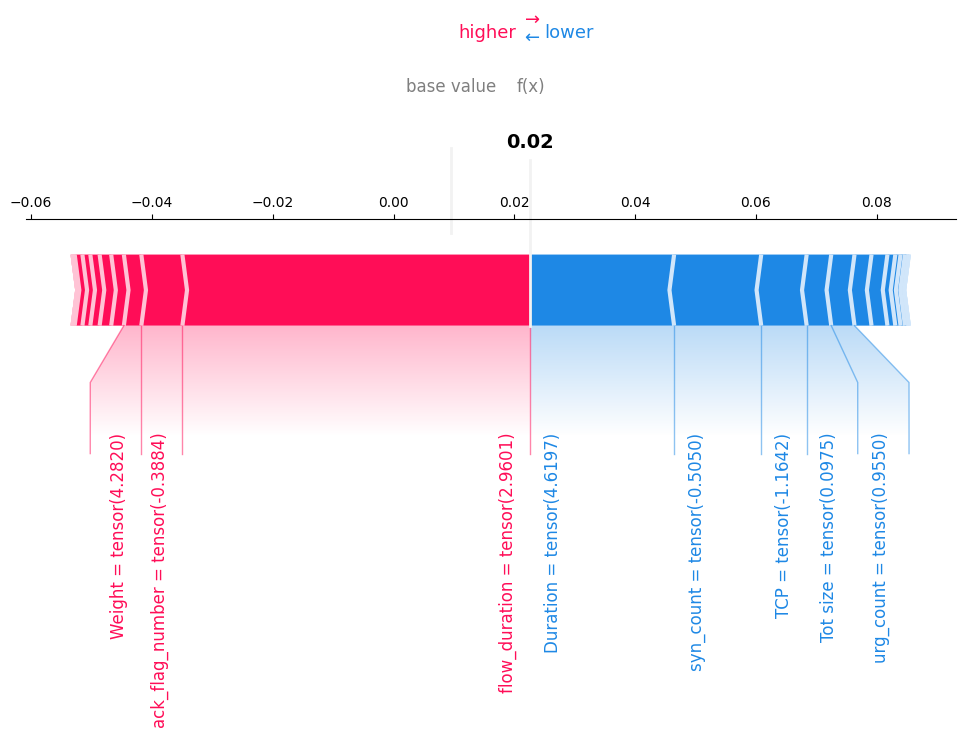

In [ ]:
import shap
shap.initjs()

# Index: 6382, Target: 7, Prediction: 5
# Choose a specific instance and class for explanation
instance_index = 6382
class_index = 5
shap_values_instance_class = shap_values[class_index][instance_index]

# Display the force plot for the chosen instance and class
shap.force_plot(
    explainer_multi.expected_value[class_index],
    shap_values_instance_class,
    x_test_tensor[instance_index],
    feature_names=featurenames,
    matplotlib=True,
    text_rotation=90,
    figsize=(12, 6)
)

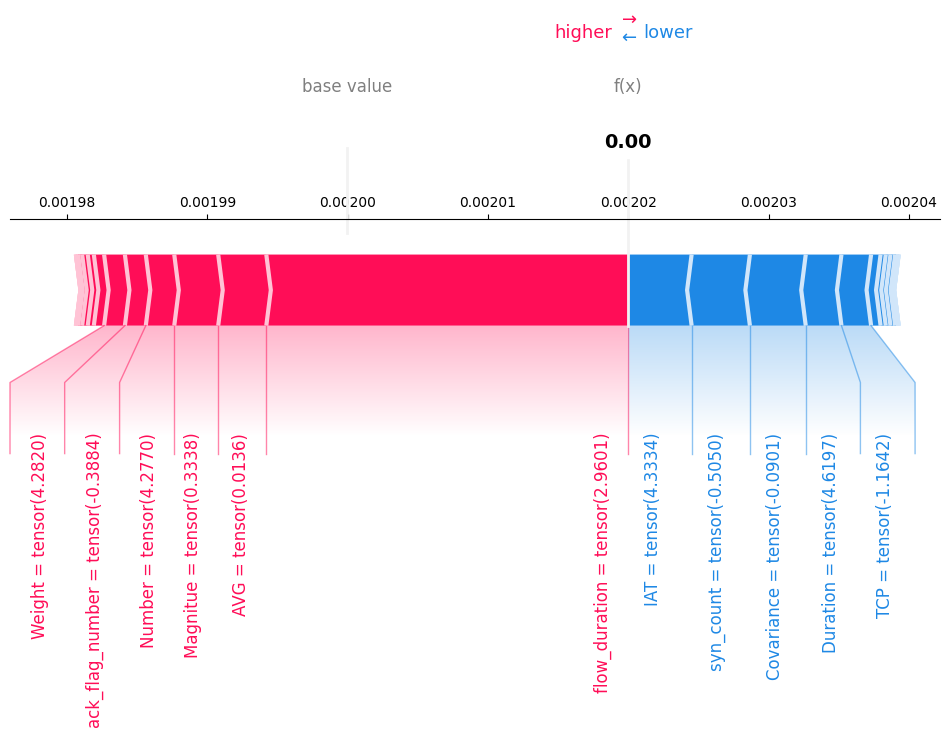

In [ ]:
shap.initjs()
# Index: 6382, Target: 7, Prediction: 5
# Choose a specific instance and class for explanation
instance_index = 6382
class_index = 7
shap_values_instance_class = shap_values[class_index][instance_index]

# Display the force plot for the chosen instance and class
shap.force_plot(
    explainer_multi.expected_value[class_index],
    shap_values_instance_class,
    x_test_tensor[instance_index],
    feature_names=featurenames,
    matplotlib=True,
    text_rotation=90,
    figsize=(12, 6)
)

**Waterfall plot**

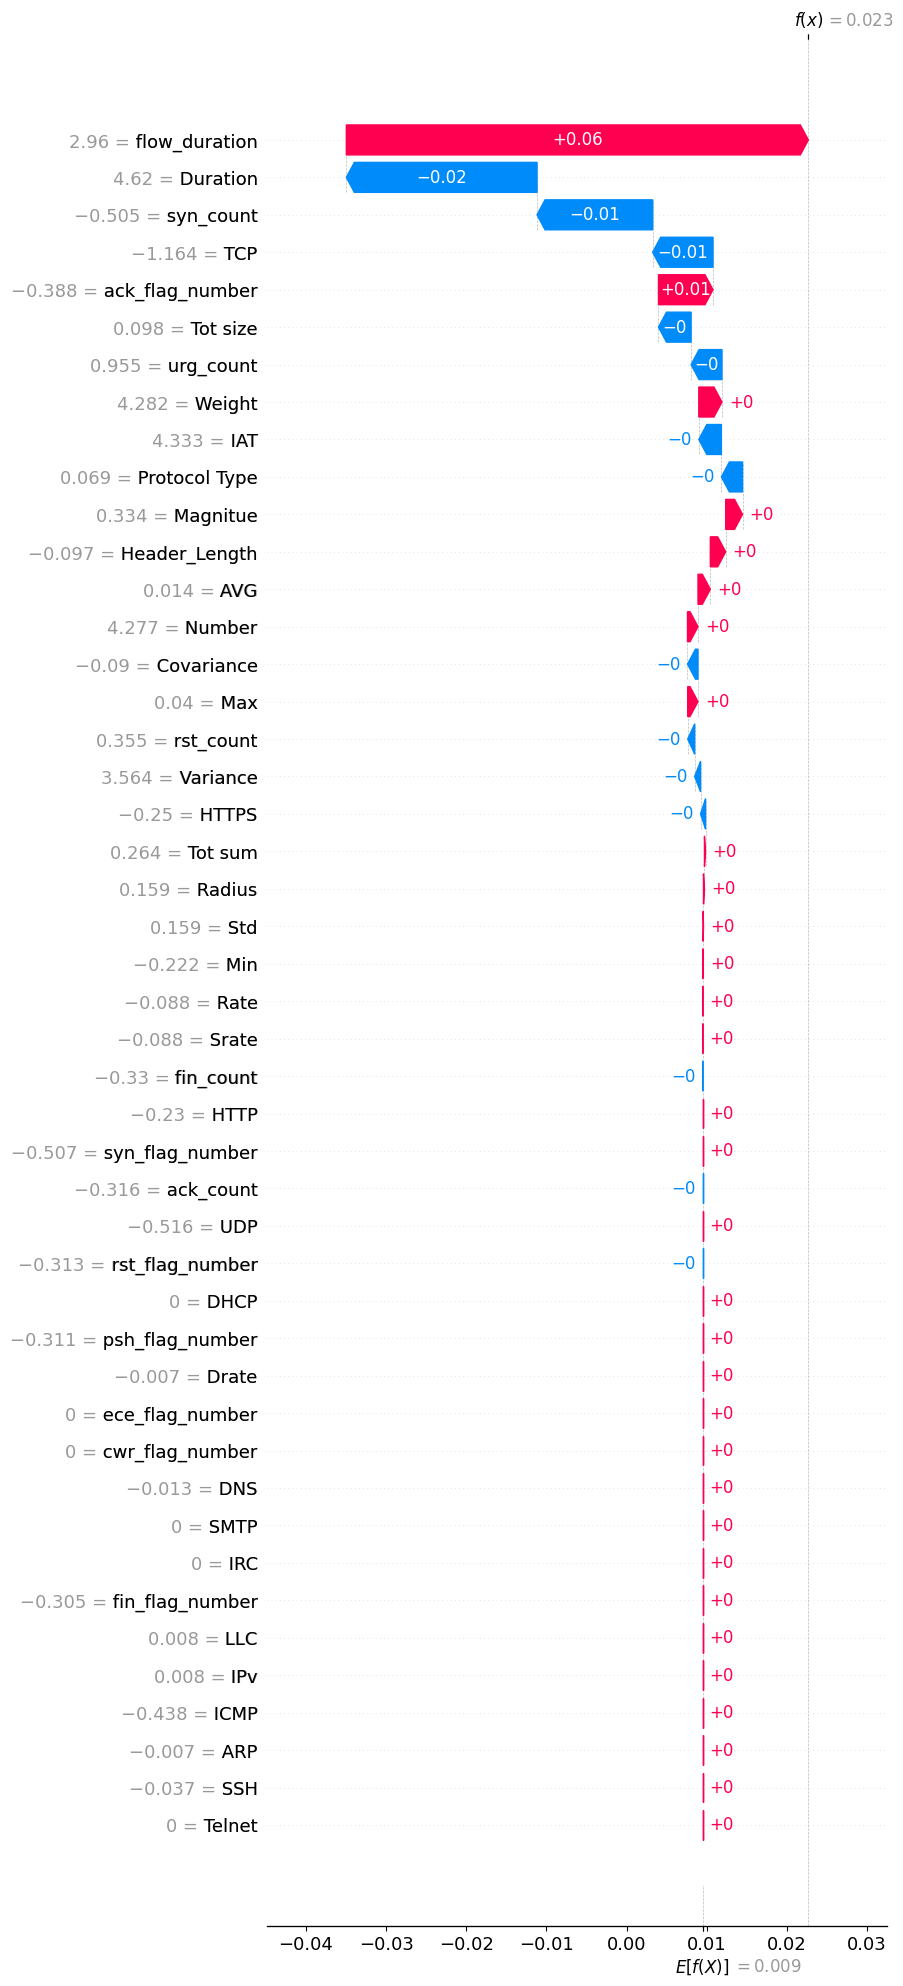

In [ ]:
row = 6382
shap.waterfall_plot(shap.Explanation(values=shap_values[5][row],
                                              base_values=explainer_multi.expected_value[5], data=X_test[row,:],
                                         feature_names=featurenames),max_display=46)




**Dependence Plot**

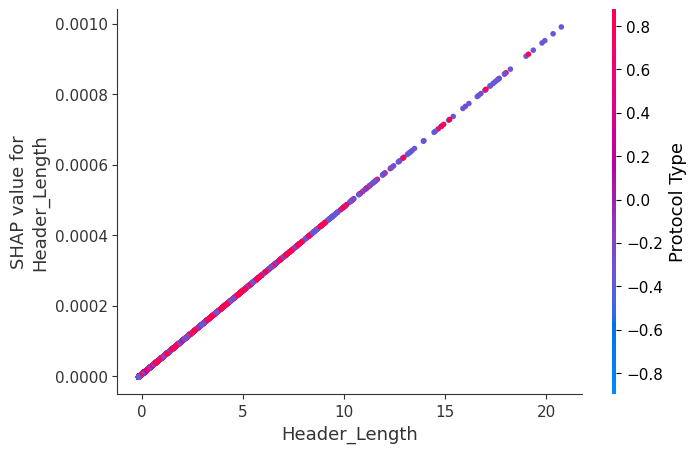

In [ ]:
shap.dependence_plot(1, shap_values[0],X_test, interaction_index=2,feature_names=featurenames)

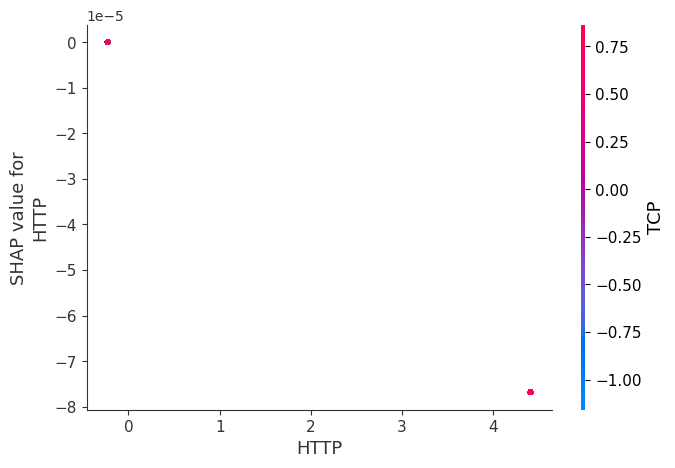

In [ ]:
shap.dependence_plot(19, shap_values[5], X_test, feature_names =featurenames)

### **Feature Engineering and Model Refinement - SHAP**

In this phase, we leverage feature engineering techniques to enhance the model by removing columns with zero attributions identified through Captum. By retraining the model with this refined set of features, we aim to assess the impact on model effectiveness and potentially enhance its predictive performance.

In [ ]:
#Columns to be removed
columns_to_remove_multi=['Telnet','DHCP','IRC','ece_flag_number','cwr_flag_number','SMTP','DNS','ARP','LLC','Drate','SSH','IPv','Rate','Srate','fin_flag_number']

In [ ]:

df = df.drop(columns=columns_to_remove_multi)

In [ ]:
df.shape

(214963, 32)

Now we will retrain the model with new dataset

#### 1.   Model Preparation Phase

In [ ]:
# Model preparation
X_train, X_test,X_valid, y_train, y_test,y_valid,classname_multiclass_new = model_prep(df,'MLP_MultiClass')

Starting label encoding...
Before Label Encoding....
DDoS          156346
DoS            37175
Mirai          12220
Benign          5186
Spoofing        2259
Recon           1612
Web              115
BruteForce        50
Name: label, dtype: int64
After Label Encoding....
2    156346
3     37175
4     12220
0      5186
6      2259
5      1612
7       115
1        50
Name: label, dtype: int64
Label encoding completed.
....................................................
Performing train-test split...
Before sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 115 instances
1: 50 instances
After sampling the data:

Instances per label in training set:
2: 156346 instances
3: 37175 instances
4: 12220 instances
0: 5186 instances
6: 2259 instances
5: 1612 instances
7: 1500 instances
1: 1500 instances
Finished Sampling

after spliting the data:

training data length: 139390
te

#### 2.   Batching and loading as tensor

In [ ]:
# Prepare Tensors and Datal loaders for model development
batch_size=542
train_loader,test_loader,valid_loader,x_train_tensor = prep_tensor(X_train,X_test,X_valid, y_train, y_test,y_valid,batch_size)
x_train_tensor_multiclass=x_train_tensor

#### 3.   Model - Training & Validation

In [ ]:
X_train.shape

(139390, 31)

MLP_MultiClass(
  (fc_layers): ModuleList(
    (0): Linear(in_features=31, out_features=116, bias=True)
    (1): Linear(in_features=116, out_features=8, bias=True)
  )
)
Epoch 1
train_loss : 1.48348845 val_loss : 1.45879126
train_accuracy : 79.92 val_accuracy : 81.50
Epoch 11
train_loss : 1.44523104 val_loss : 1.44470623
train_accuracy : 82.85 val_accuracy : 82.83
Epoch 21
train_loss : 1.40055575 val_loss : 1.39511654
train_accuracy : 87.77 val_accuracy : 89.29
Epoch 31
train_loss : 1.33535275 val_loss : 1.33434276
train_accuracy : 94.46 val_accuracy : 94.46
Epoch 41
train_loss : 1.31200912 val_loss : 1.30996571
train_accuracy : 96.41 val_accuracy : 96.49
Epoch 51
train_loss : 1.30499331 val_loss : 1.30457581
train_accuracy : 96.95 val_accuracy : 96.95
Epoch 61
train_loss : 1.30430614 val_loss : 1.30468919
train_accuracy : 97.01 val_accuracy : 96.96
Epoch 71
train_loss : 1.30371295 val_loss : 1.30404042
train_accuracy : 97.05 val_accuracy : 96.99
Epoch 81
train_loss : 1.30344475 val_lo

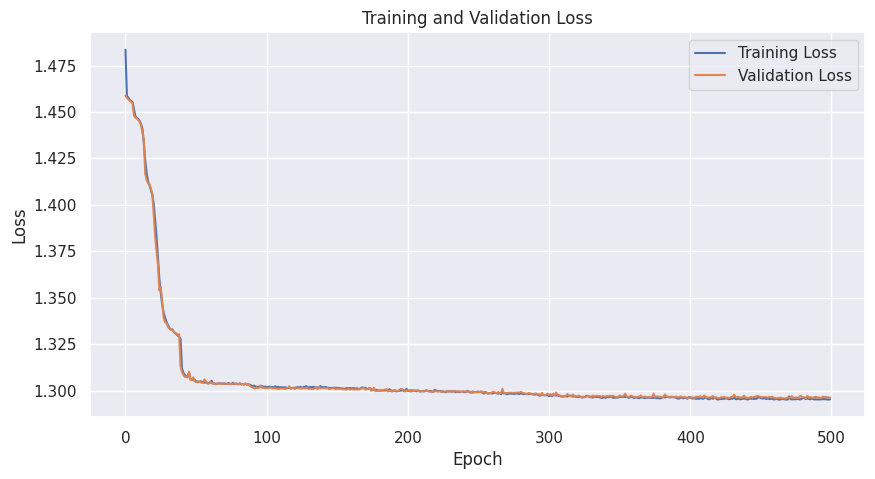

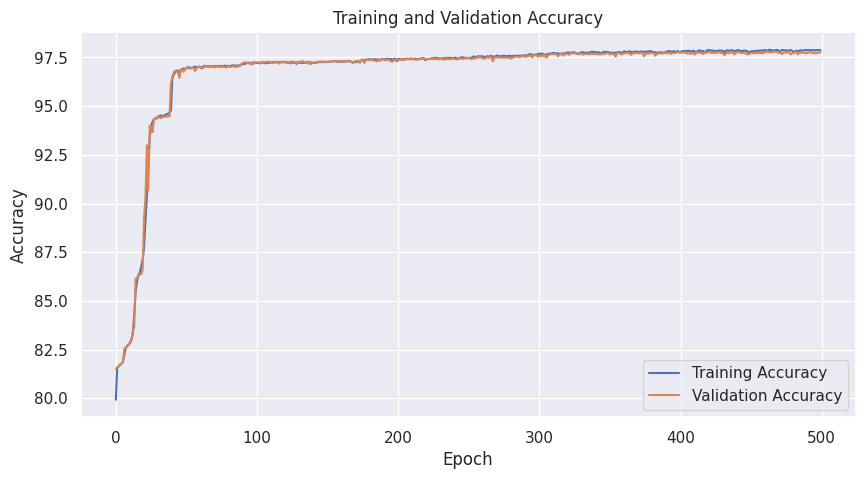

In [ ]:
input_features=31
learning_rate=0.0044834582322900276
loss=nn.CrossEntropyLoss()
epochs= 500
model=model_training('MLP_MultiClass',input_features,learning_rate,loss,train_loader,test_loader,valid_loader,epochs)

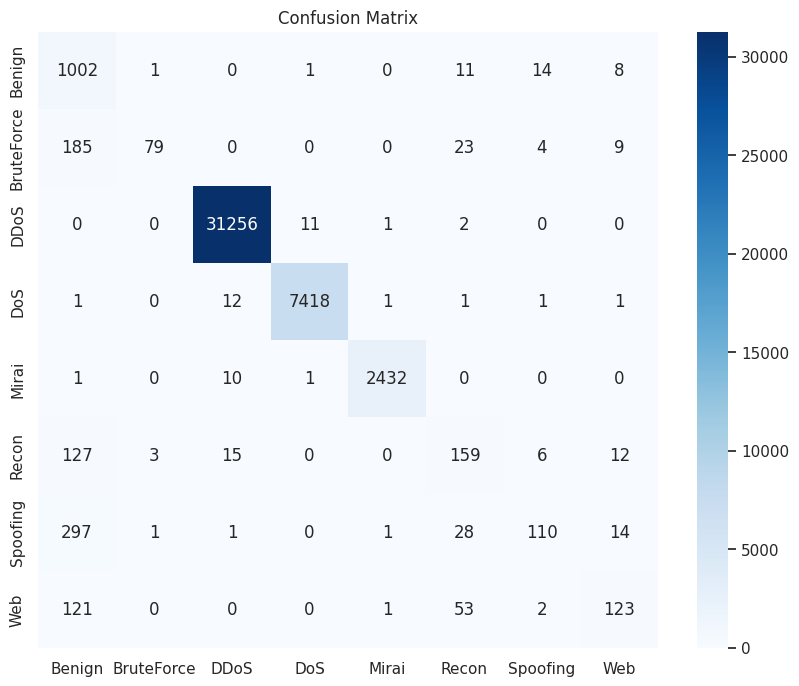

In [ ]:
#Ploting evaluation metrics
all_predictions ,all_targets =model_evaluation(model,'MLP_MultiClass',test_loader)
cm = confusion_matrix(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average=None)
recall = recall_score(all_targets, all_predictions, average=None)
f1 = f1_score(all_targets, all_predictions, average=None)
accuracy = accuracy_score(all_targets, all_predictions)

# Calculate overall precision, recall, and F1-score manually
precisionAll, recallAll, f1scoreall, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Score': [precisionAll, recallAll, f1scoreall, accuracy]
})
display(metrics_df.style.background_gradient())

# Create a DataFrame to display the results in a table
df_Evaluation = pd.DataFrame({
    'Class': classname_multiclass,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy
})
df_Evaluation.set_index('Class', inplace=True)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classname_multiclass, yticklabels=classname_multiclass)
plt.title('Confusion Matrix')
plt.show()
display(df_Evaluation.style.background_gradient())

After implementing feature engineering and refining the model, we observed remarkable enhancements in the performance of the model.

## **Conclusion**

*   Successfully developed an Explainable Intrusion Detection System for IoT networks using an MLP model.
*   Achieved outstanding accuracy of 99.32% for binary classification and 97.7.54% for multi-class classification.

*   Utilized SHAP and Captum, including the novel DeepExplainer in SHAP, for valuable insights into model decisions.

*   Iterative refinement based on feature importance led to significant improvements in accuracy and F1 score.

*   Novelty lies in achieving high accuracy, transparency through explainability tools, and optimal parameter tuning with Optuna.

## **Future scope**

*   Explore advanced computing resources for a more exhaustive analysis due to constraints posed by the large dataset.

*   Leverage additional SHAP plots like dependence plots to gain deeper insights into feature dependencies.

*   Expand the dataset or explore diverse datasets for a more comprehensive understanding of model robustness.